In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier   
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier 
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['font.size'] = 24


from Classification import *

# 1. Data Preparation

#### (1) Import Data and get basic information

In [2]:
# Import data
data=pd.read_csv("ObesityData.csv")
data

id  Gender        Age    Height      Weight  \
0          0    Male  24.443011  1.699998   81.669950   
1          1  Female  18.000000  1.560000   57.000000   
2          2  Female  18.000000  1.711460   50.165754   
3          3  Female  20.952737  1.710730  131.274851   
4          4    Male  31.641081  1.914186   93.798055   
...      ...     ...        ...       ...         ...   
20753  20753    Male  25.137087  1.766626  114.187096   
20754  20754    Male  18.000000  1.710000   50.000000   
20755  20755    Male  20.101026  1.819557  105.580491   
20756  20756    Male  33.852953  1.700000   83.520113   
20757  20757    Male  26.680376  1.816547  118.134898   

      family_history_with_overweight FAVC      FCVC       NCP        CAEC  \
0                                yes  yes  2.000000  2.983297   Sometimes   
1                                yes  yes  2.000000  3.000000  Frequently   
2                                yes  yes  1.880534  1.411685   Sometimes   
3                                yes  yes  3.000000  3.000000   Sometimes   
4                                yes  yes  2.679664  1.971472   Sometimes   
...                              ...  ...       ...       ...         ...   
20753                            yes  yes  2.919584  3.000000   Sometimes   
20754                             no  yes  3.000000  4.000000  Frequently   
20755                            yes  yes  2.407817  3.000000   Sometimes   
20756                            yes  yes  2.671238  1.971472   Sometimes   
20757                            yes  yes  3.000000  3.000000   Sometimes   

      SMOKE      CH2O SCC       FAF       TUE       CALC  \
0        no  2.763573  no  0.000000  0.976473  Sometimes   
1        no  2.000000  no  1.000000  1.000000         no   
2        no  1.910378  no  0.866045  1.673584         no   
3        no  1.674061  no  1.467863  0.780199  Sometimes   
4        no  1.979848  no  1.967973  0.931721  Sometimes   
...     ...       ...  ..       ...       ...        ...   
20753    no  2.151809  no  1.330519  0.196680  Sometimes   
20754    no  1.000000  no  2.000000  1.000000  Sometimes   
20755    no  2.000000  no  1.158040  1.198439         no   
20756    no  2.144838  no  0.000000  0.973834         no   
20757    no  2.003563  no  0.684487  0.713823  Sometimes   

                      MTRANS           NObeyesdad  
0      Public_Transportation  Overweight_Level_II  
1                 Automobile        Normal_Weight  
2      Public_Transportation  Insufficient_Weight  
3      Public_Transportation     Obesity_Type_III  
4      Public_Transportation  Overweight_Level_II  
...                      ...                  ...  
20753  Public_Transportation      Obesity_Type_II  
20754  Public_Transportation  Insufficient_Weight  
20755  Public_Transportation      Obesity_Type_II  
20756             Automobile  Overweight_Level_II  
20757  Public_Transportation      Obesity_Type_II  

[20758 rows x 18 columns]

In [3]:
data.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [4]:
data.describe()

id           Age        Height        Weight          FCVC  \
count  20758.00000  20758.000000  20758.000000  20758.000000  20758.000000   
mean   10378.50000     23.841804      1.700245     87.887768      2.445908   
std     5992.46278      5.688072      0.087312     26.379443      0.533218   
min        0.00000     14.000000      1.450000     39.000000      1.000000   
25%     5189.25000     20.000000      1.631856     66.000000      2.000000   
50%    10378.50000     22.815416      1.700000     84.064875      2.393837   
75%    15567.75000     26.000000      1.762887    111.600553      3.000000   
max    20757.00000     61.000000      1.975663    165.057269      3.000000   

                NCP          CH2O           FAF           TUE  
count  20758.000000  20758.000000  20758.000000  20758.000000  
mean       2.761332      2.029418      0.981747      0.616756  
std        0.705375      0.608467      0.838302      0.602113  
min        1.000000      1.000000      0.000000      0.000000  
25%        3.000000      1.792022      0.008013      0.000000  
50%        3.000000      2.000000      1.000000      0.573887  
75%        3.000000      2.549617      1.587406      1.000000  
max        4.000000      3.000000      3.000000      2.000000

#### (2) Cleaning & Preprocessing

In [5]:
# Remove invalid values
data.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
data.drop_duplicates()
data.dropna()

# List of all variables
num_var=['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
cat_var=['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
all_var=num_var+cat_var

NObeyesdad_labels={
    'Insufficient_Weight':'1',
    'Normal_Weight':'2',
    'Overweight_Level_I':'3',
    'Overweight_Level_II':'4',
    'Obesity_Type_I':'5',
    'Obesity_Type_II':'6',
    'Obesity_Type_III':'7',
}

data1=data[all_var+['NObeyesdad']]
# Encode target
for i in range(len(data1)):
    data1.loc[i,'NObeyesdad']=NObeyesdad_labels[data1.loc[i,'NObeyesdad']]

data1


Age    Height      Weight      FCVC       NCP      CH2O  \
0      24.443011  1.699998   81.669950  2.000000  2.983297  2.763573   
1      18.000000  1.560000   57.000000  2.000000  3.000000  2.000000   
2      18.000000  1.711460   50.165754  1.880534  1.411685  1.910378   
3      20.952737  1.710730  131.274851  3.000000  3.000000  1.674061   
4      31.641081  1.914186   93.798055  2.679664  1.971472  1.979848   
...          ...       ...         ...       ...       ...       ...   
20753  25.137087  1.766626  114.187096  2.919584  3.000000  2.151809   
20754  18.000000  1.710000   50.000000  3.000000  4.000000  1.000000   
20755  20.101026  1.819557  105.580491  2.407817  3.000000  2.000000   
20756  33.852953  1.700000   83.520113  2.671238  1.971472  2.144838   
20757  26.680376  1.816547  118.134898  3.000000  3.000000  2.003563   

            FAF       TUE  Gender family_history_with_overweight FAVC  \
0      0.000000  0.976473    Male                            yes  yes   
1      1.000000  1.000000  Female                            yes  yes   
2      0.866045  1.673584  Female                            yes  yes   
3      1.467863  0.780199  Female                            yes  yes   
4      1.967973  0.931721    Male                            yes  yes   
...         ...       ...     ...                            ...  ...   
20753  1.330519  0.196680    Male                            yes  yes   
20754  2.000000  1.000000    Male                             no  yes   
20755  1.158040  1.198439    Male                            yes  yes   
20756  0.000000  0.973834    Male                            yes  yes   
20757  0.684487  0.713823    Male                            yes  yes   

             CAEC SMOKE SCC       CALC                 MTRANS NObeyesdad  
0       Sometimes    no  no  Sometimes  Public_Transportation          4  
1      Frequently    no  no         no             Automobile          2  
2       Sometimes    no  no         no  Public_Transportation          1  
3       Sometimes    no  no  Sometimes  Public_Transportation          7  
4       Sometimes    no  no  Sometimes  Public_Transportation          4  
...           ...   ...  ..        ...                    ...        ...  
20753   Sometimes    no  no  Sometimes  Public_Transportation          6  
20754  Frequently    no  no  Sometimes  Public_Transportation          1  
20755   Sometimes    no  no         no  Public_Transportation          6  
20756   Sometimes    no  no         no             Automobile          4  
20757   Sometimes    no  no  Sometimes  Public_Transportation          6  

[20758 rows x 17 columns]

# 2. Basic Exploration

#### (1) Preparation for exploration

In [6]:
single_trees=[]
for x in all_var:
    single_trees.append(Classification(data1,x,'NObeyesdad'))

#### (2) Explore the target 'NObeyesdad'

/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


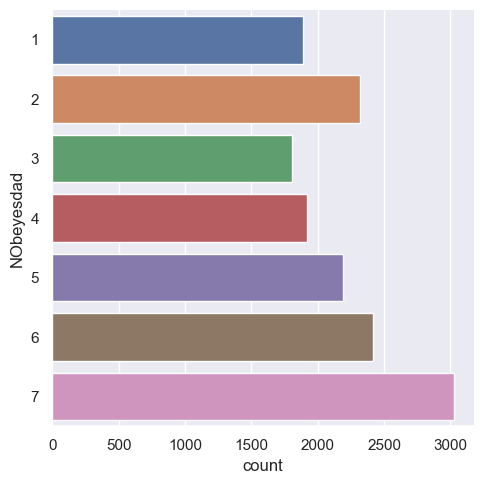

In [7]:
y_order=['1','2','3','4','5','6','7']
single_trees[0].y_diagram(y_order)

#### (3) Explore each predictor

/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
 

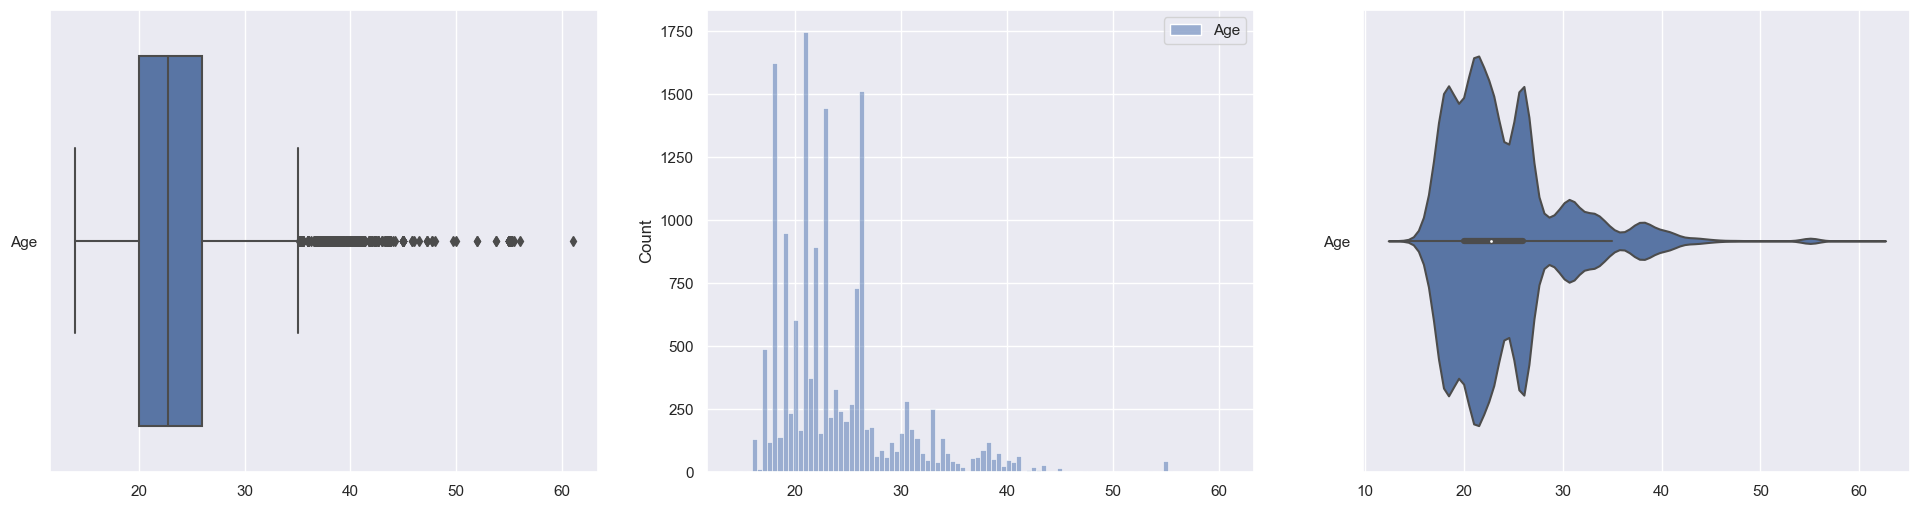

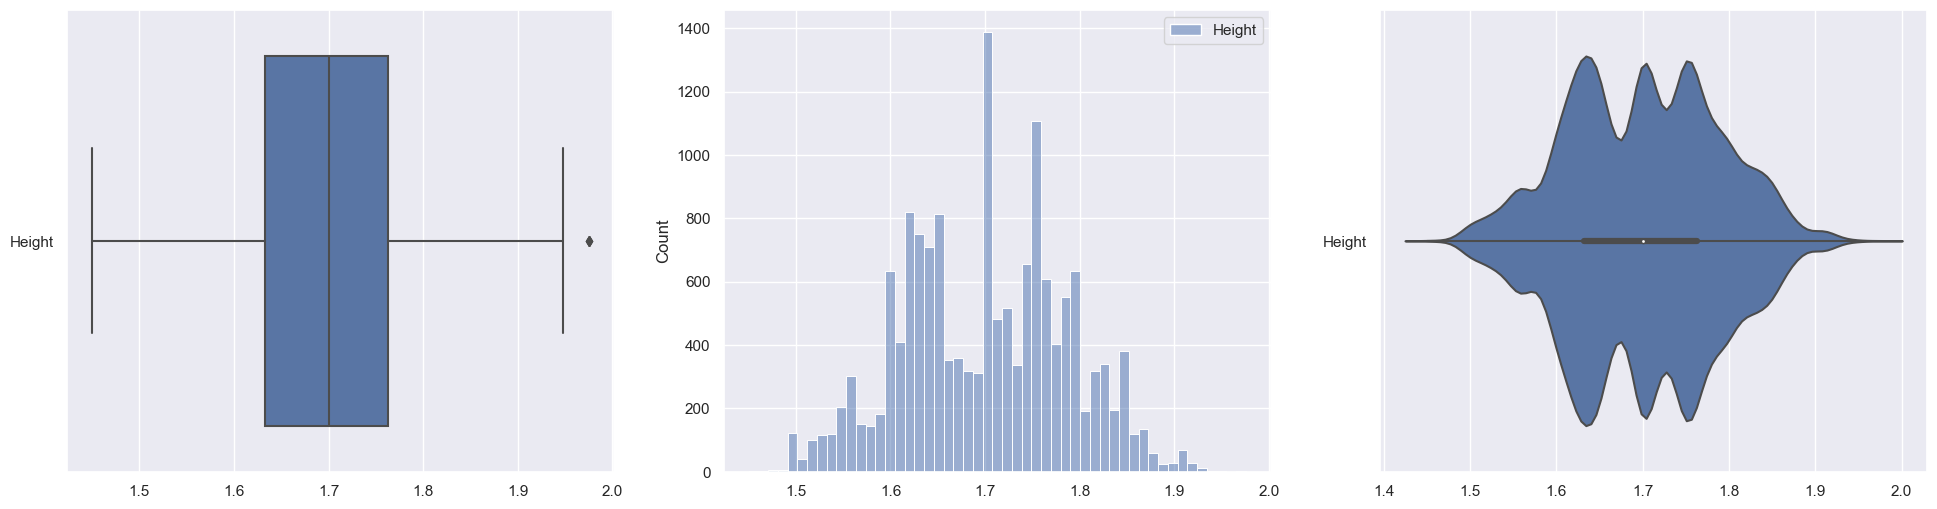

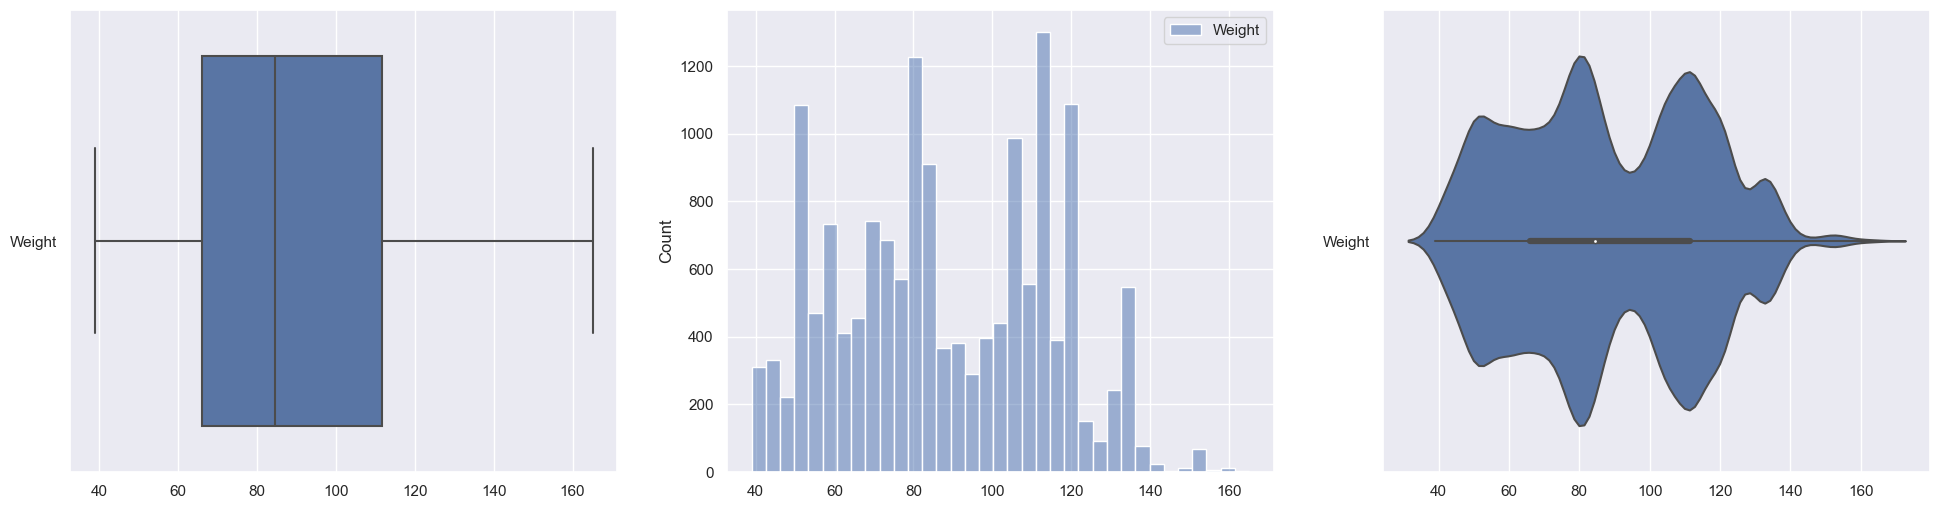

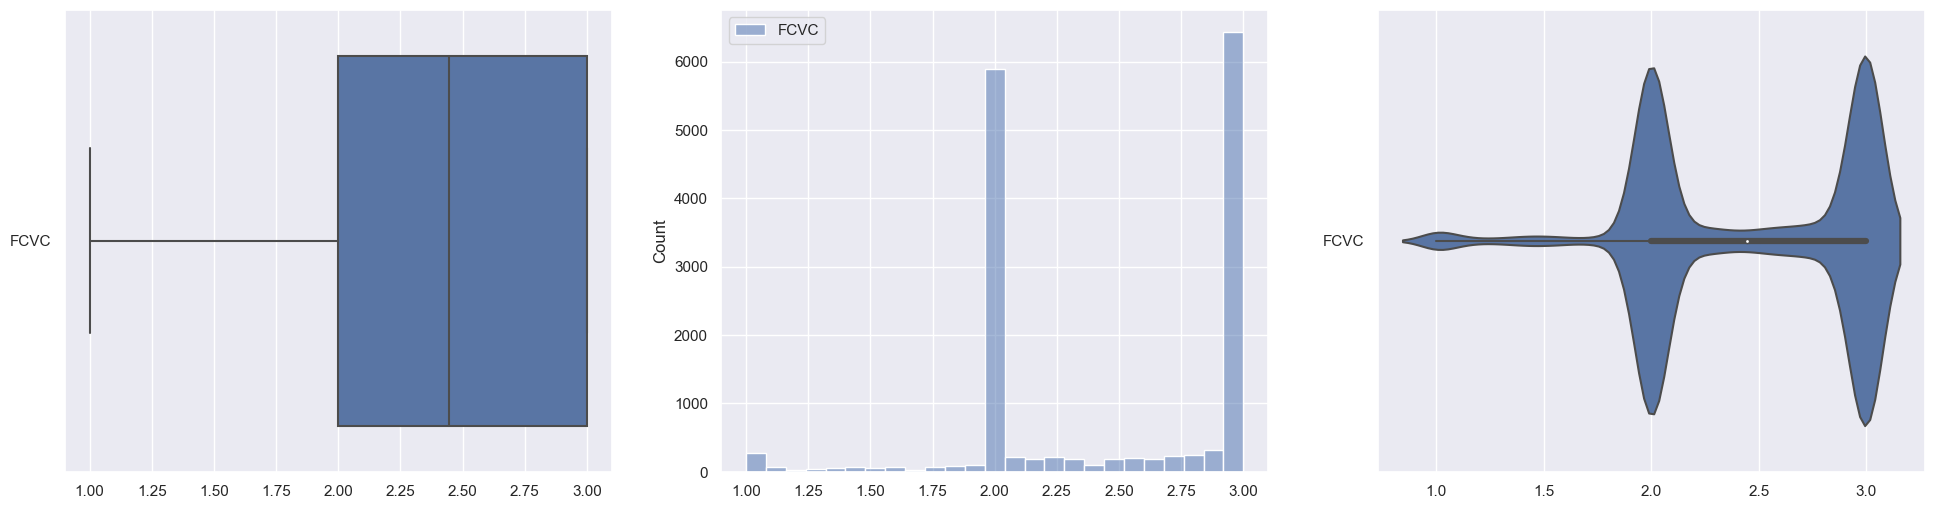

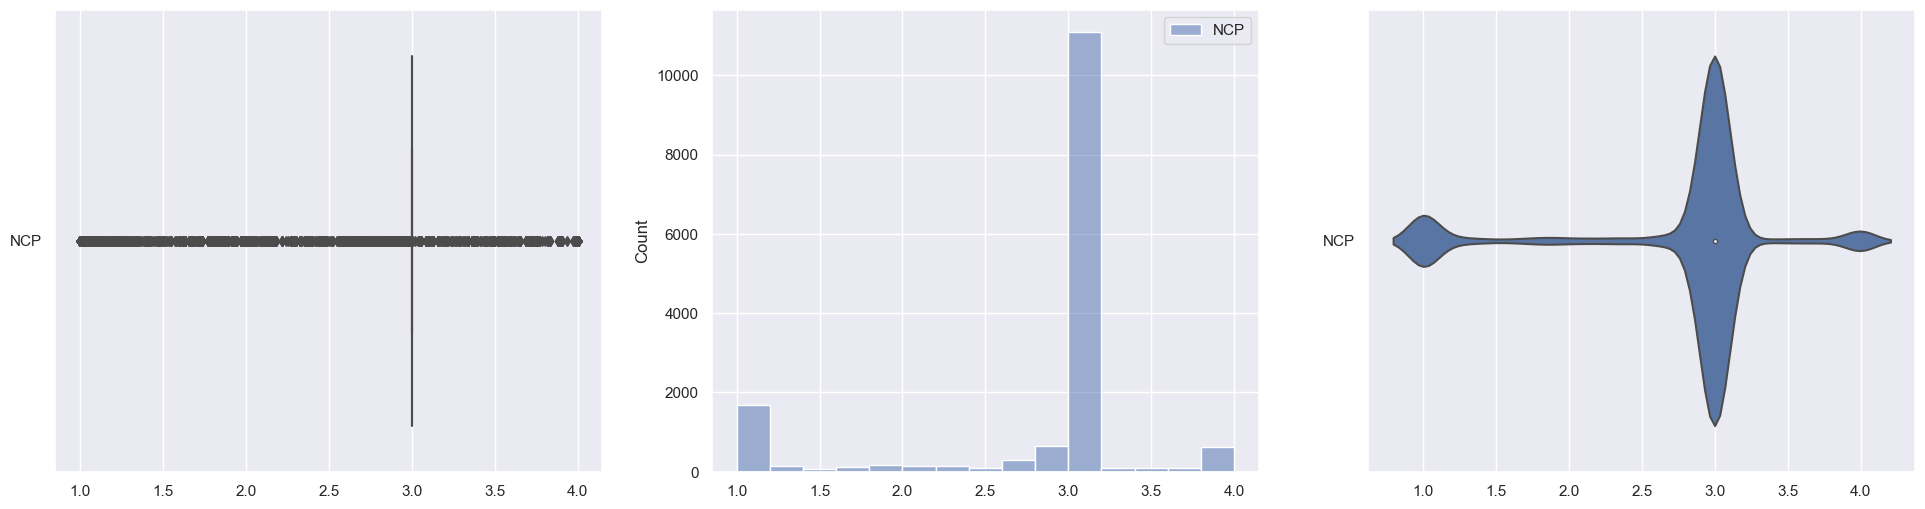

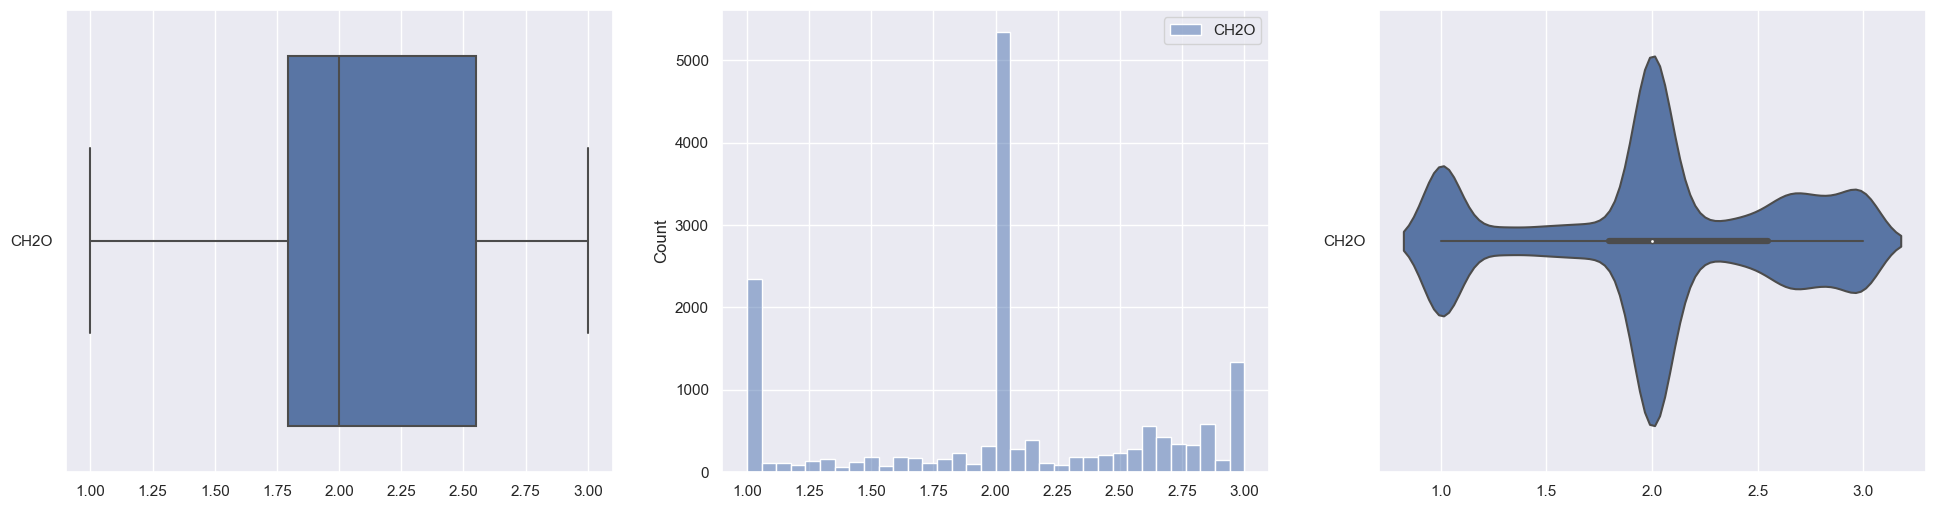

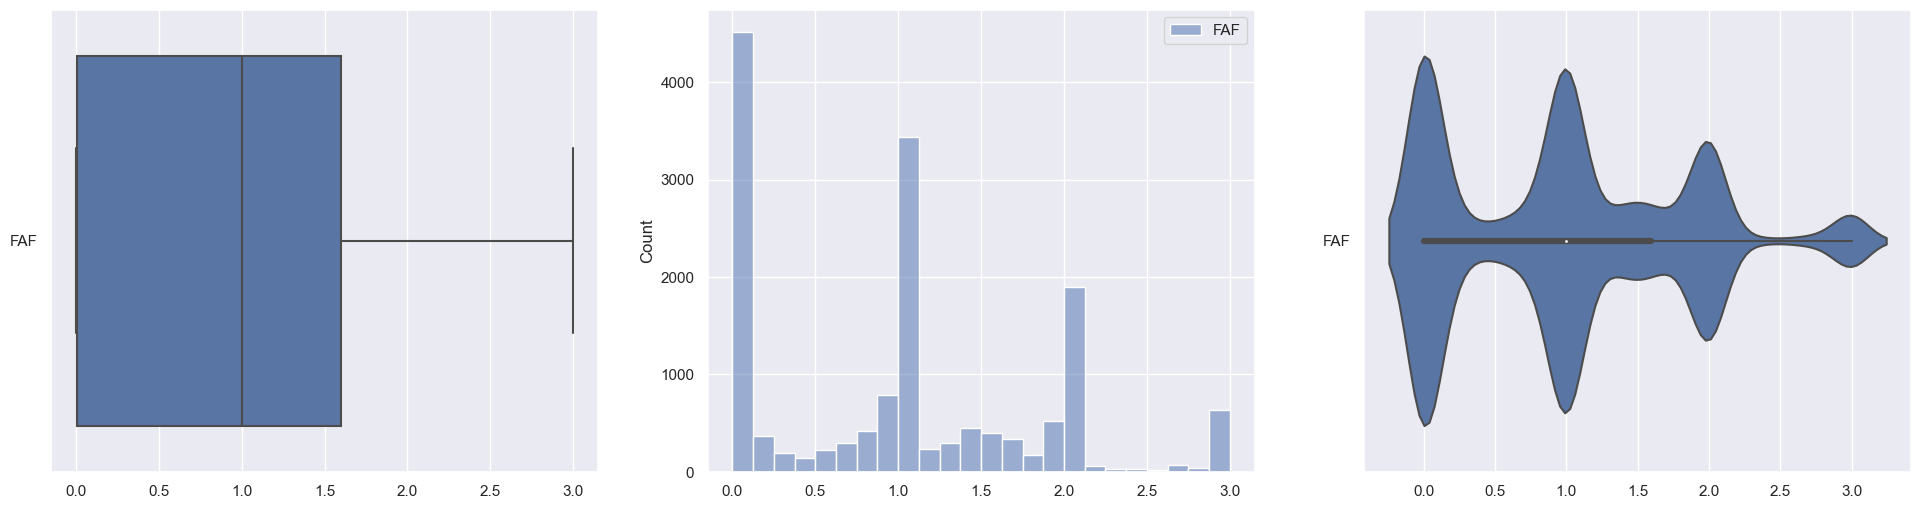

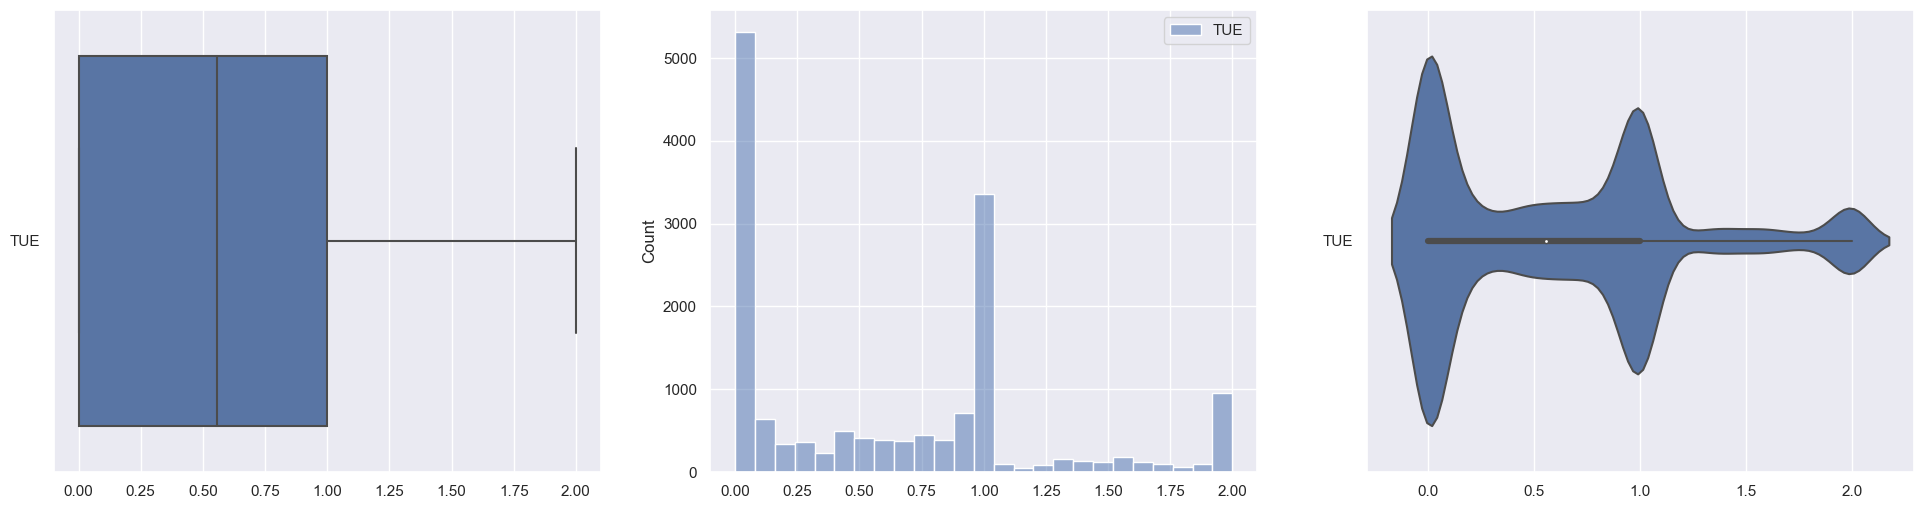

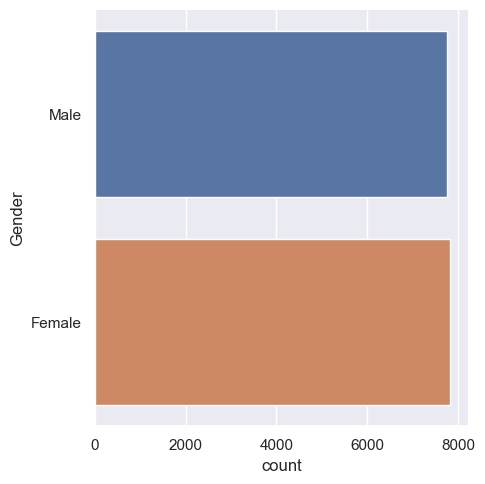

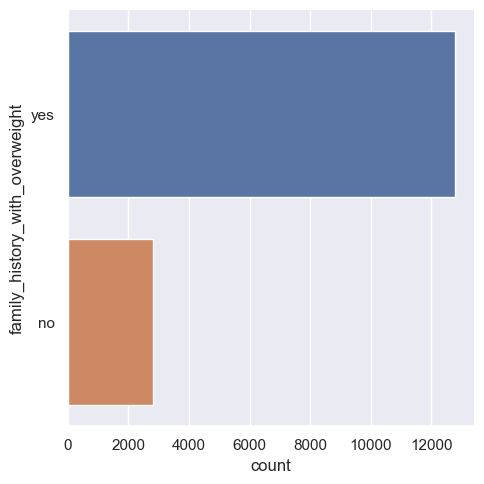

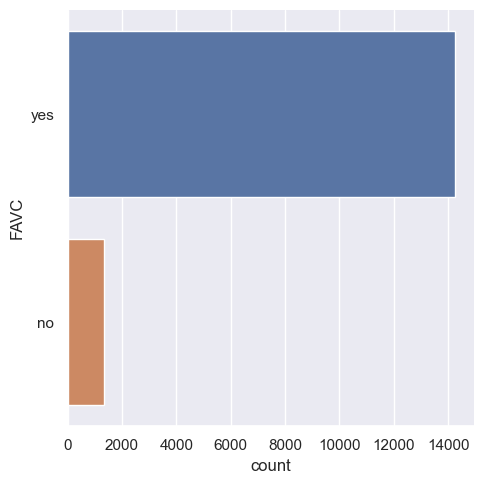

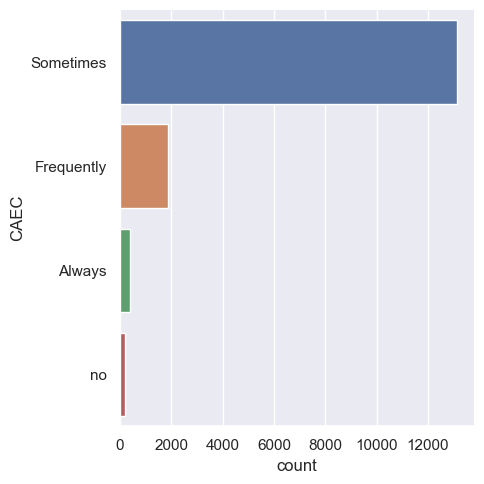

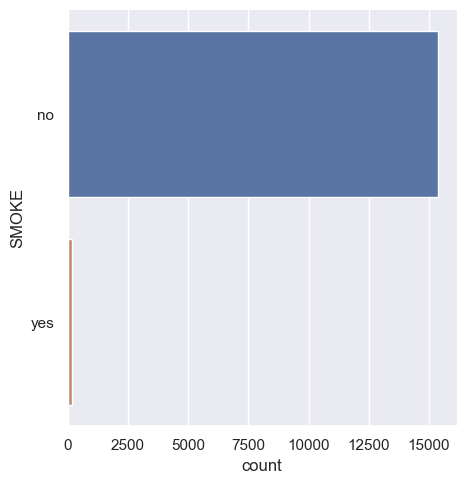

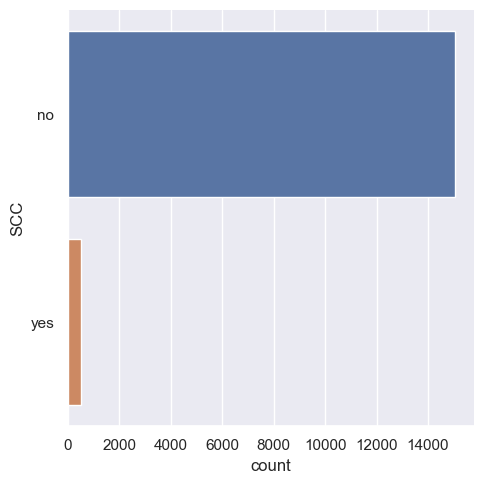

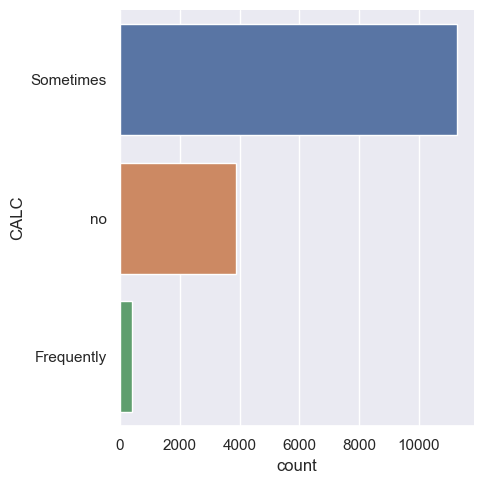

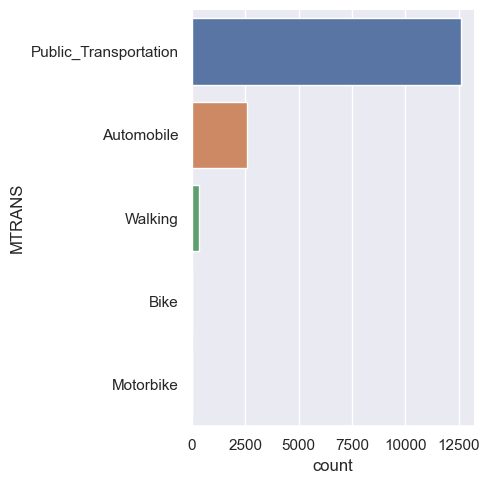

In [8]:
for t in single_trees:
    if t.x in num_var:
        t.x_diagram()
    else:
        t.x_diagram(numerical=False)

#### (4) Explore relations between each predictor and the target

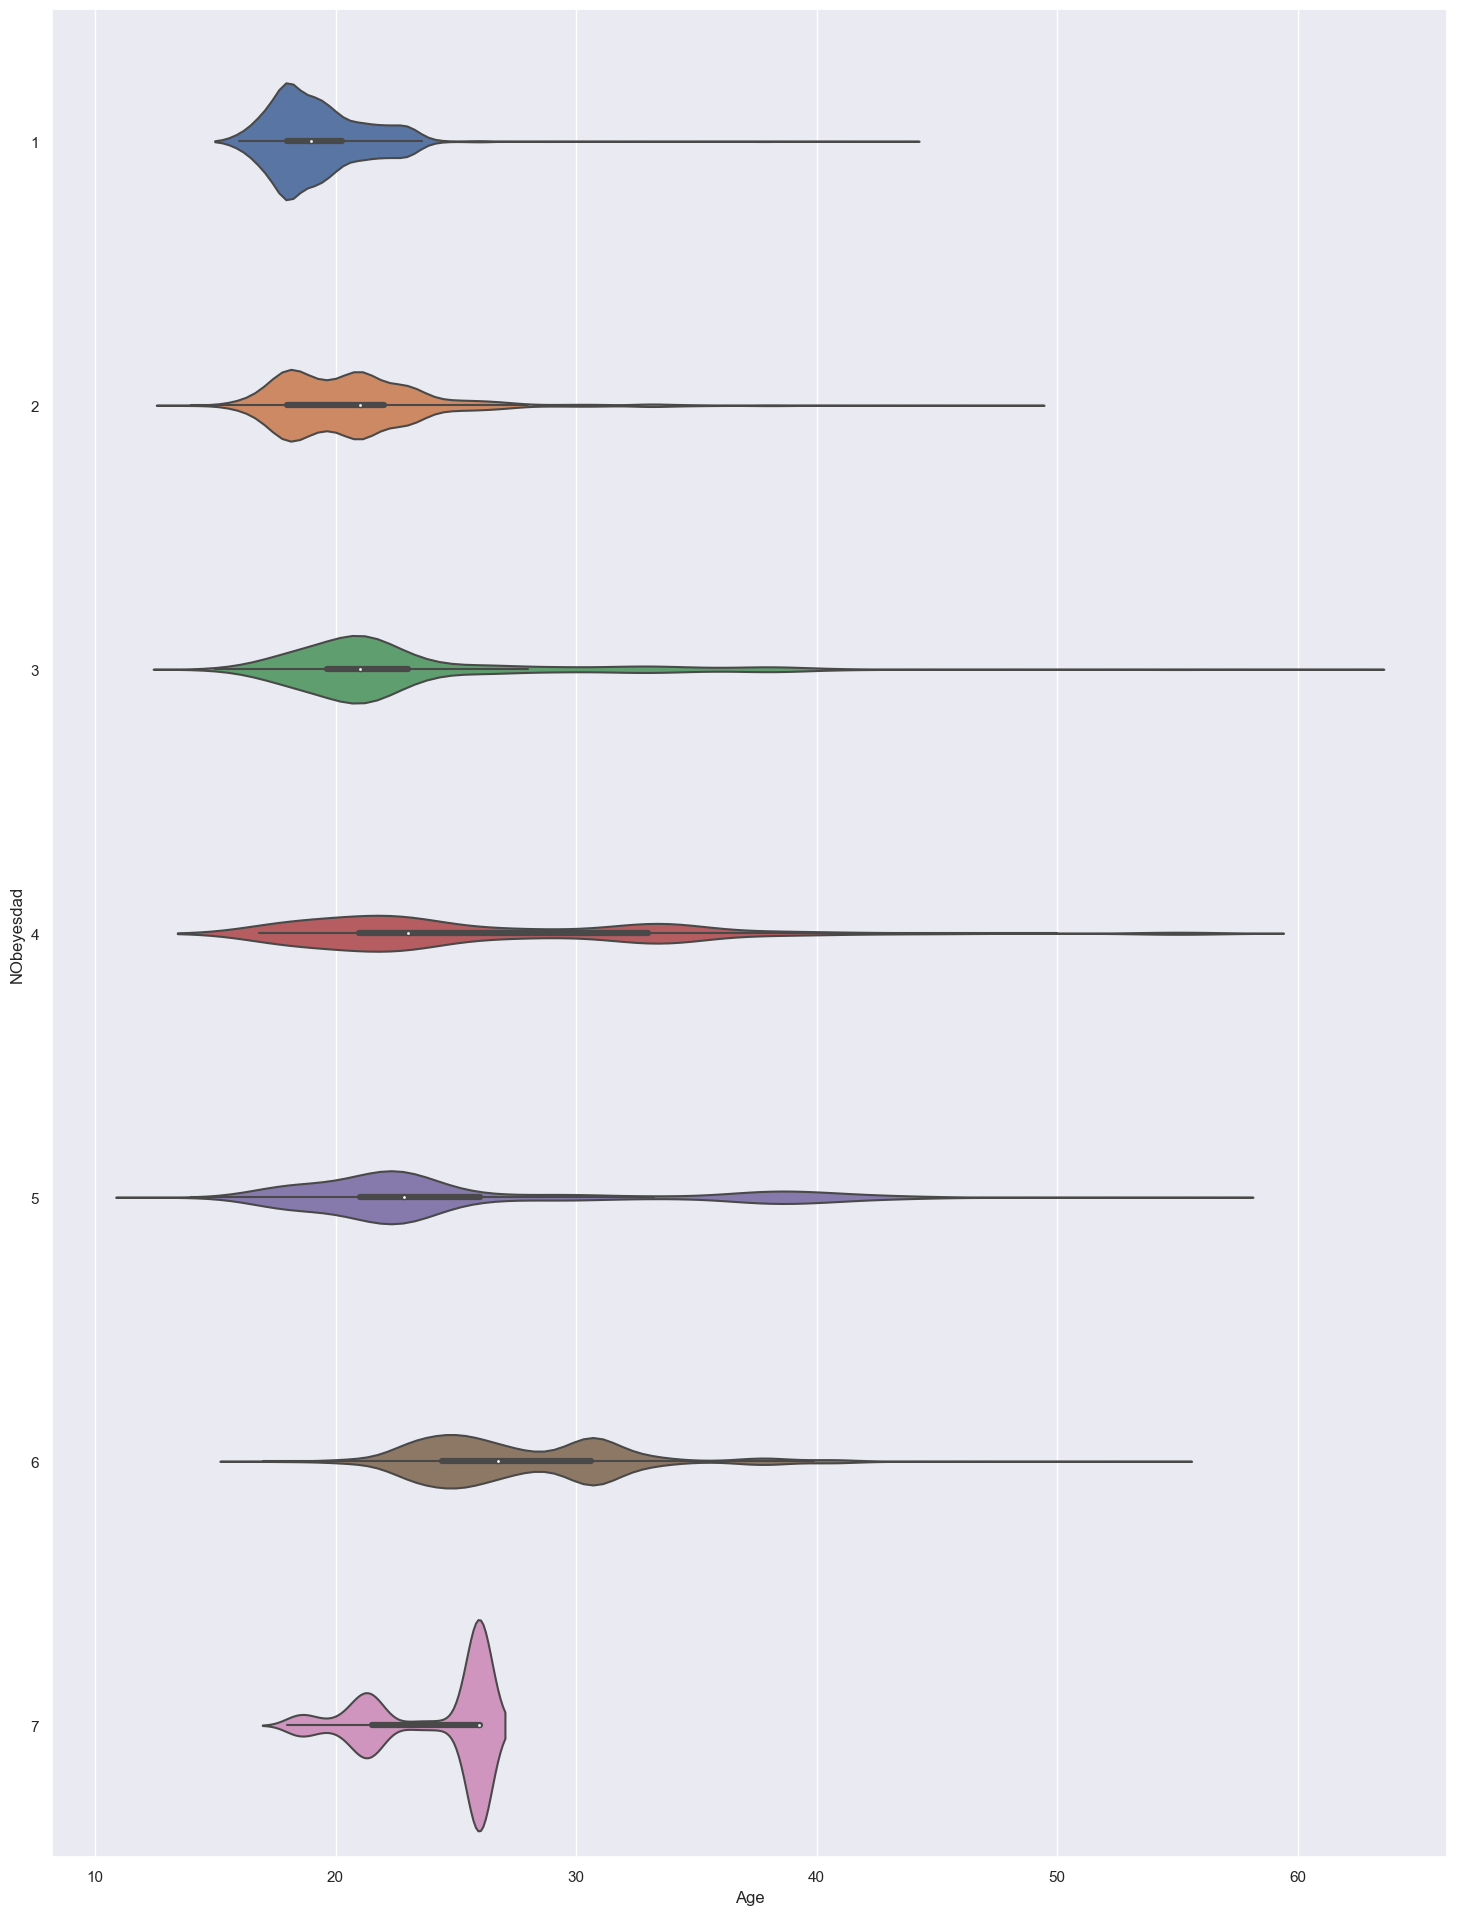

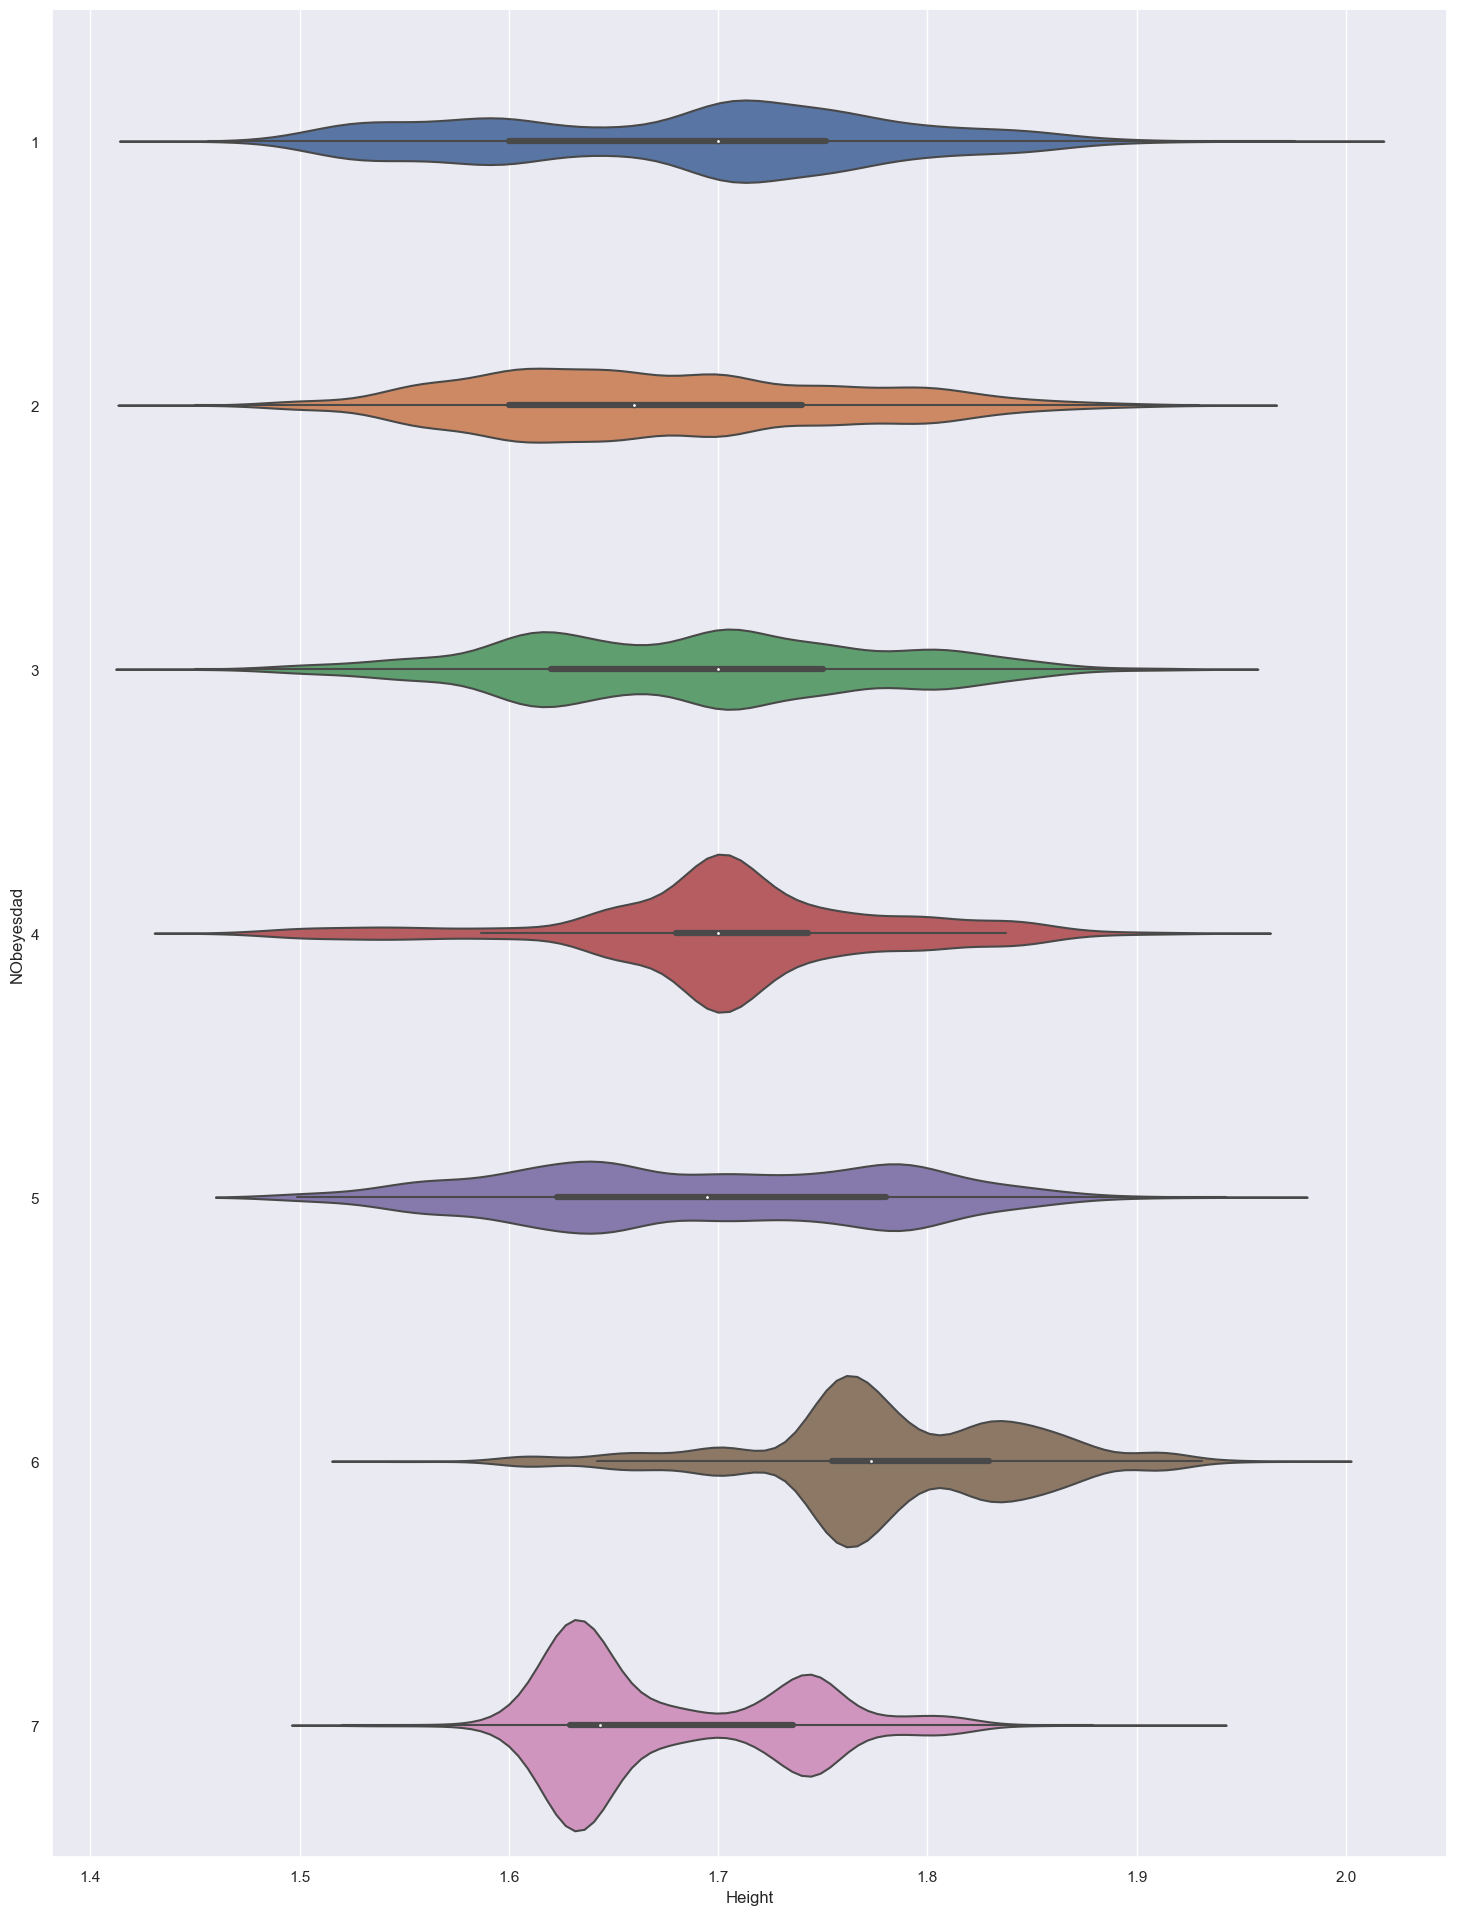

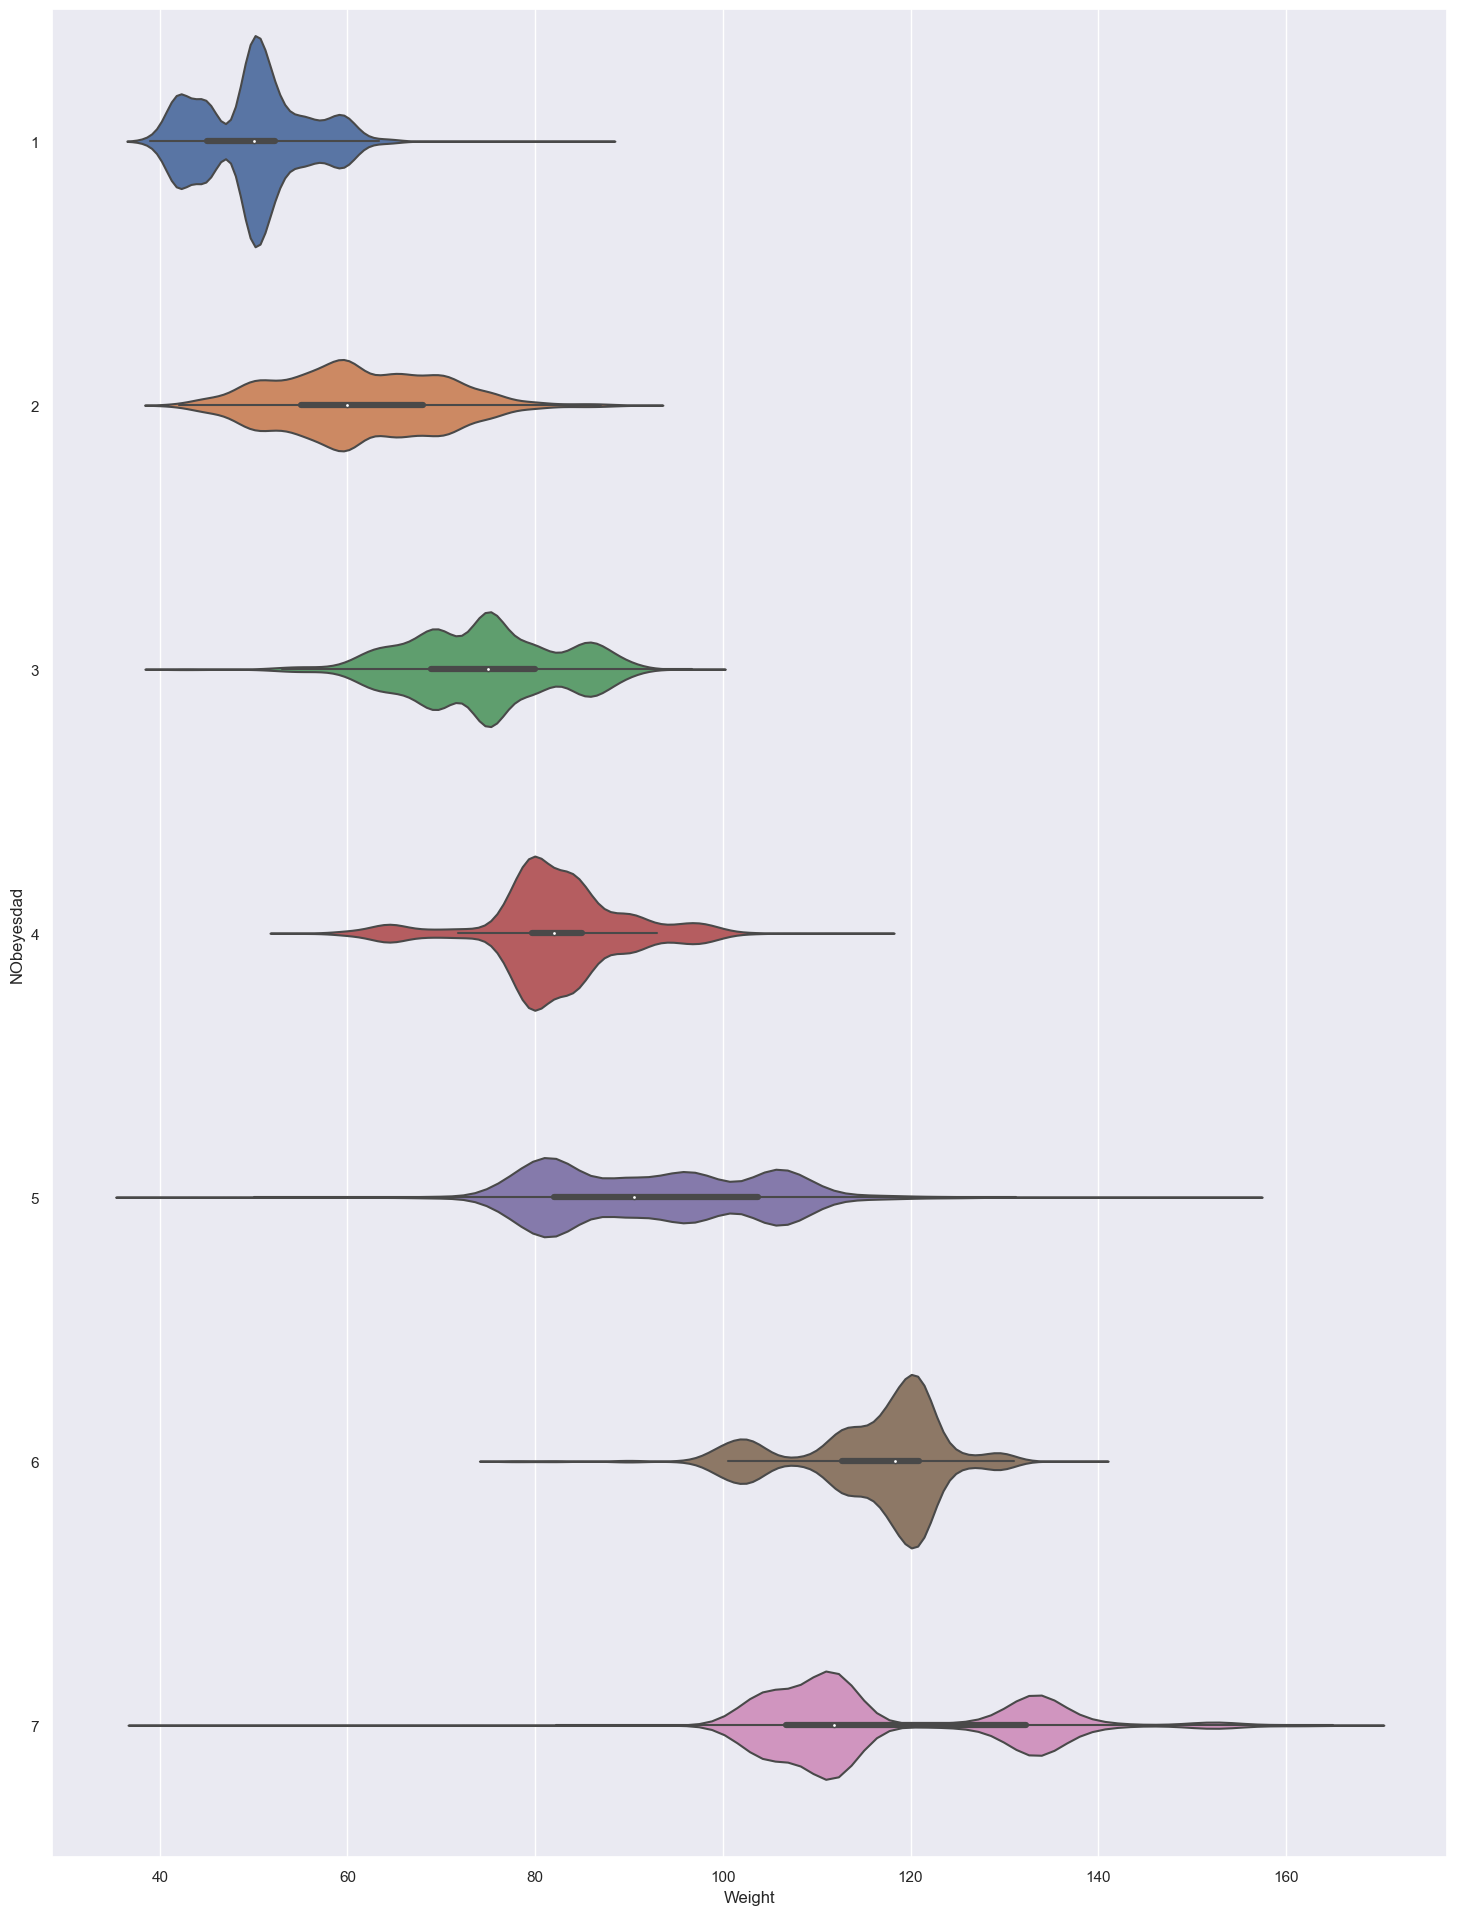

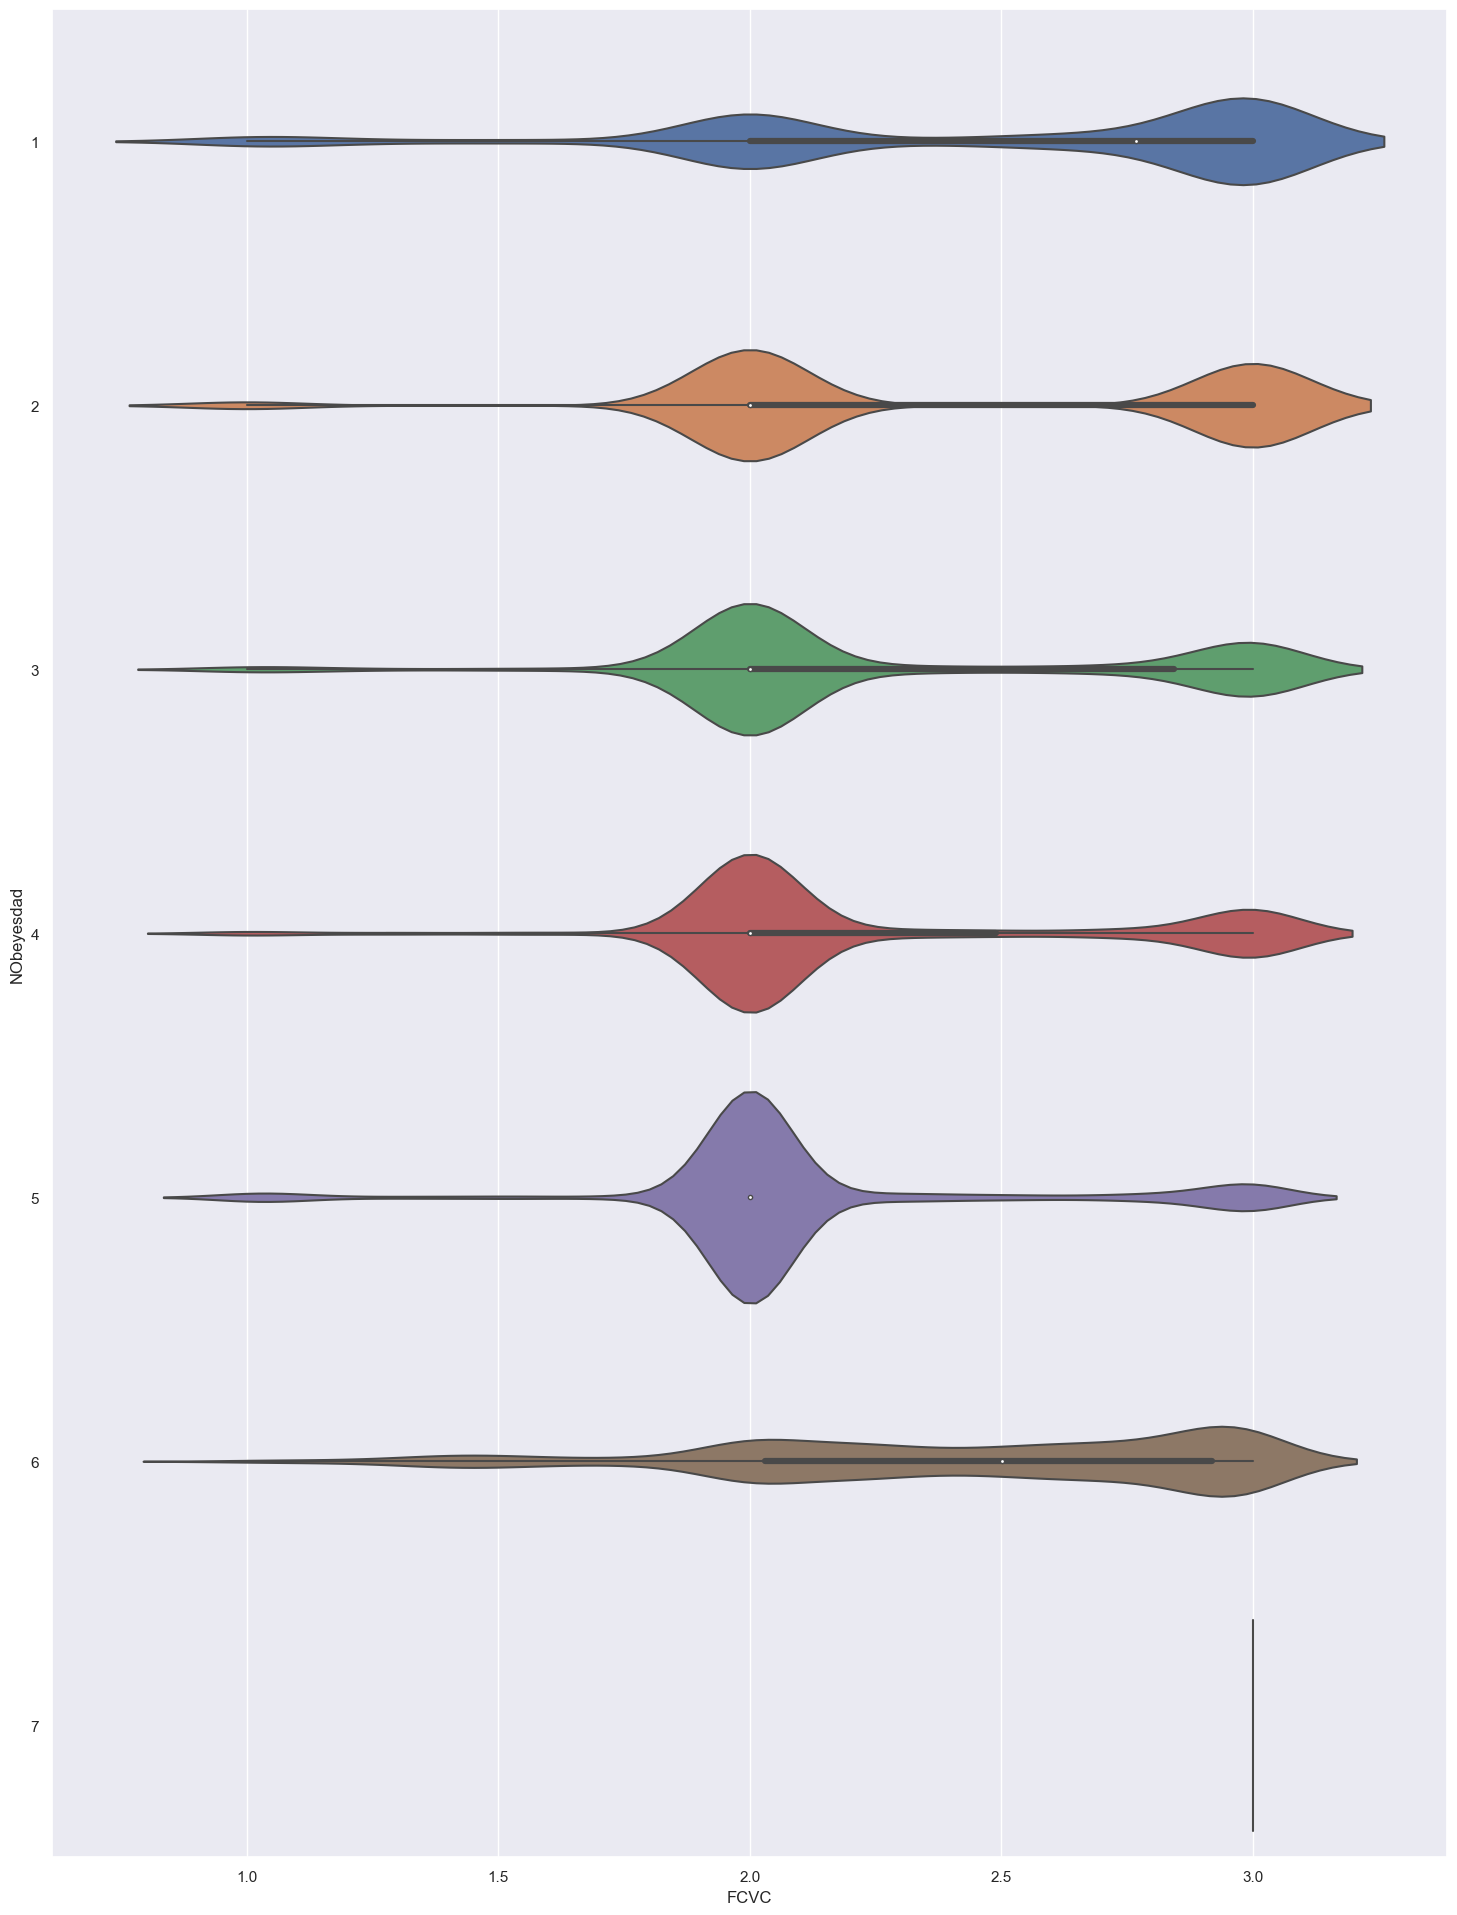

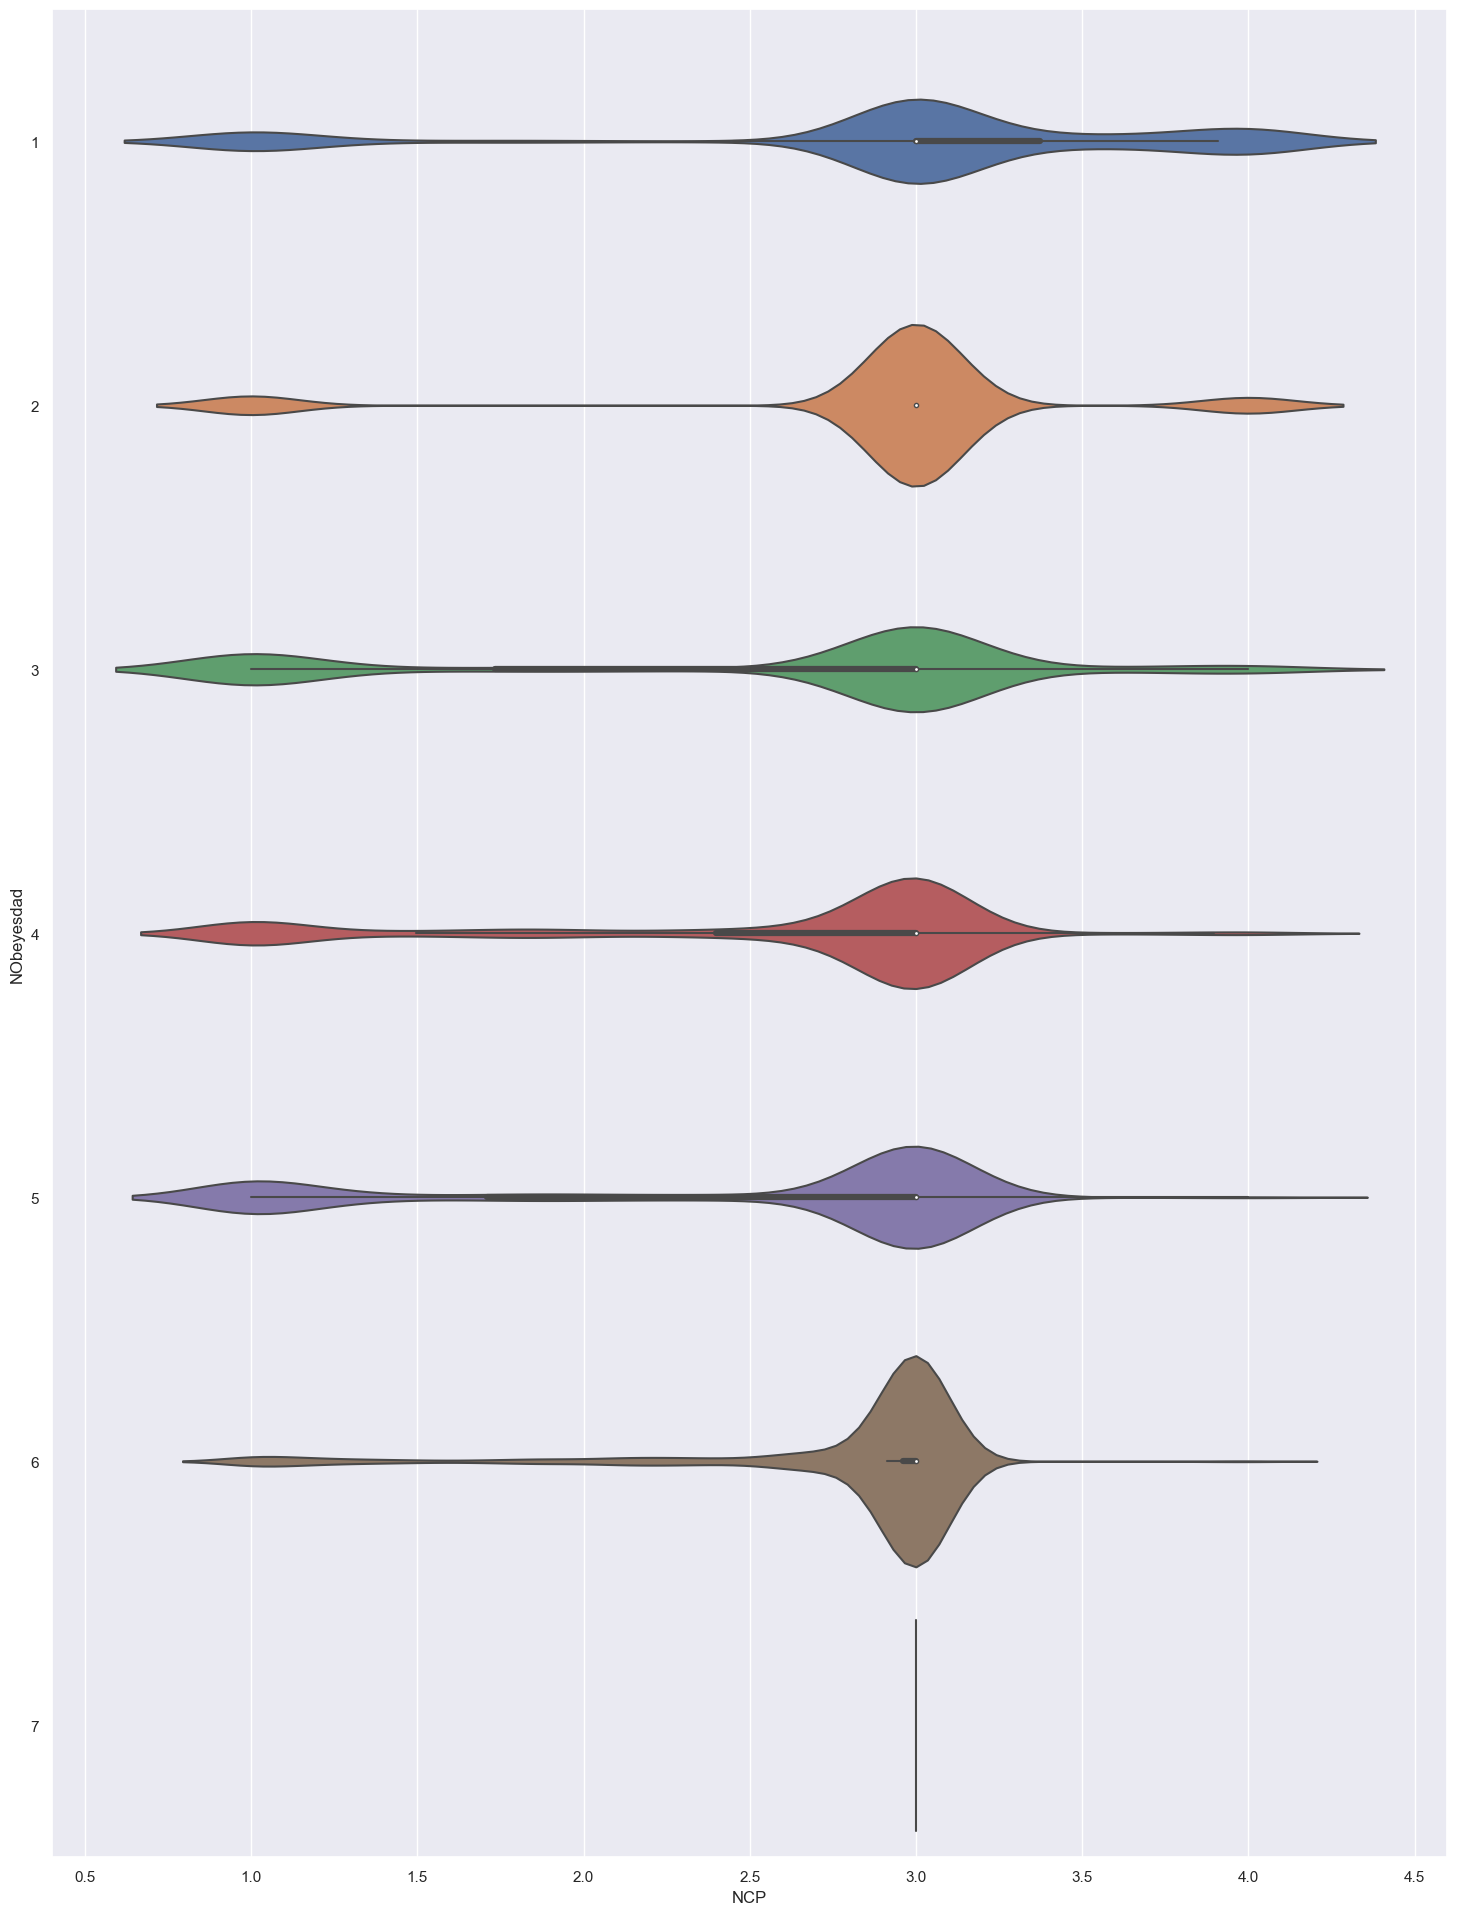

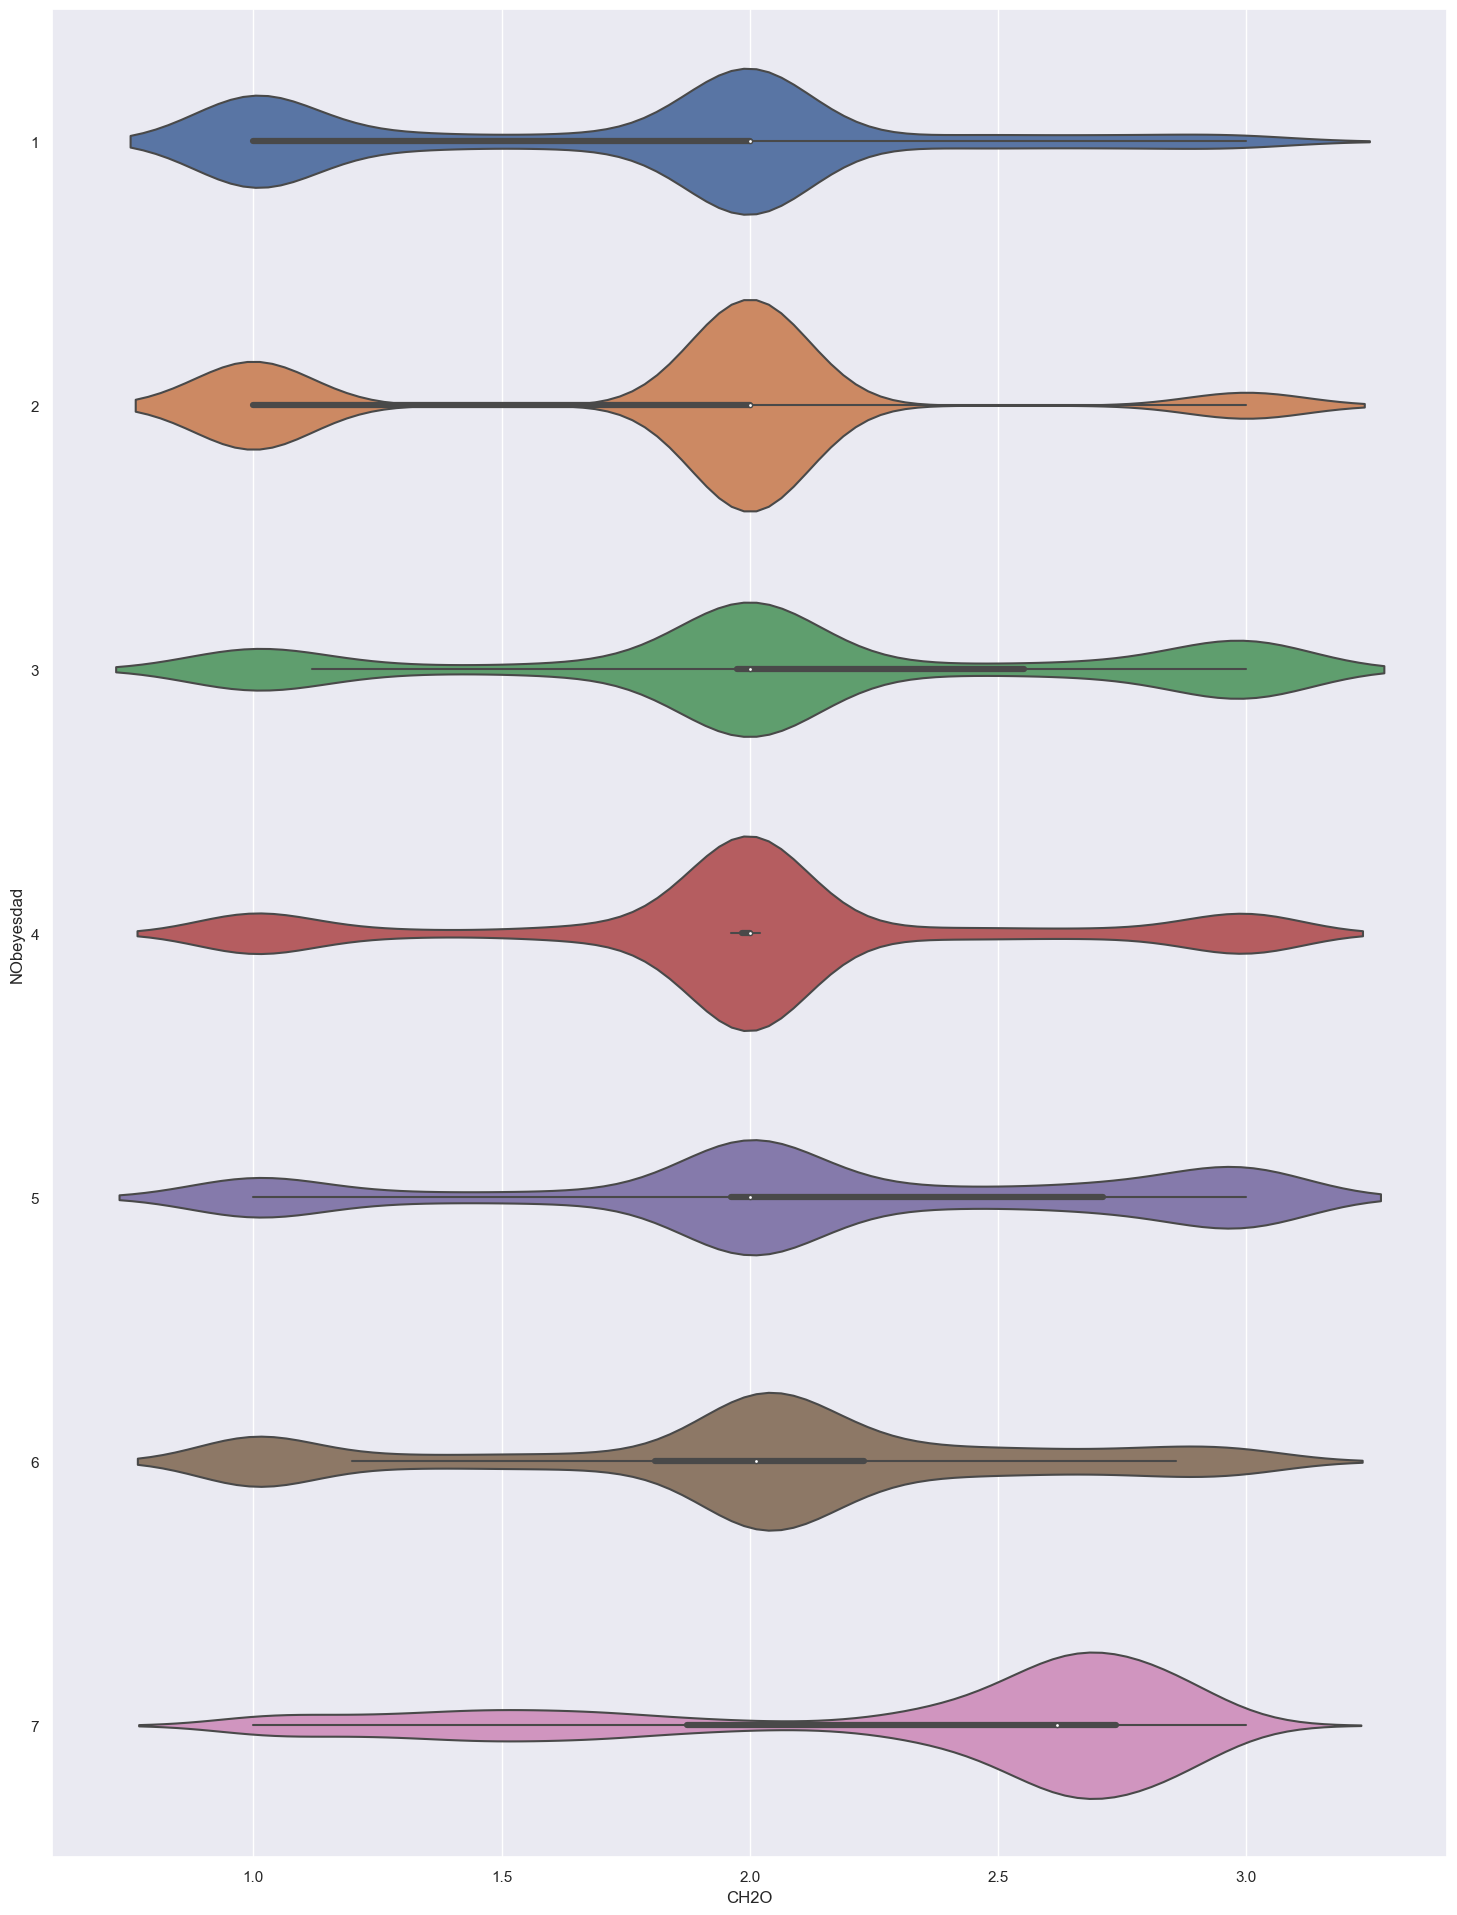

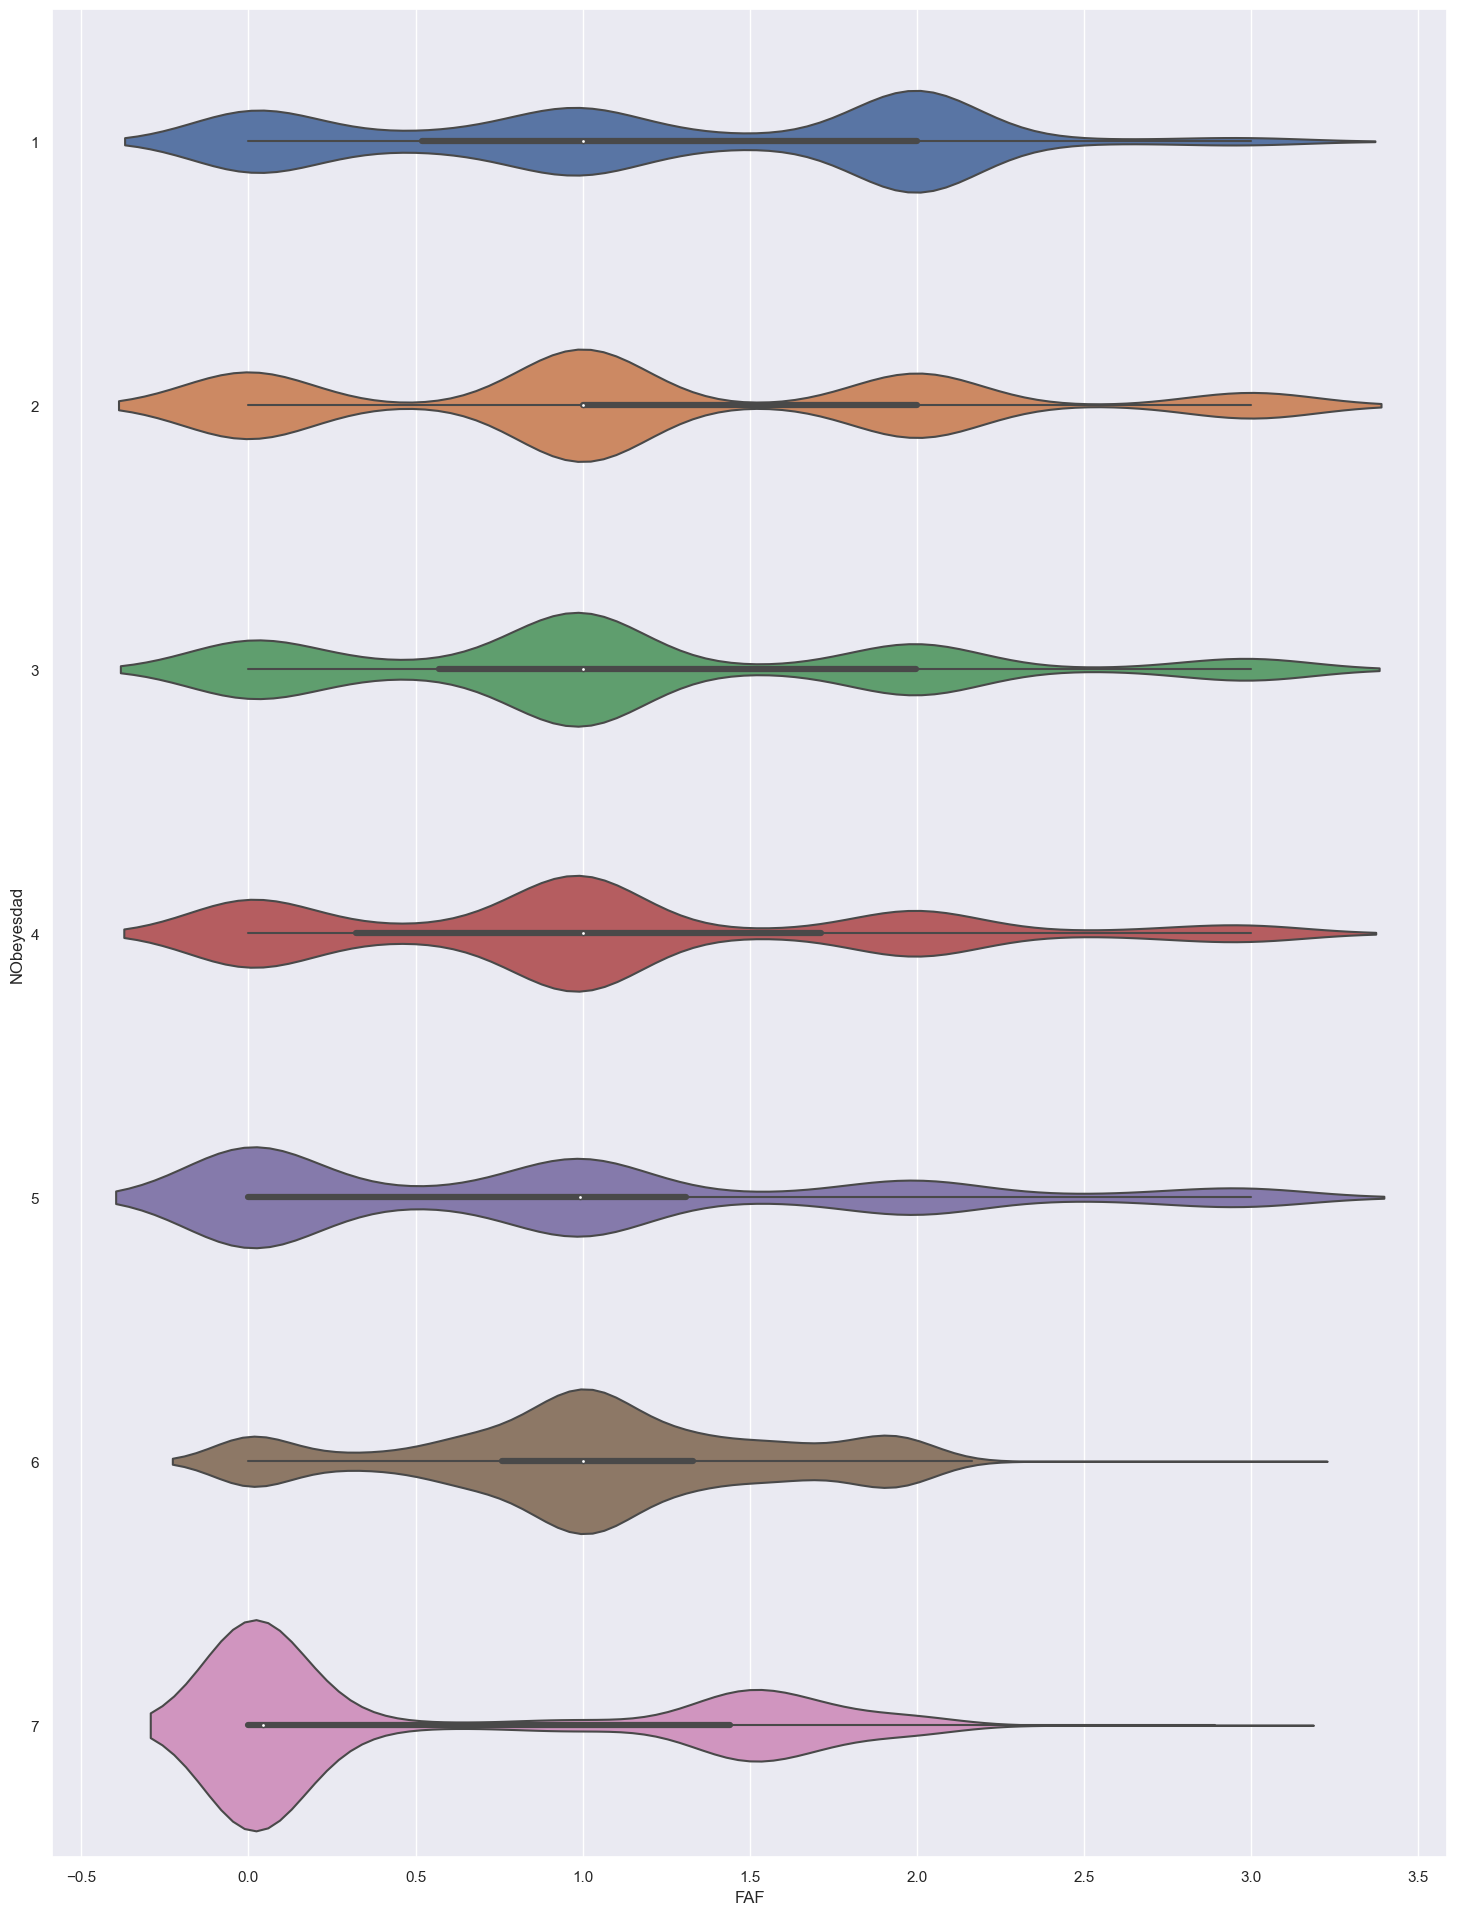

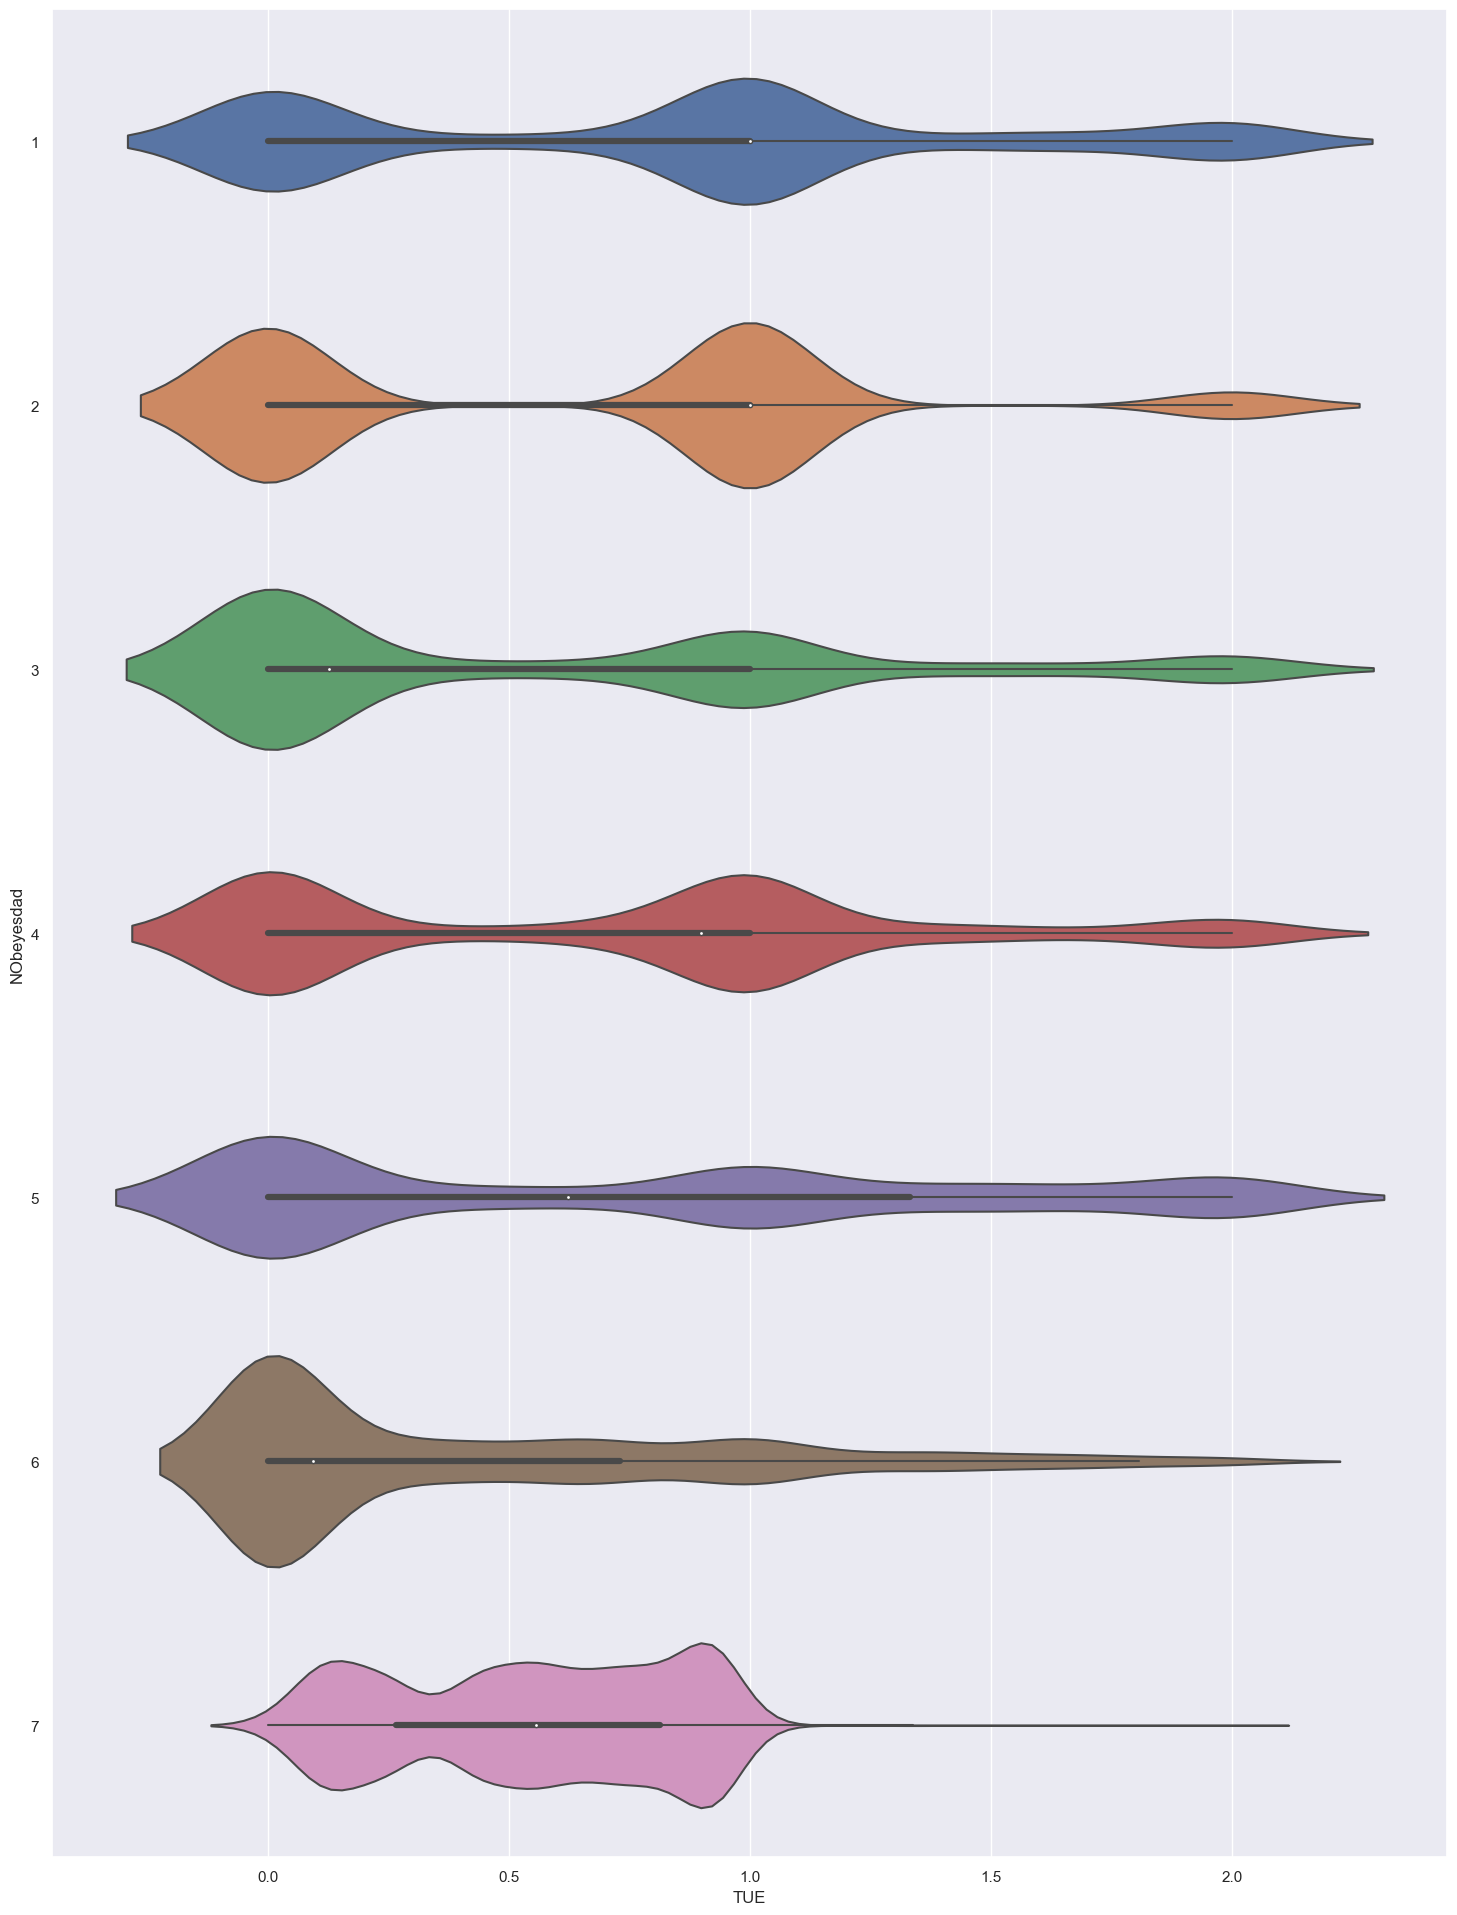

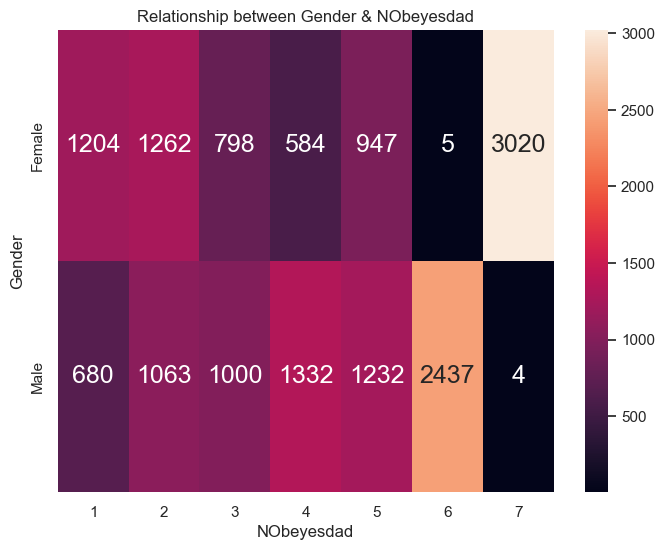

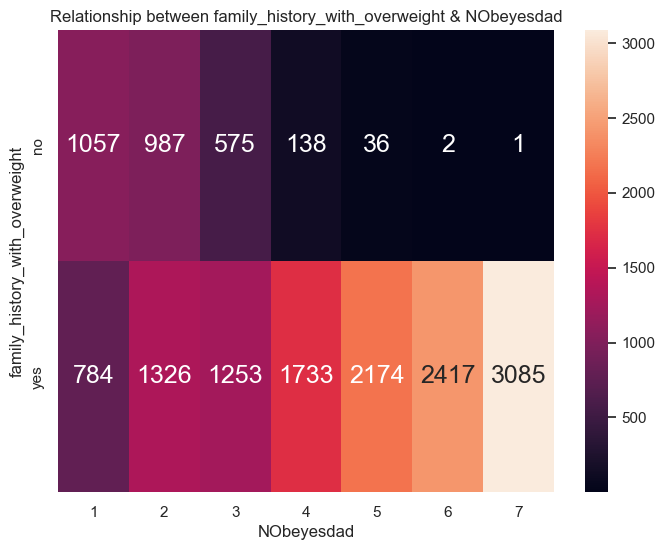

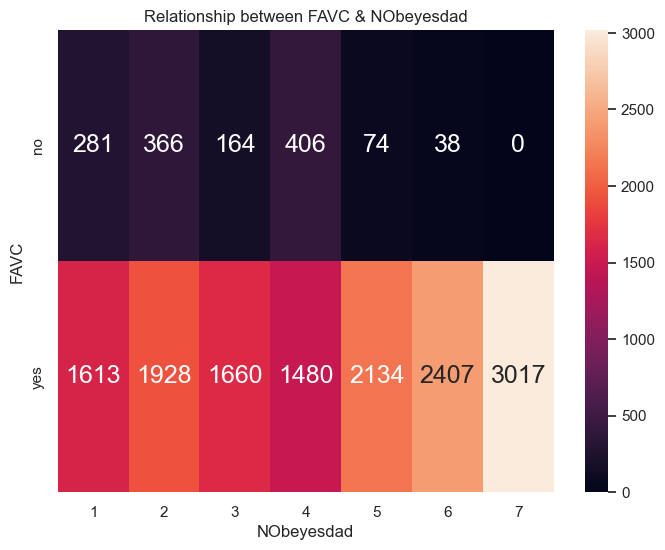

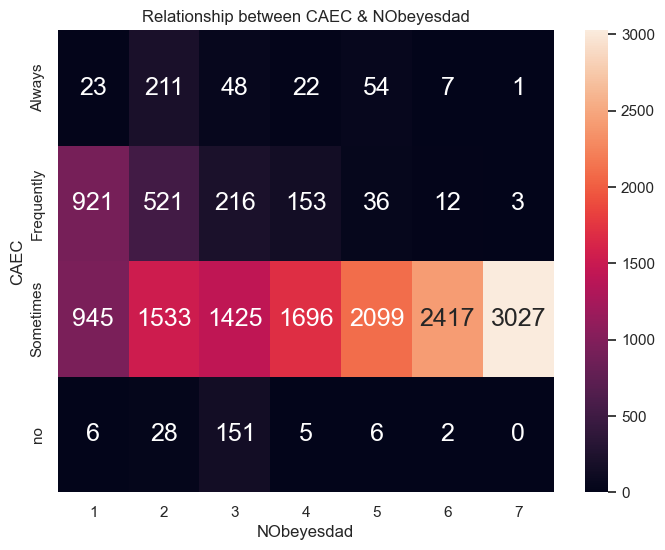

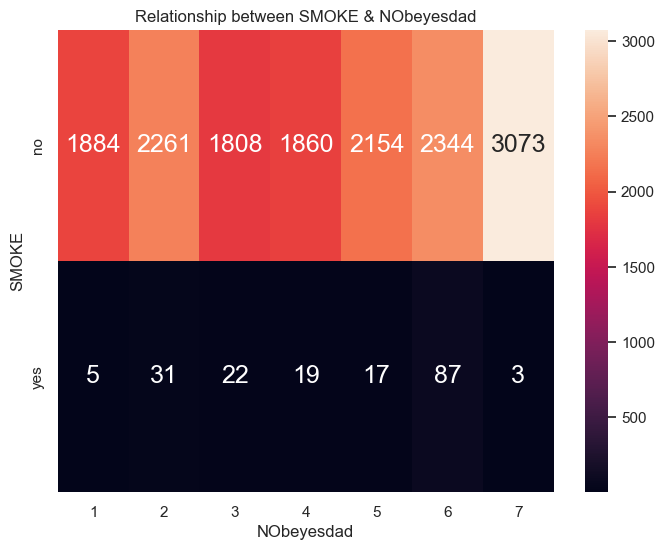

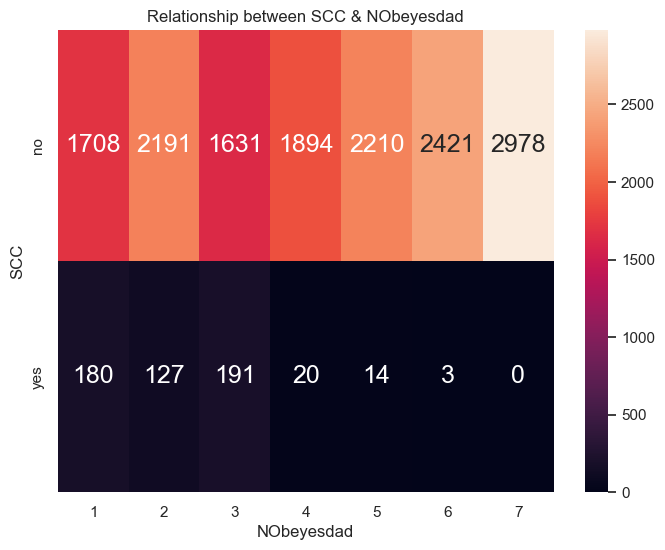

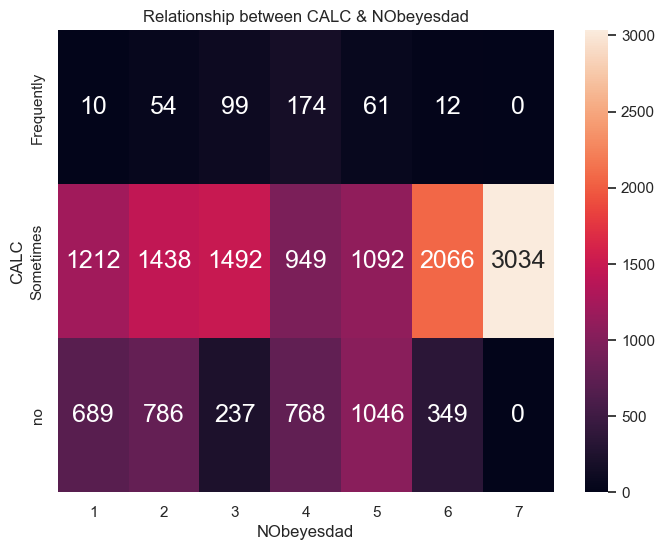

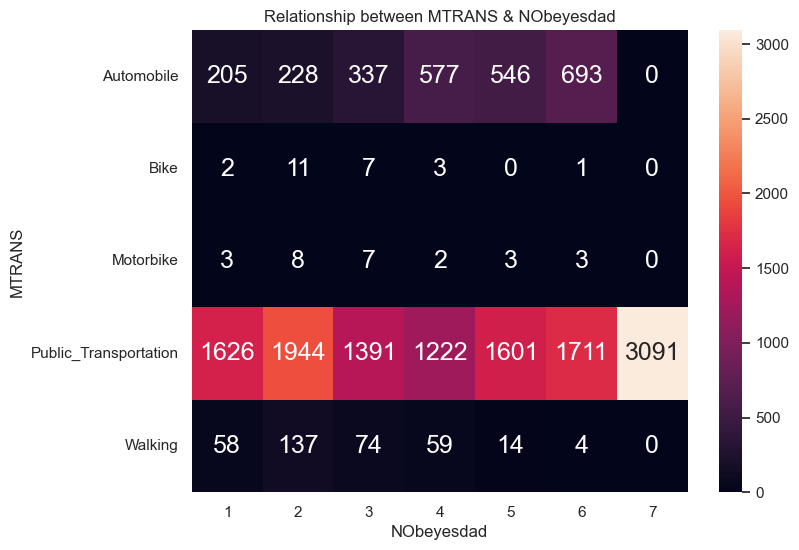

In [9]:
for t in single_trees:
    if t.x in num_var:
        t.xy_diagram(y_order)
    else:
        t.xy_diagram(order=y_order,numerical=False)


# 3.Single Decision Tree Based On Each Variable

#### (1) Encode all the categorical predictors to numerical

In [10]:
# Encode all categorical variables to numerical
oe = OrdinalEncoder()
data1[cat_var] = oe.fit_transform(data1[cat_var]) 

/var/folders/pv/33jv4nss6671k3jc2q_vh06w0000gn/T/ipykernel_17963/261890575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[cat_var] = oe.fit_transform(data1[cat_var])


#### (2) Create trees for each predictor

In [11]:
# Through experiments, depth=10 is the best for single decision trees

In [12]:
single_trees=[]
for x in all_var:
    t=Classification(data1,x,'NObeyesdad')
    t.apply_tree(max_depth=10)
    single_trees.append(t)

#### (3) Print goodness of models based on each predictor

In [13]:
print("Goodness of each model:")
for t in single_trees:
    t.print_goodness()

Goodness of each model:
'Age':
train:  56.3 %
test:  53.1 %

'Height':
train:  53.1 %
test:  50.9 %

'Weight':
train:  77.6 %
test:  76.6 %

'FCVC':
train:  44.5 %
test:  43.6 %

'NCP':
train:  32.0 %
test:  30.9 %

'CH2O':
train:  44.5 %
test:  42.1 %

'FAF':
train:  43.5 %
test:  40.7 %

'TUE':
train:  40.8 %
test:  40.4 %

'Gender':
train:  35.4 %
test:  34.2 %

'family_history_with_overweight':
train:  26.4 %
test:  26.7 %

'FAVC':
train:  22.0 %
test:  22.2 %

'CAEC':
train:  27.8 %
test:  27.5 %

'SMOKE':
train:  20.1 %
test:  19.9 %

'SCC':
train:  20.7 %
test:  20.8 %

'CALC':
train:  27.6 %
test:  26.4 %

'MTRANS':
train:  25.1 %
test:  24.8 %



#### (3) Draw confusion matrices for each model

Confusion_matrices of each model:
'Age' - train & test:


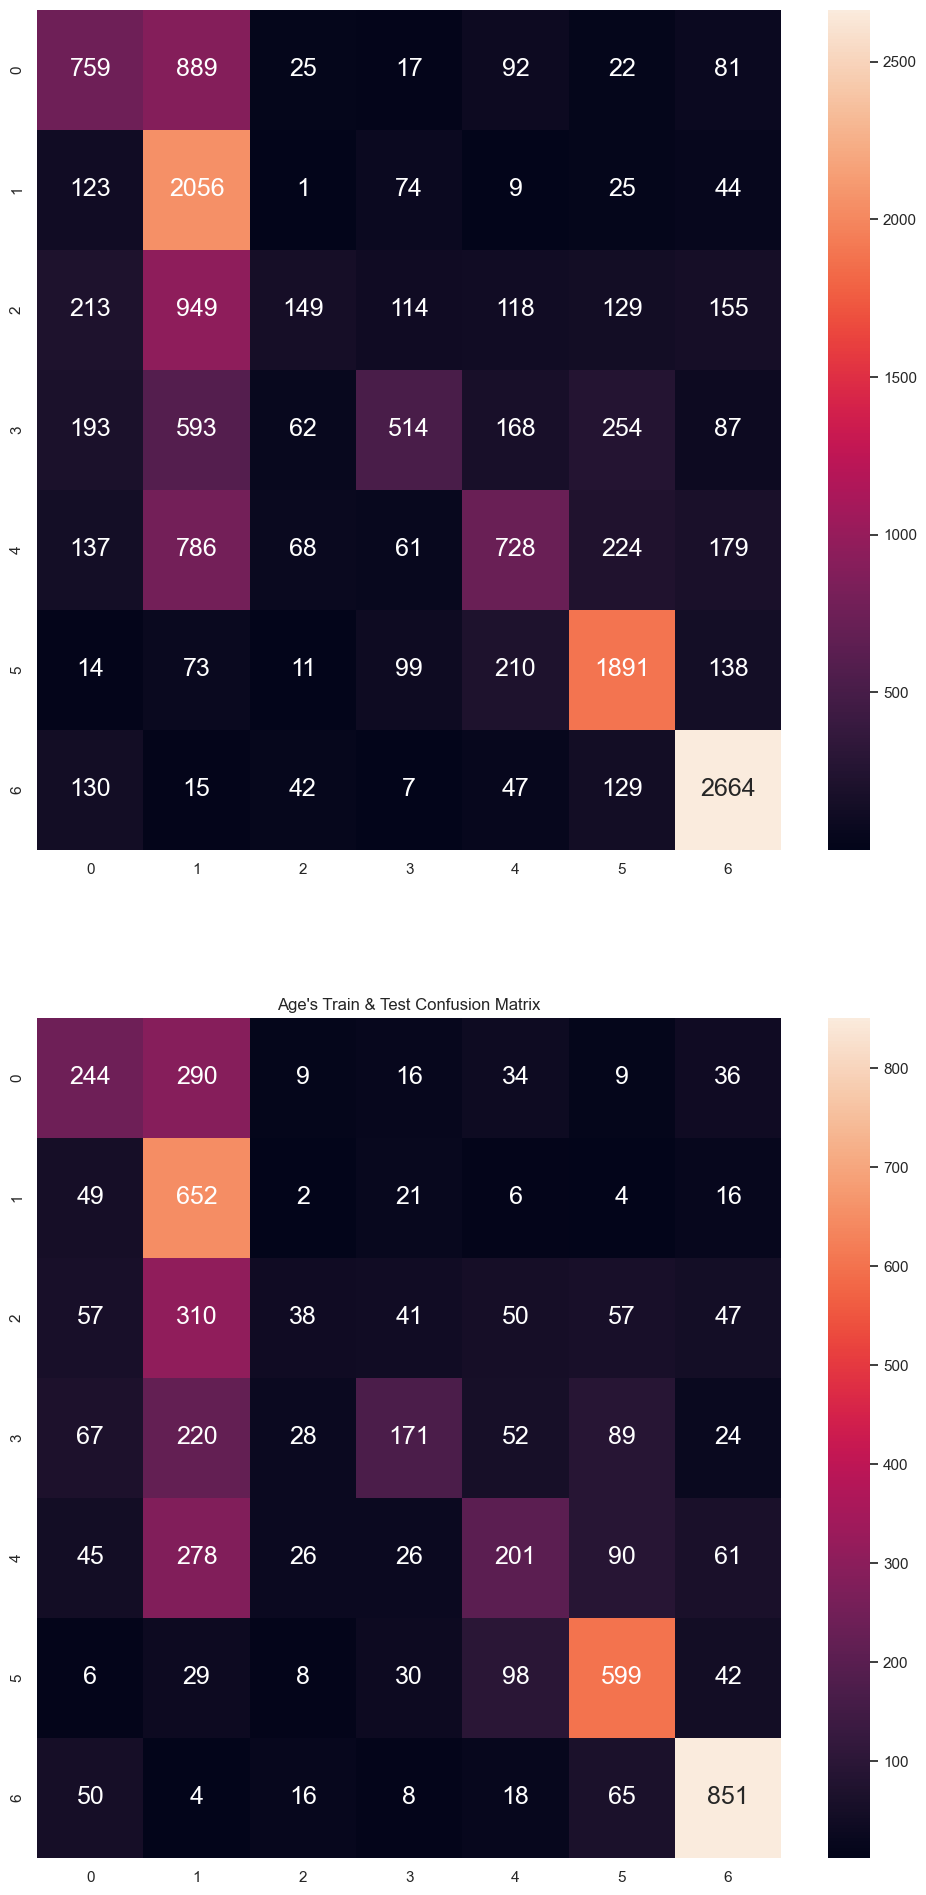

'Height' - train & test:


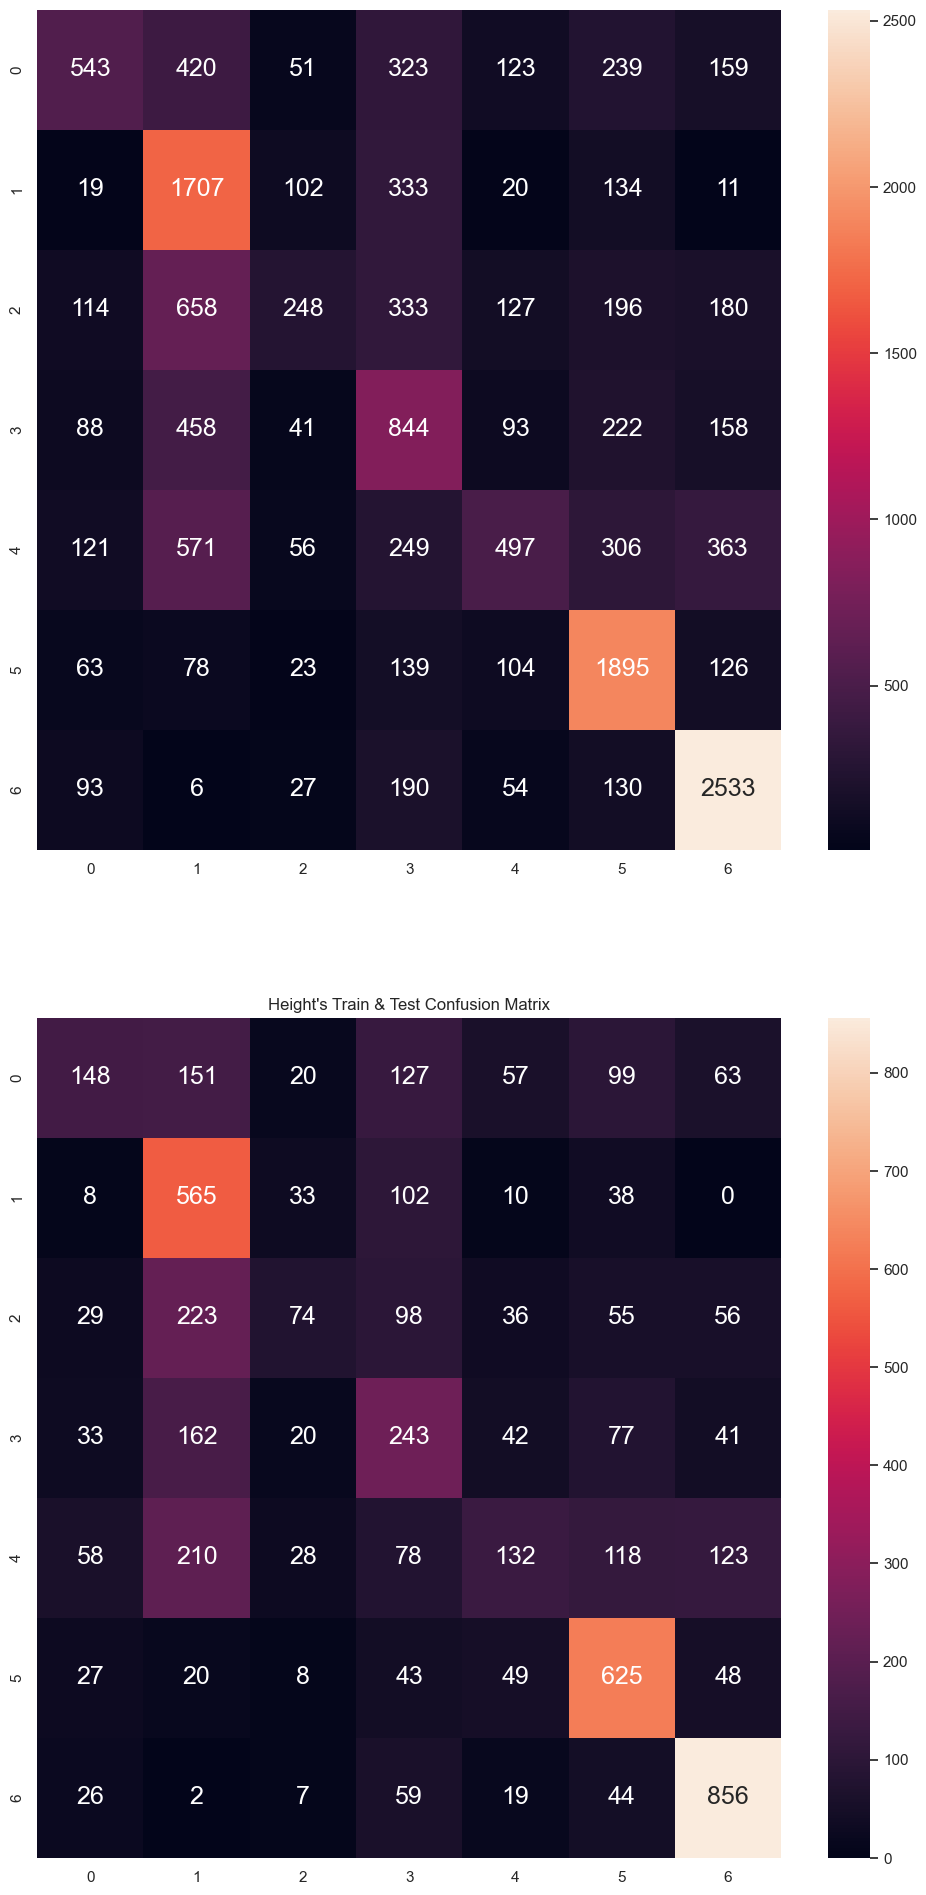

'Weight' - train & test:


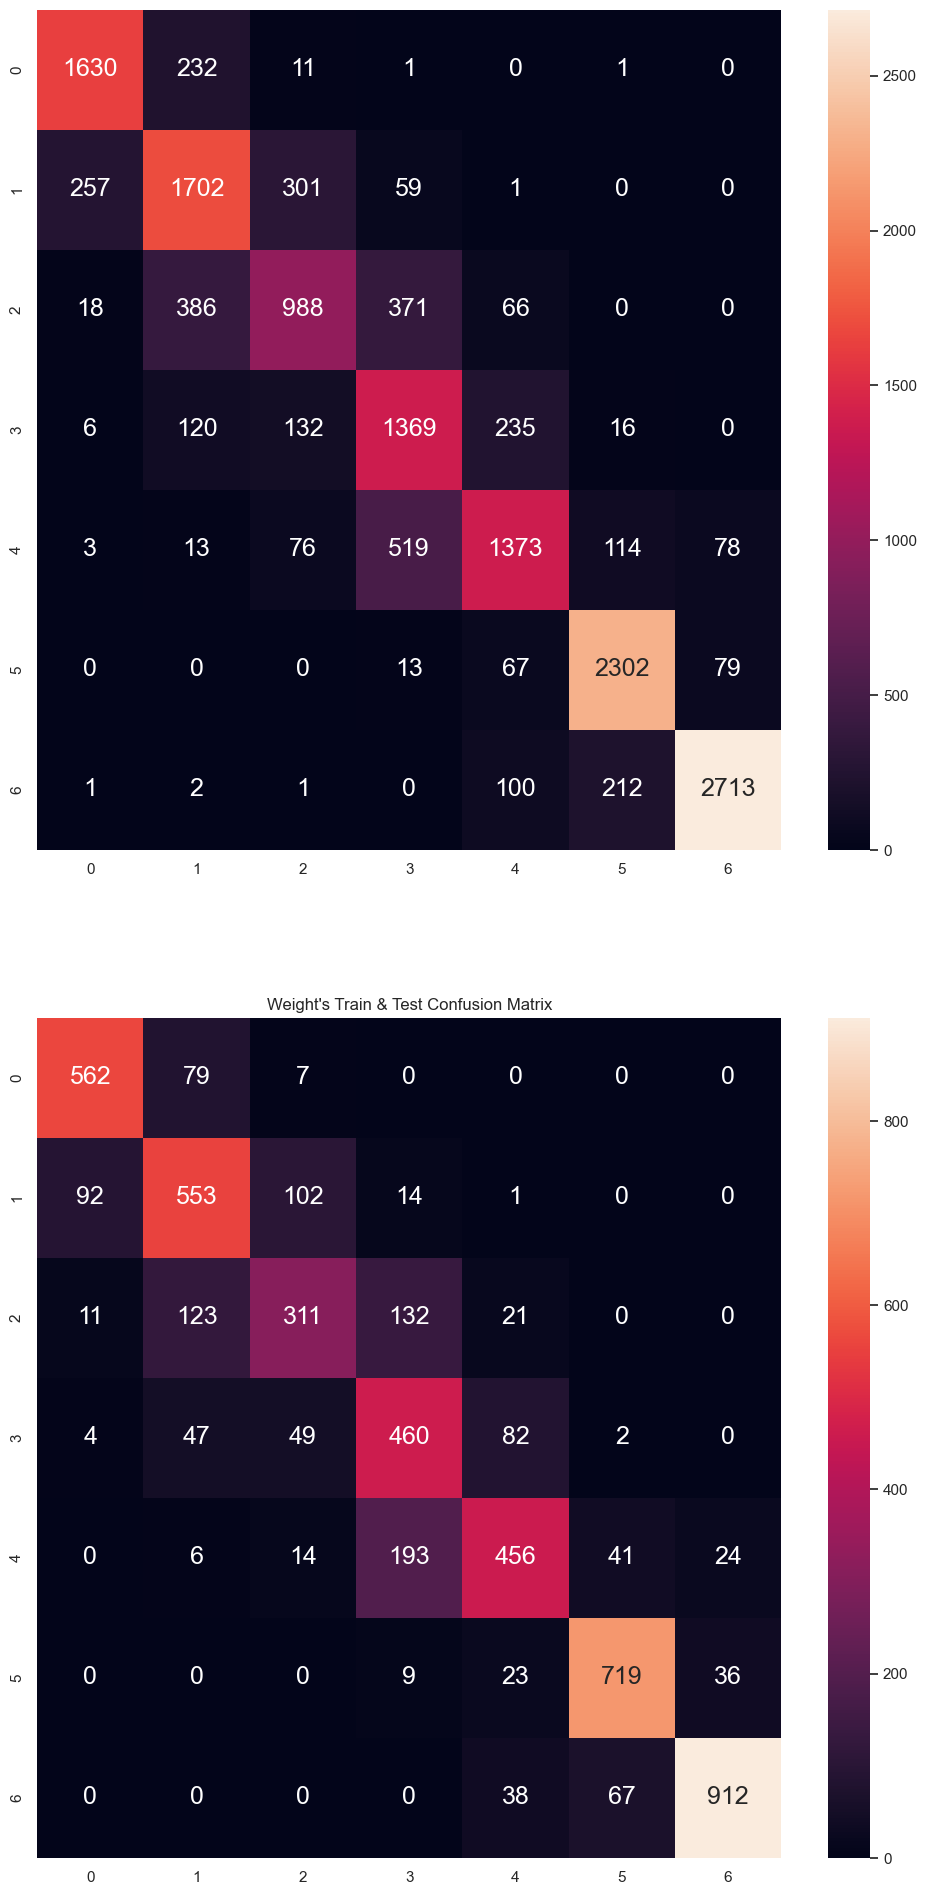

'FCVC' - train & test:


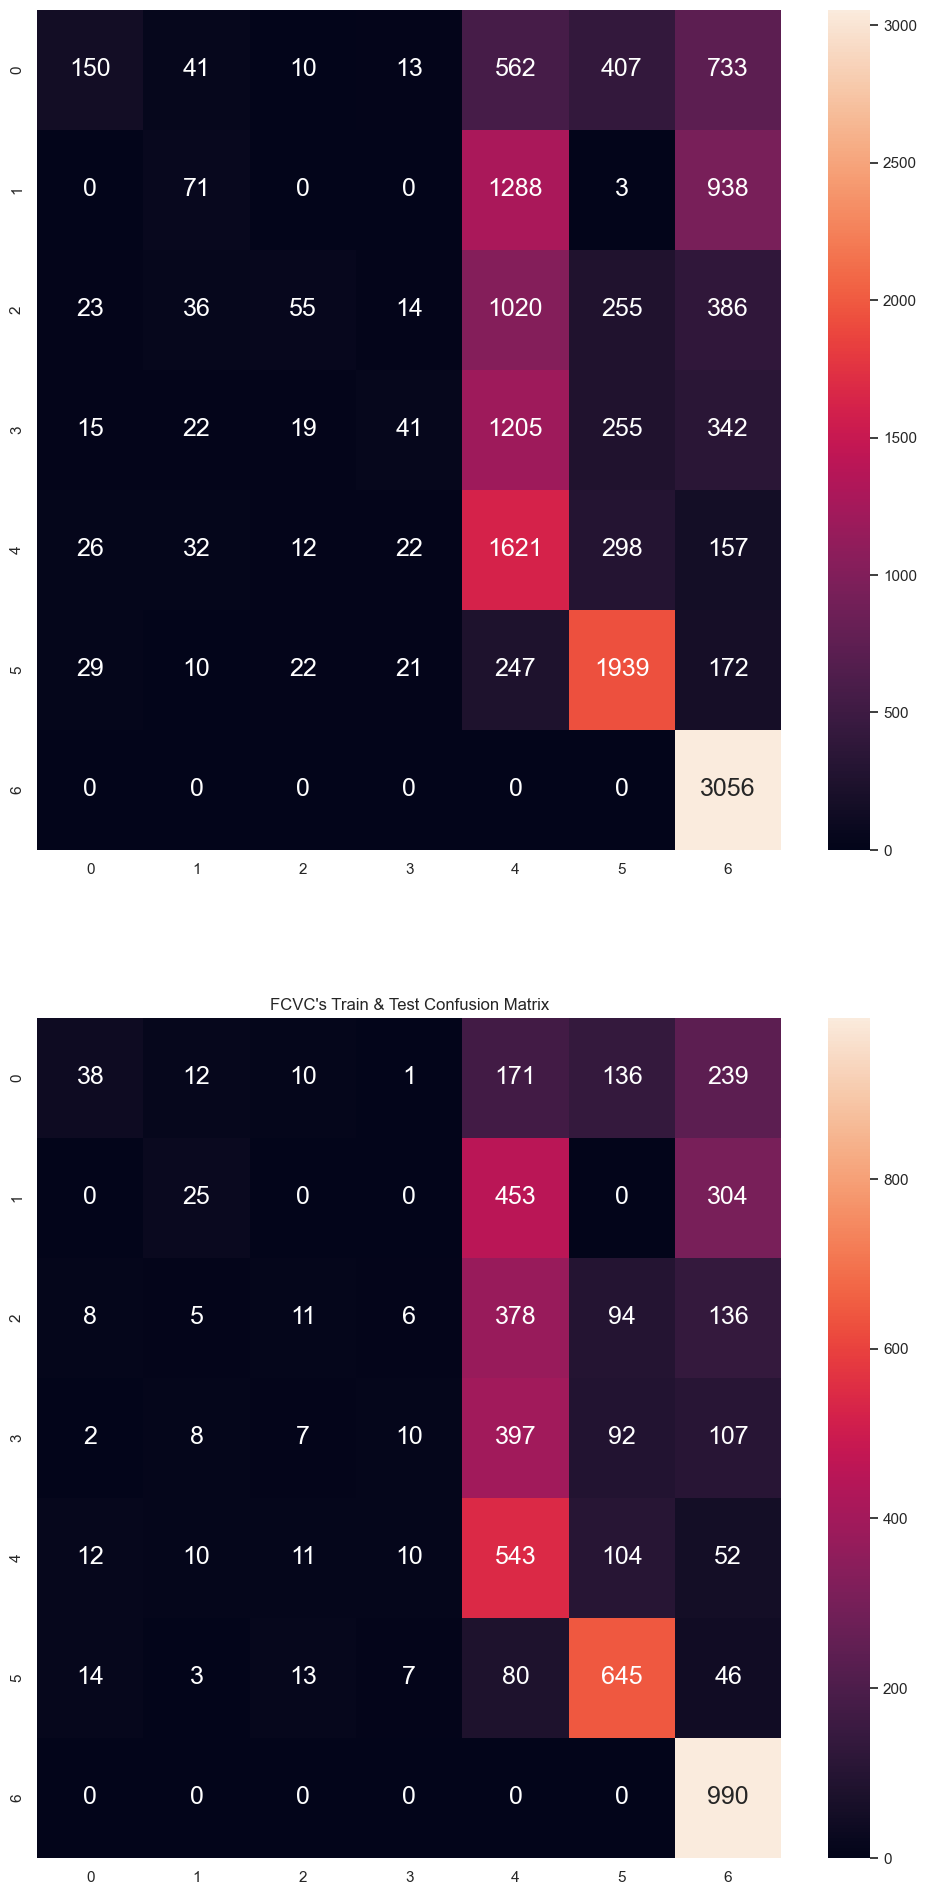

'NCP' - train & test:


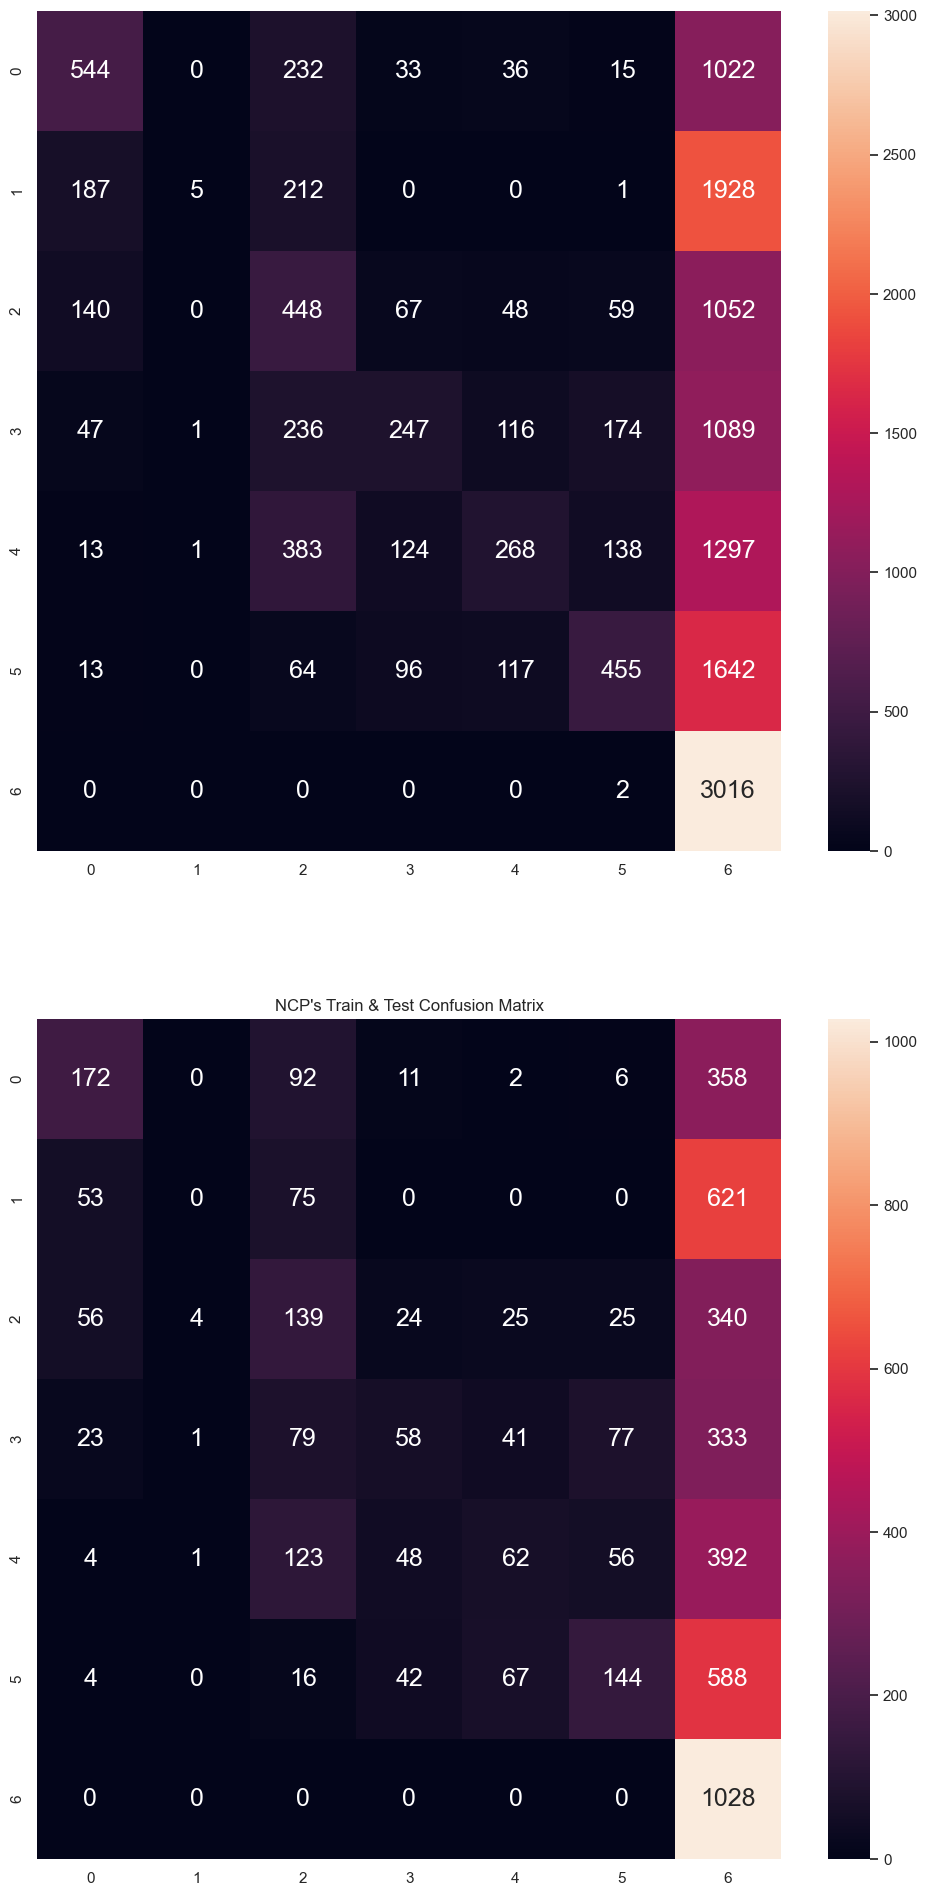

'CH2O' - train & test:


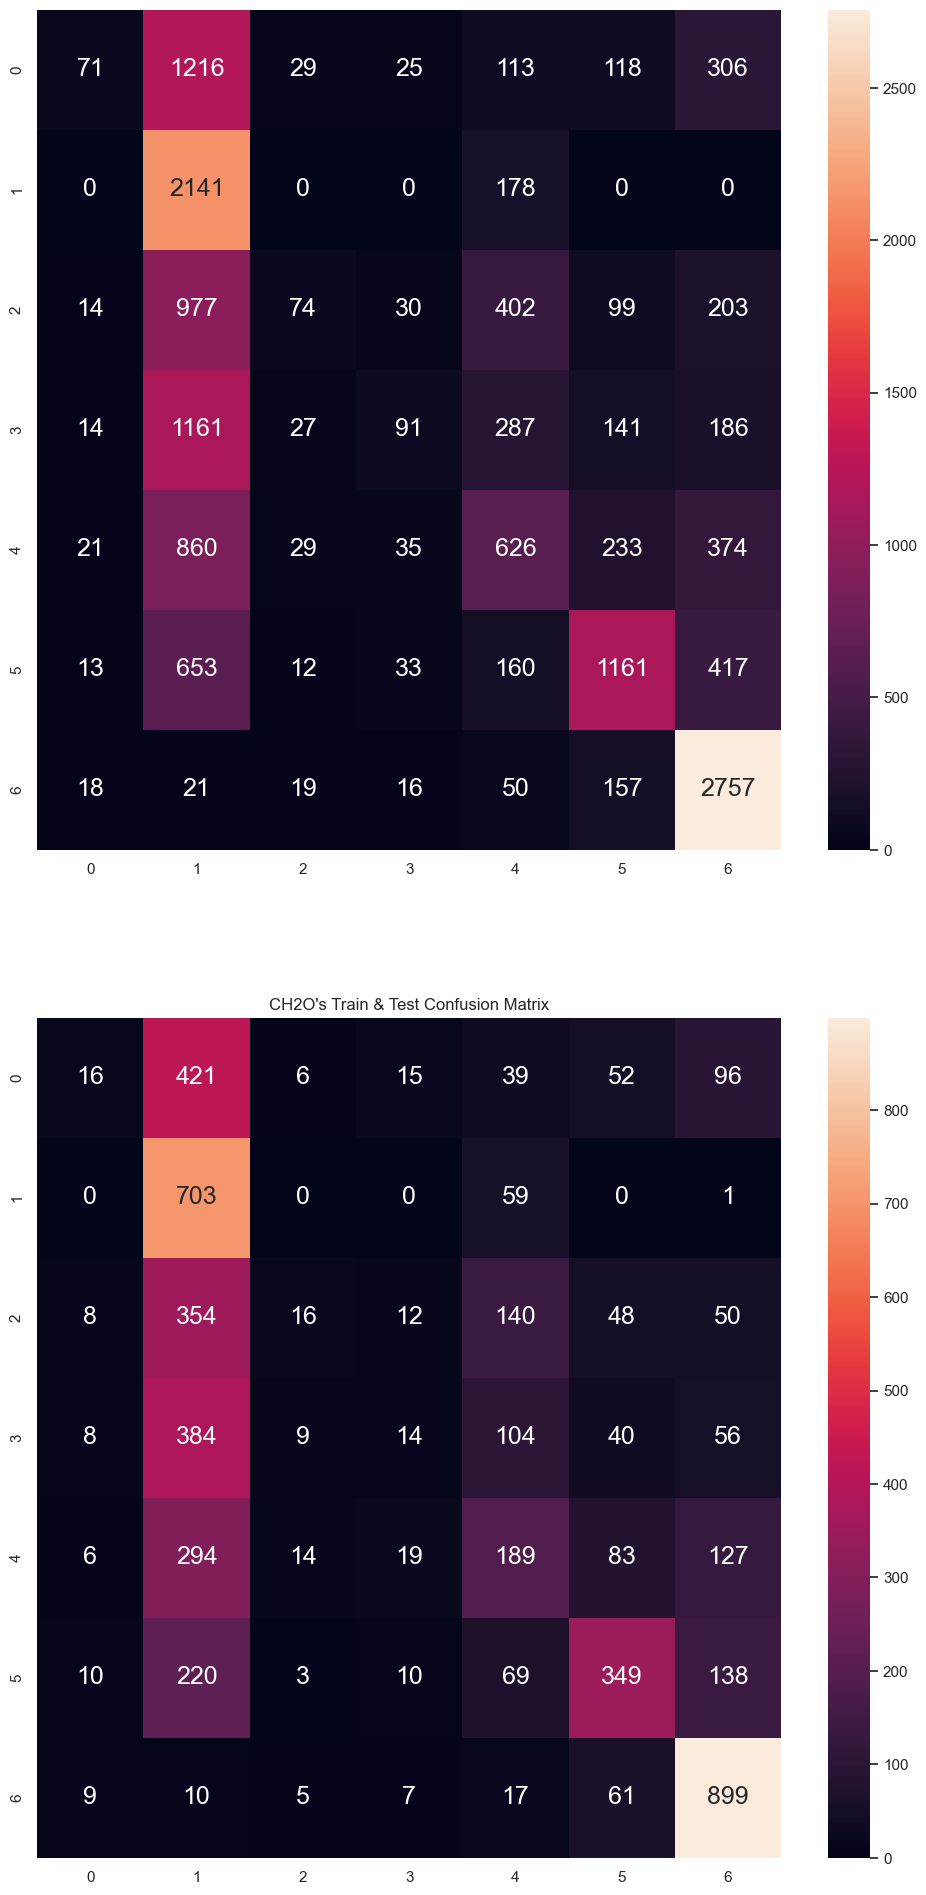

'FAF' - train & test:


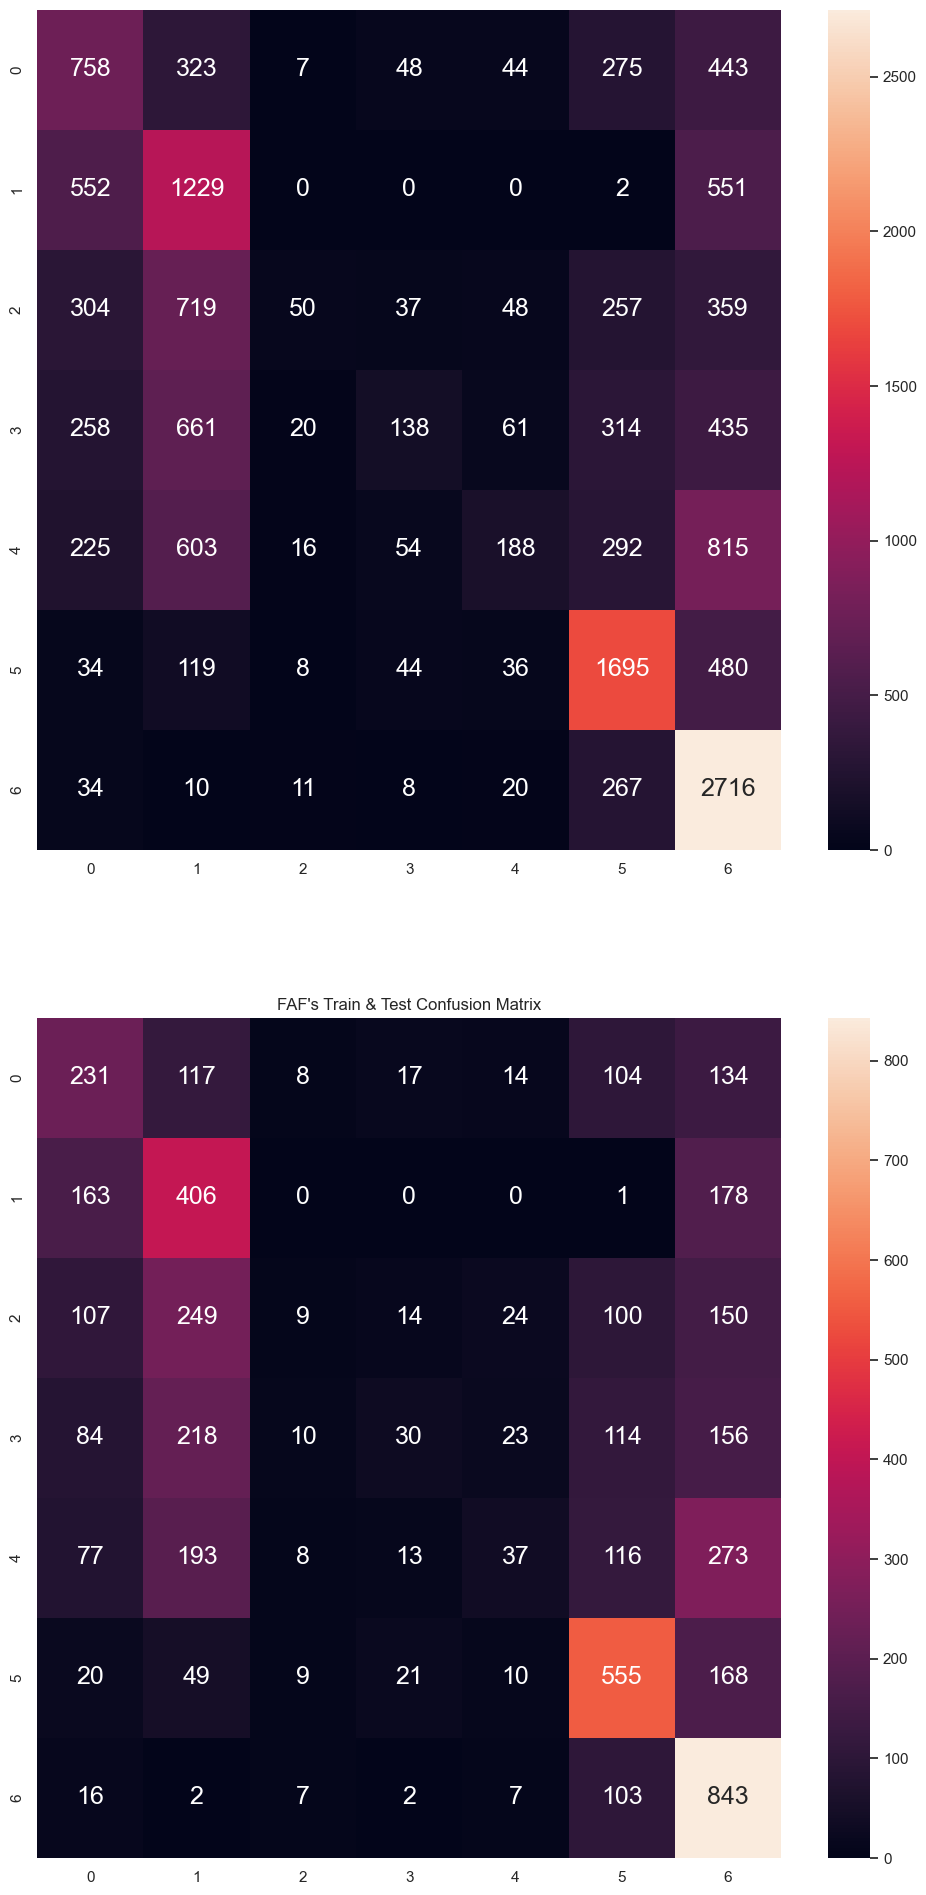

'TUE' - train & test:


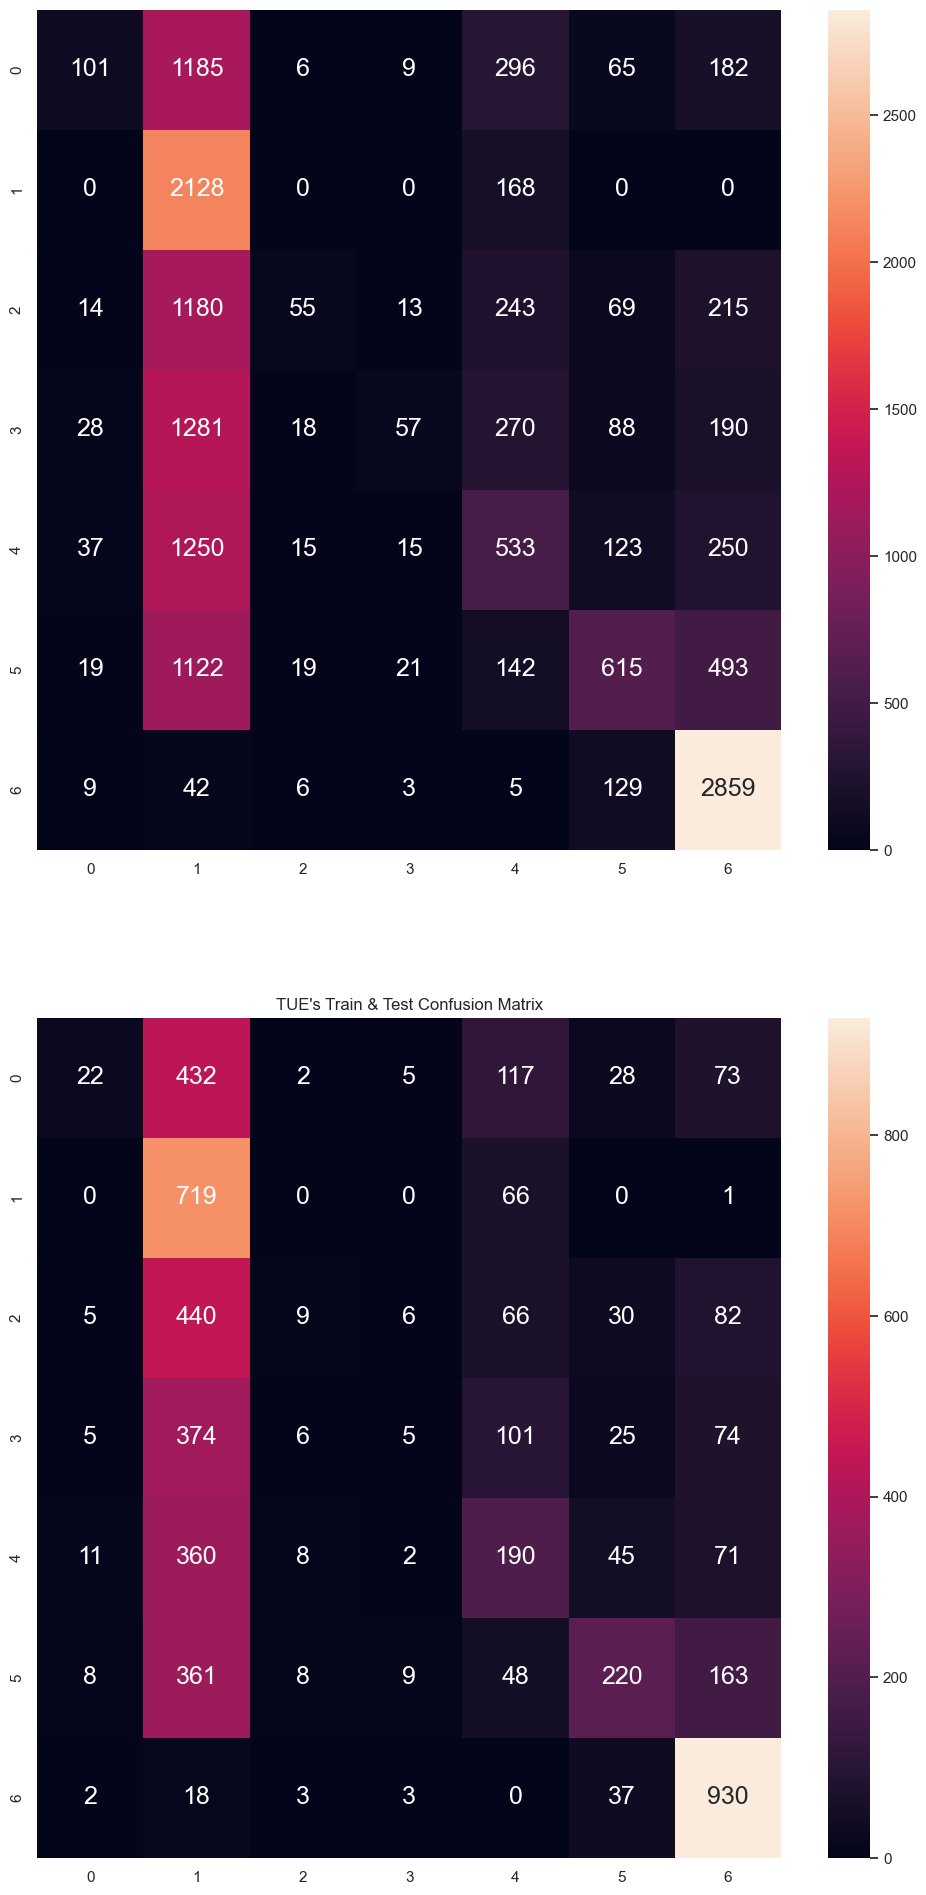

'Gender' - train & test:


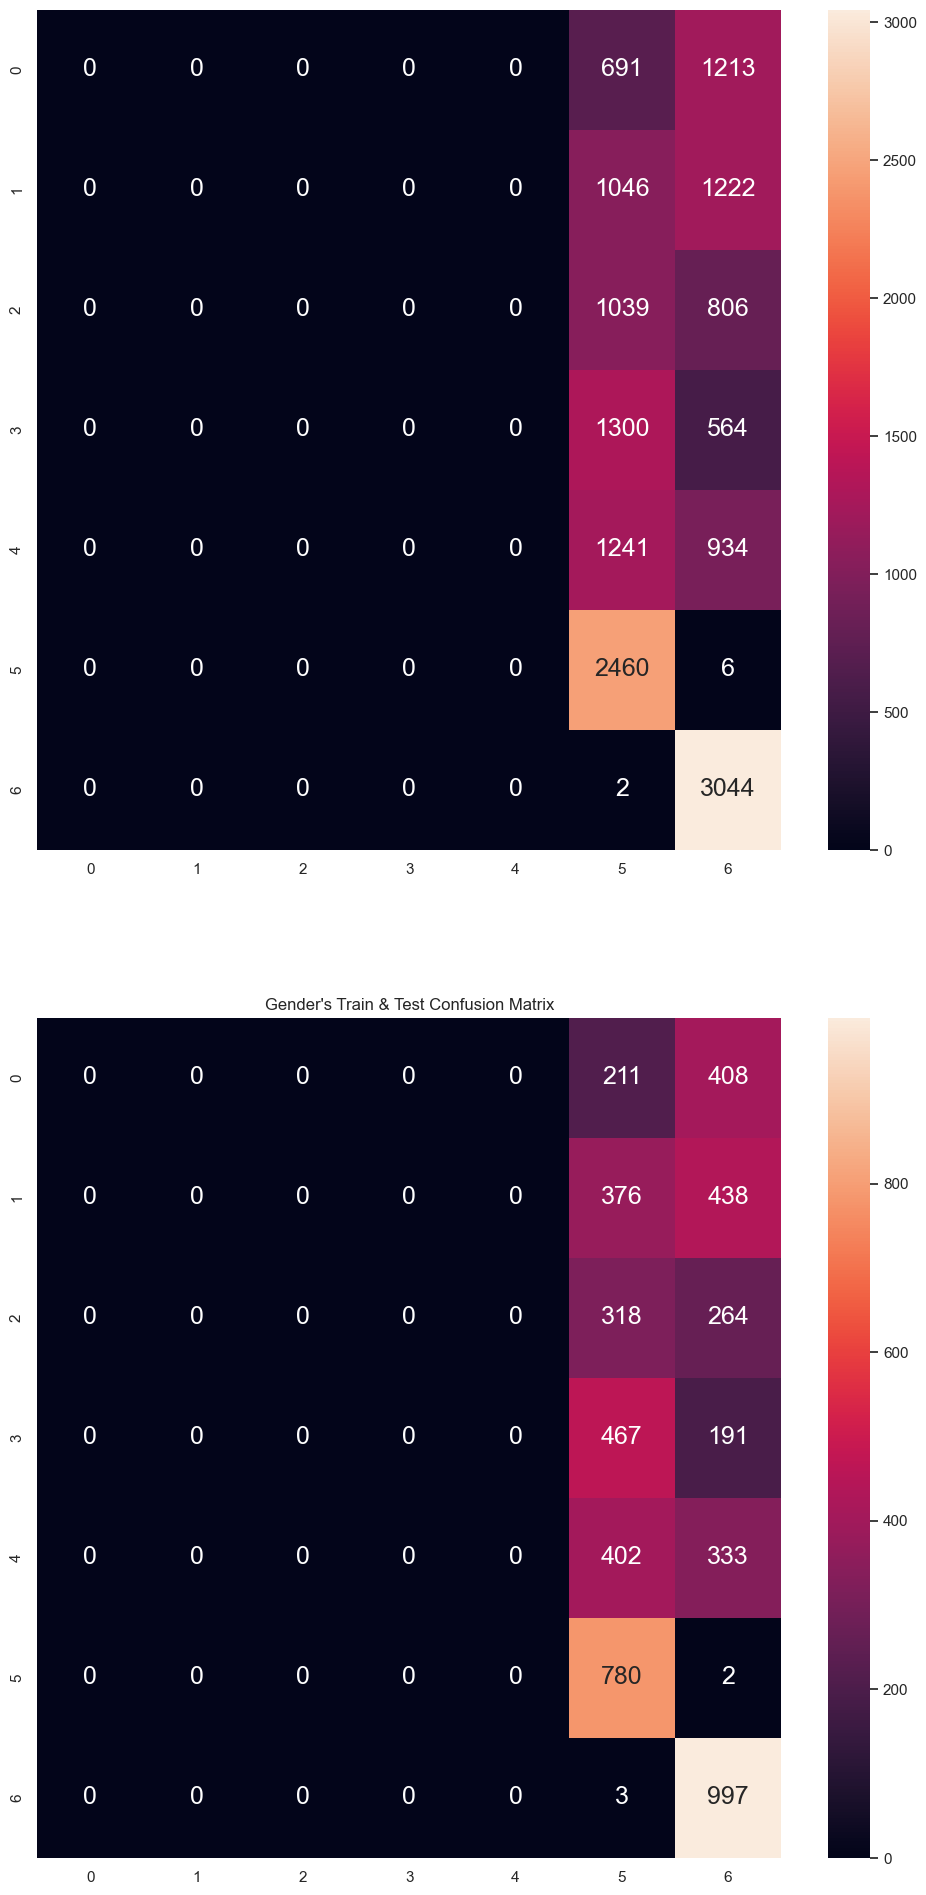

'family_history_with_overweight' - train & test:


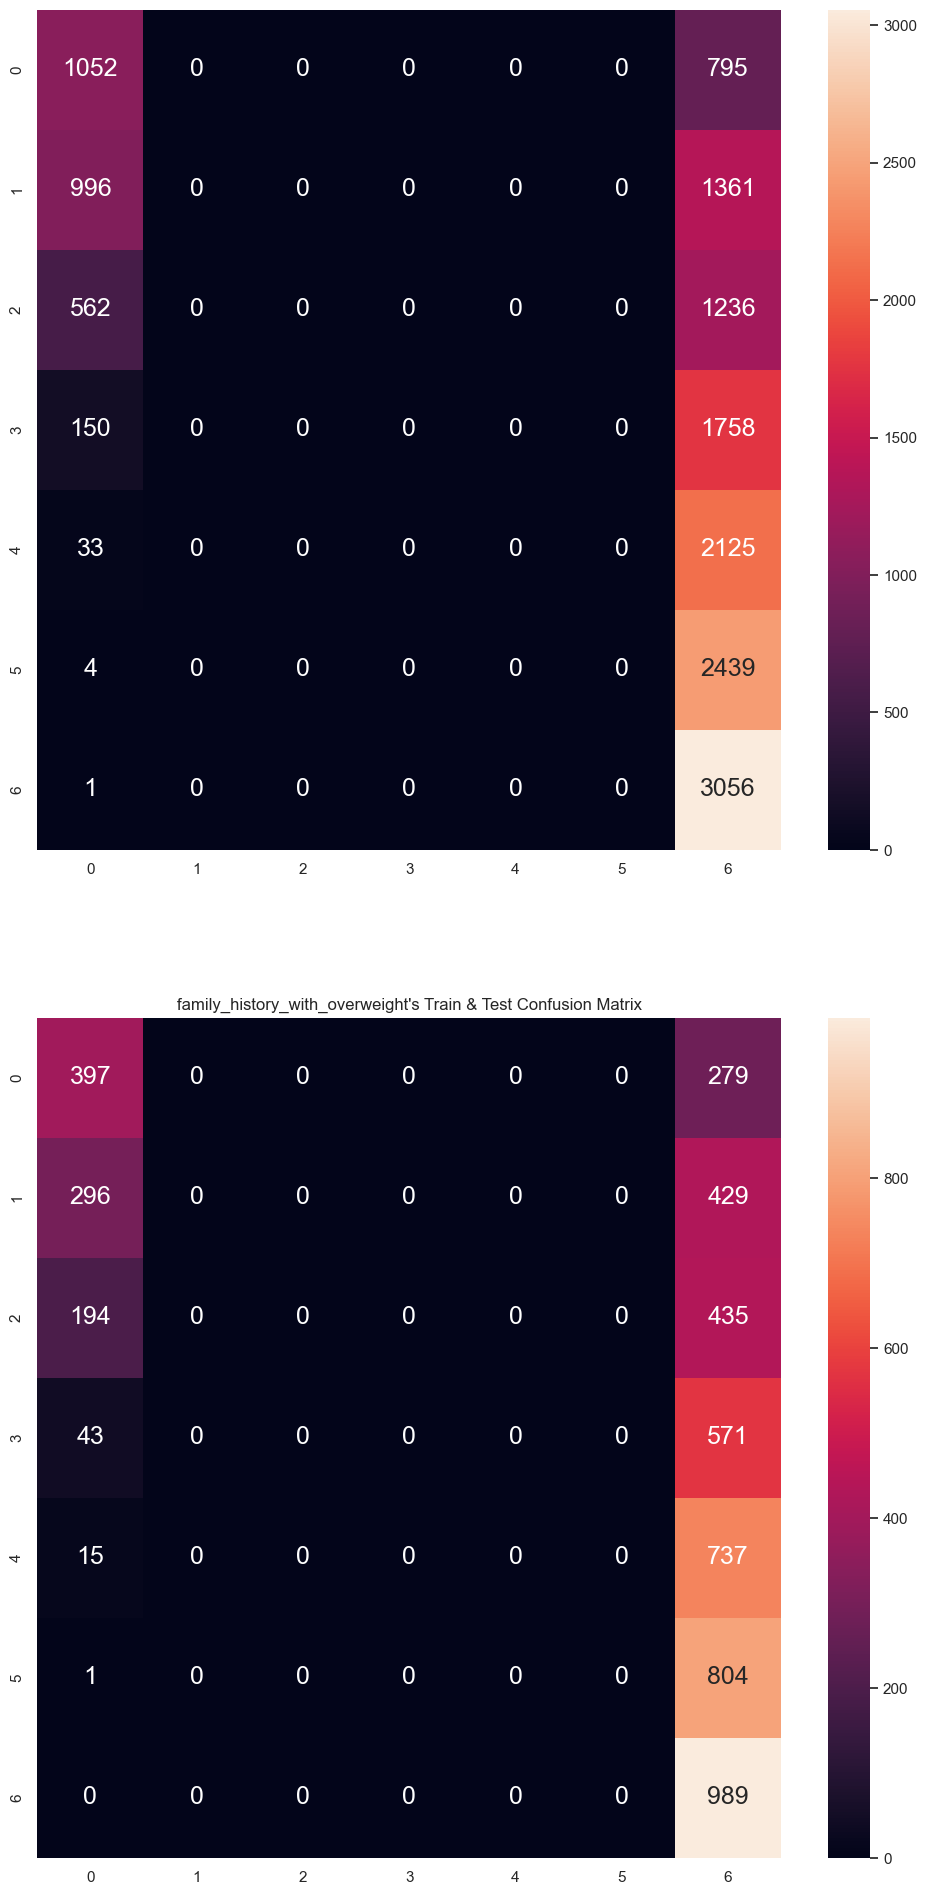

'FAVC' - train & test:


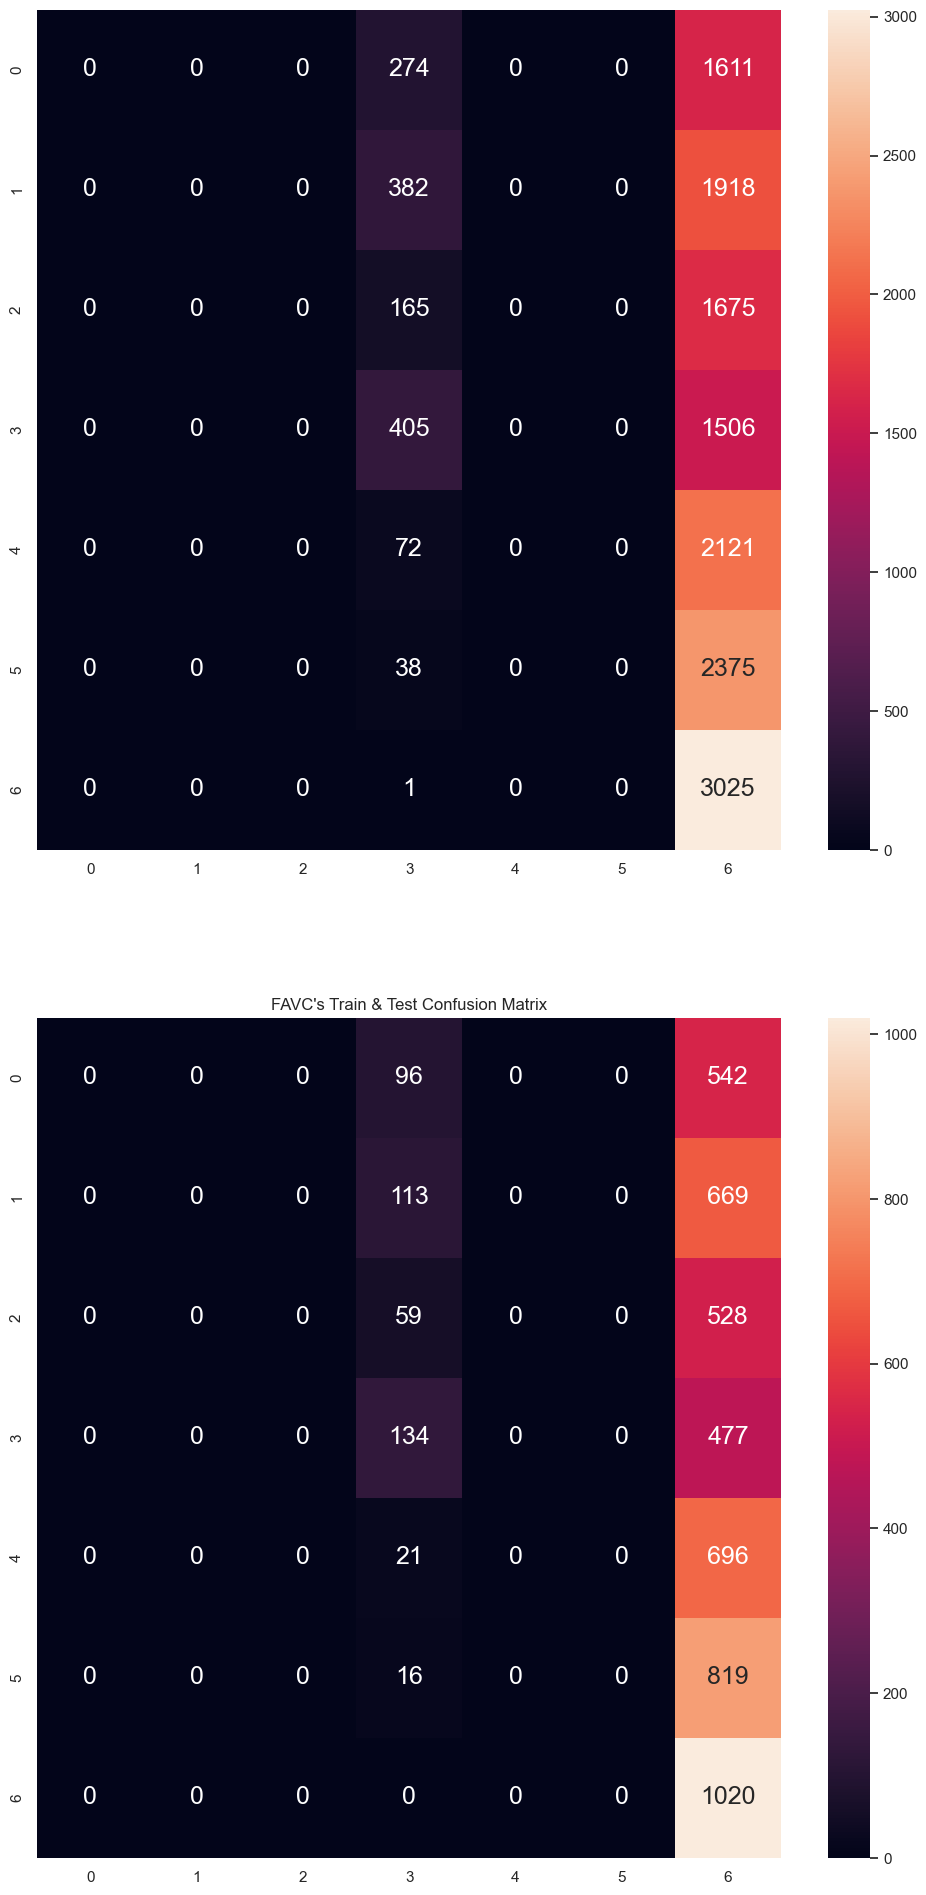

'CAEC' - train & test:


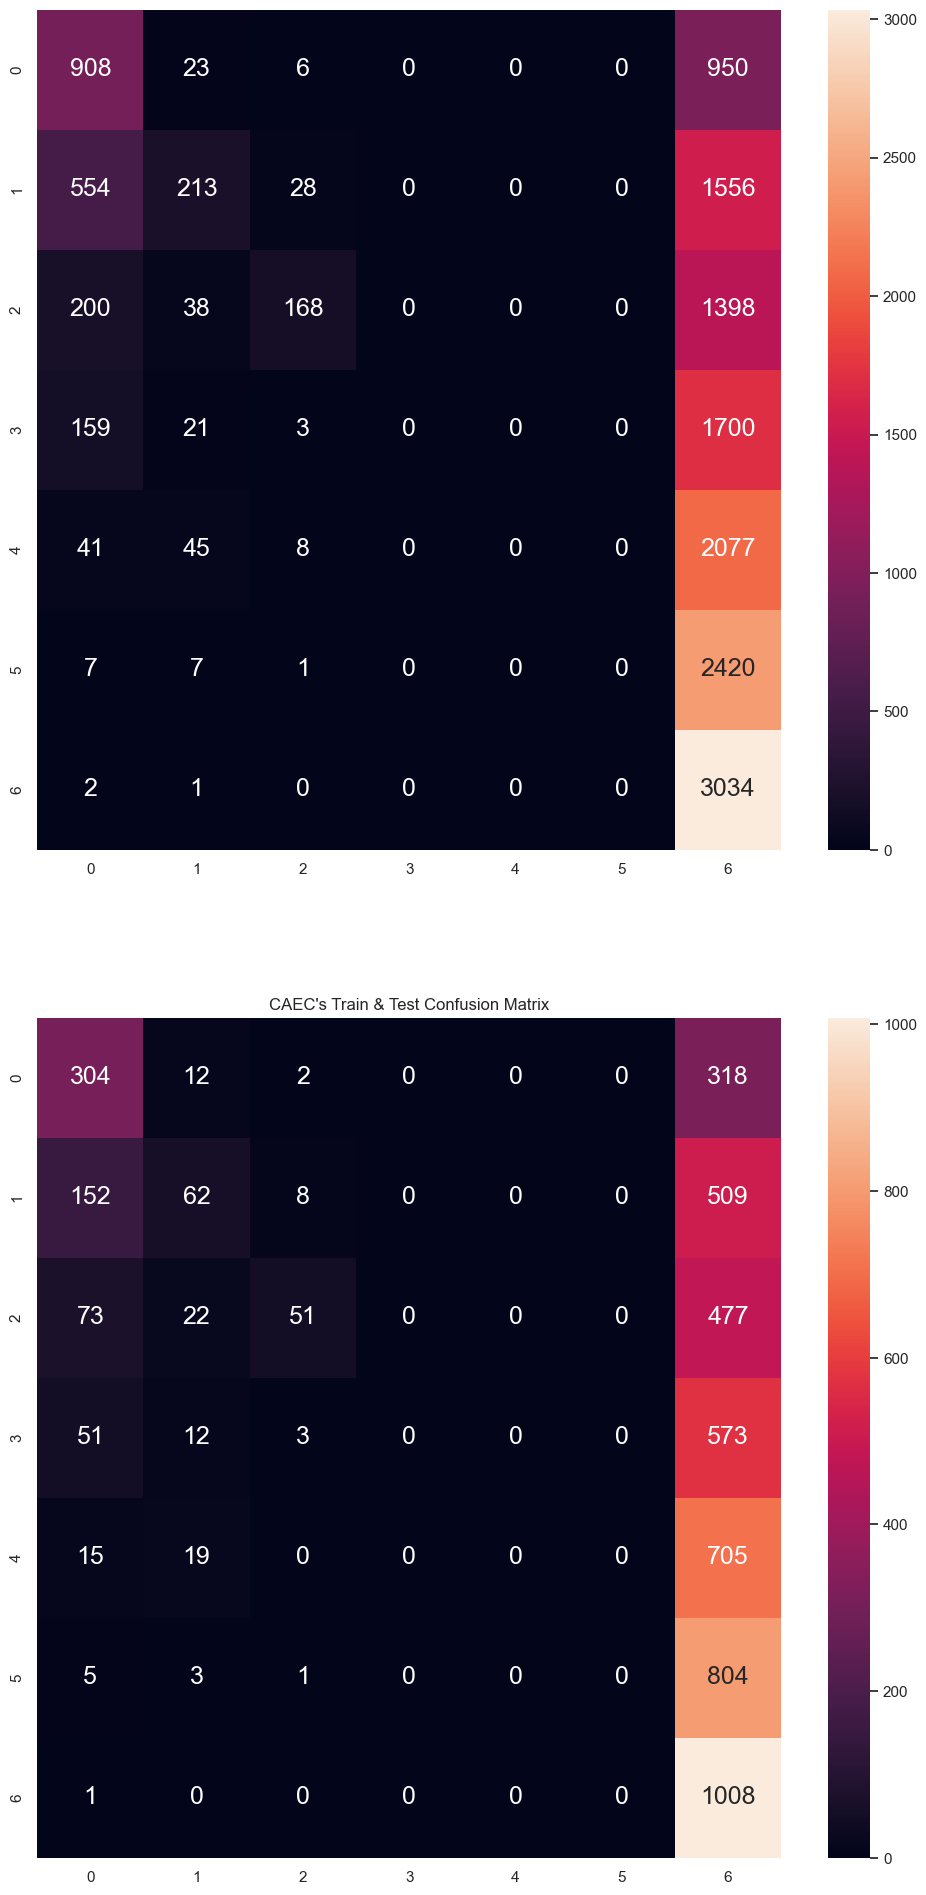

'SMOKE' - train & test:


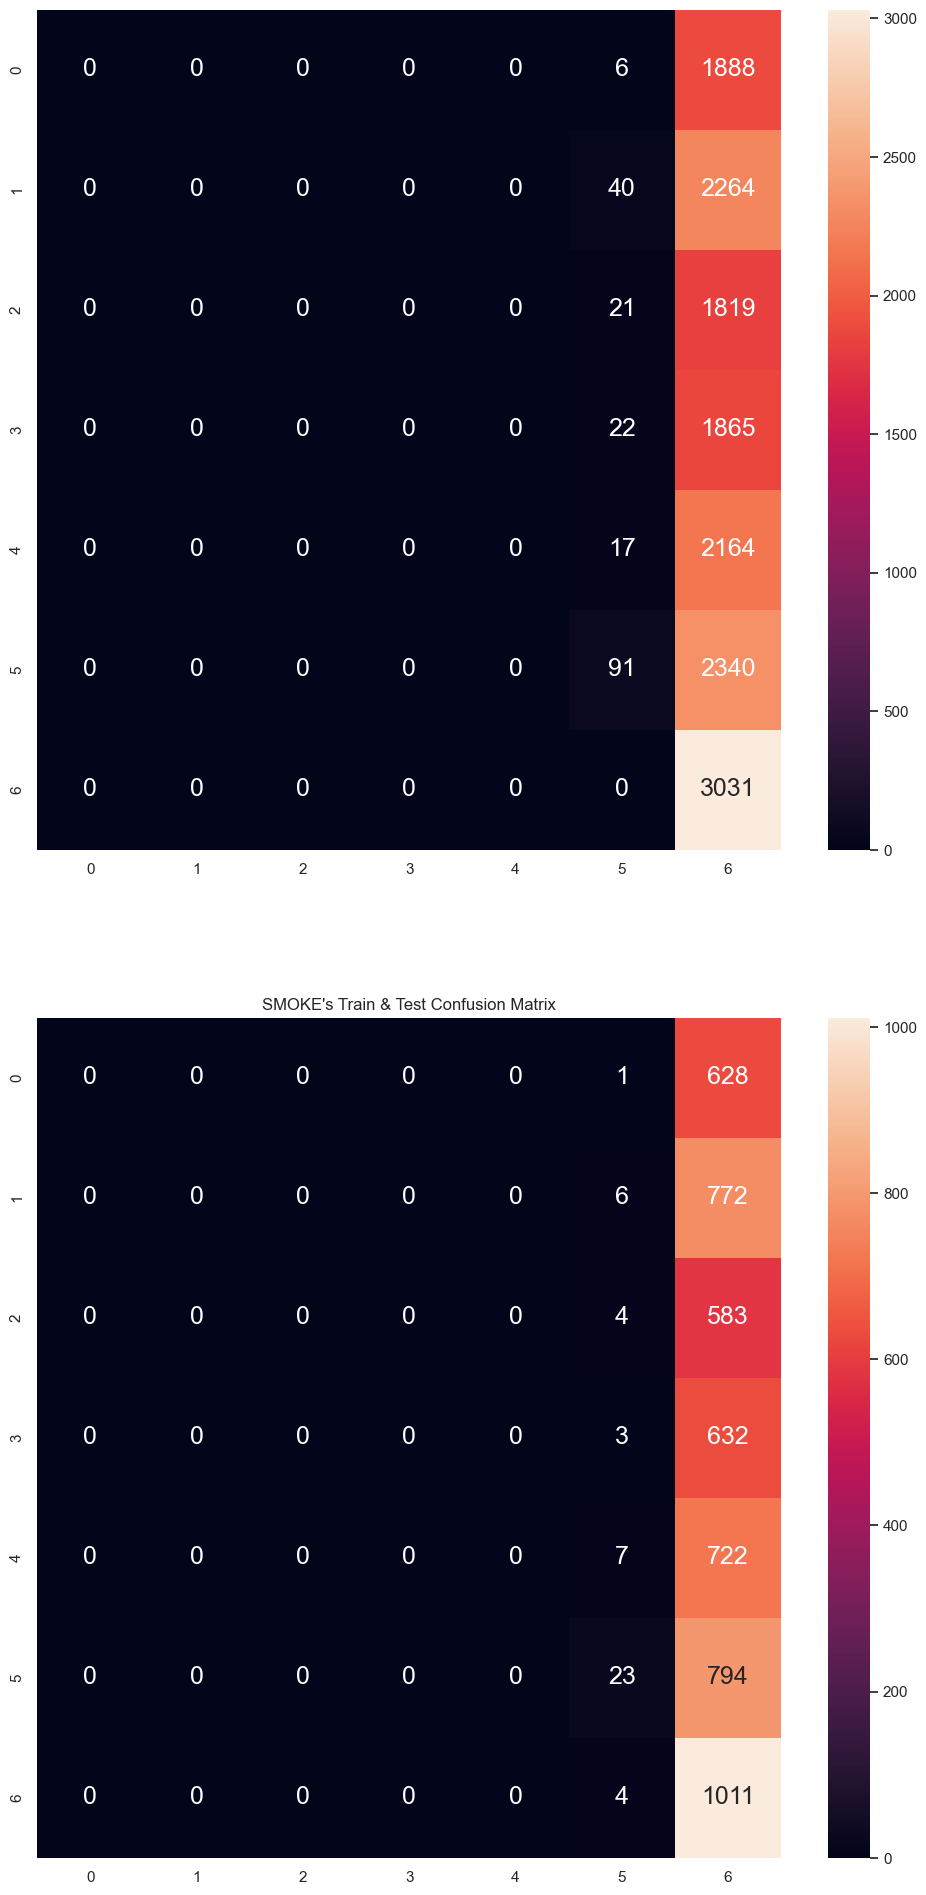

'SCC' - train & test:


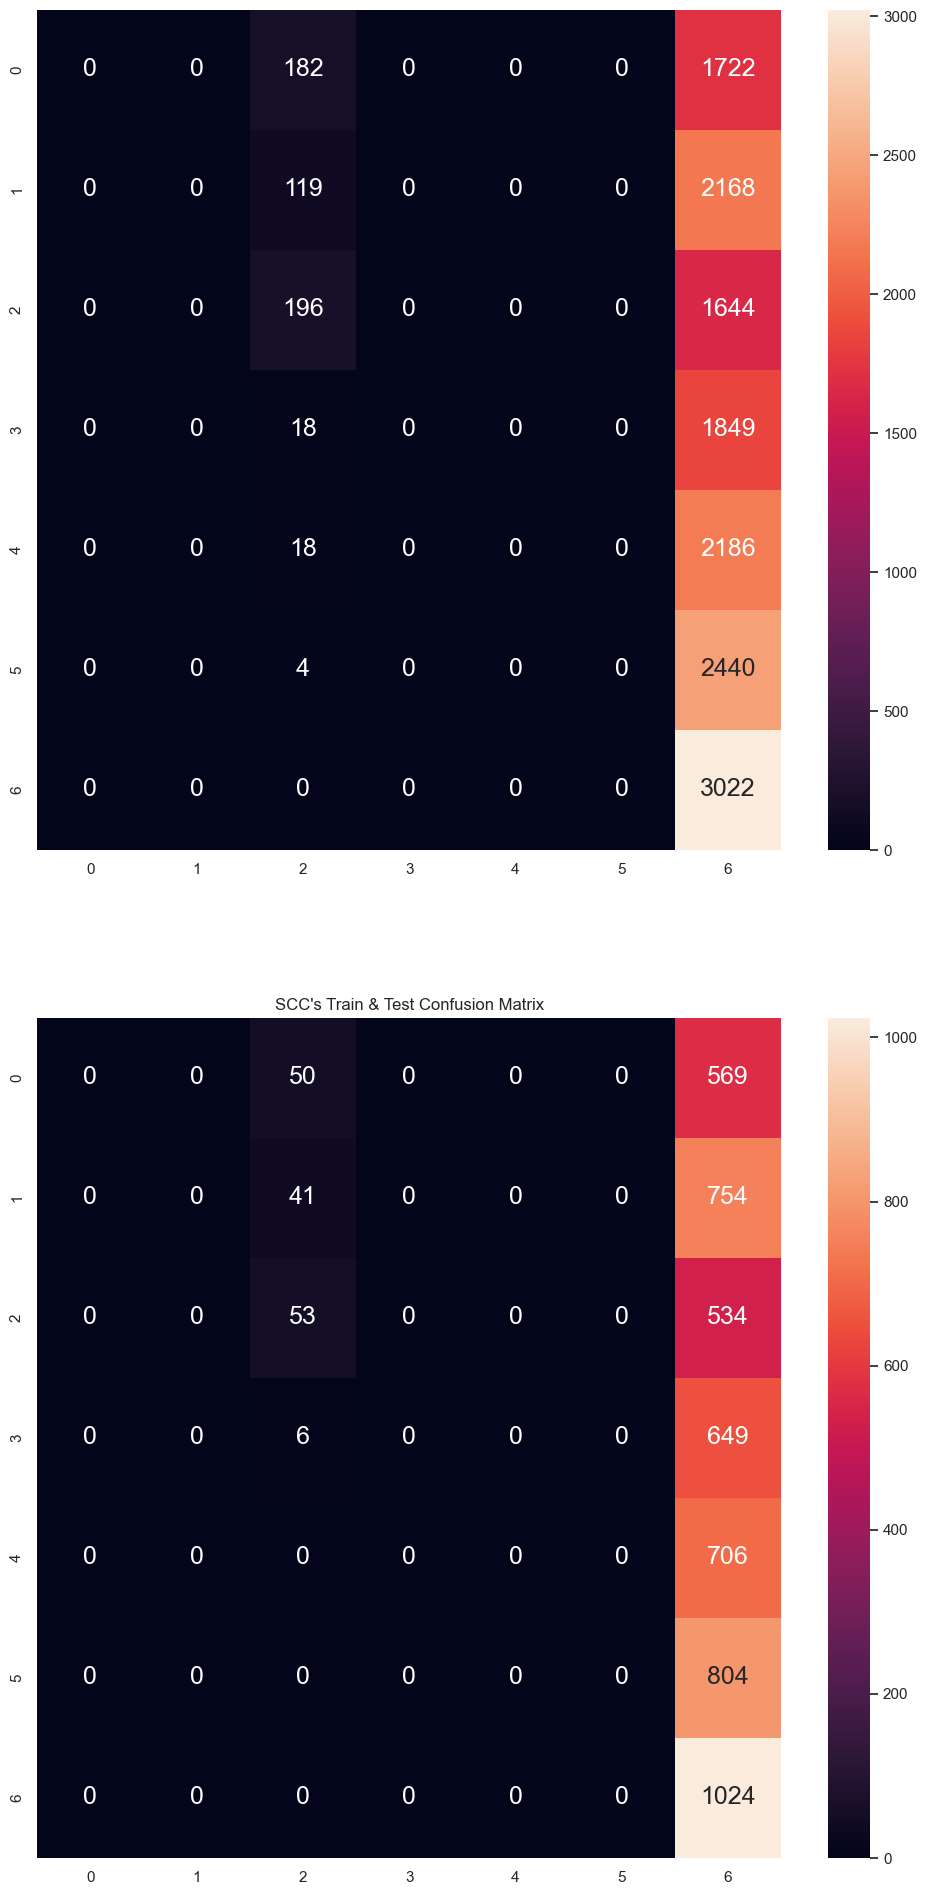

'CALC' - train & test:


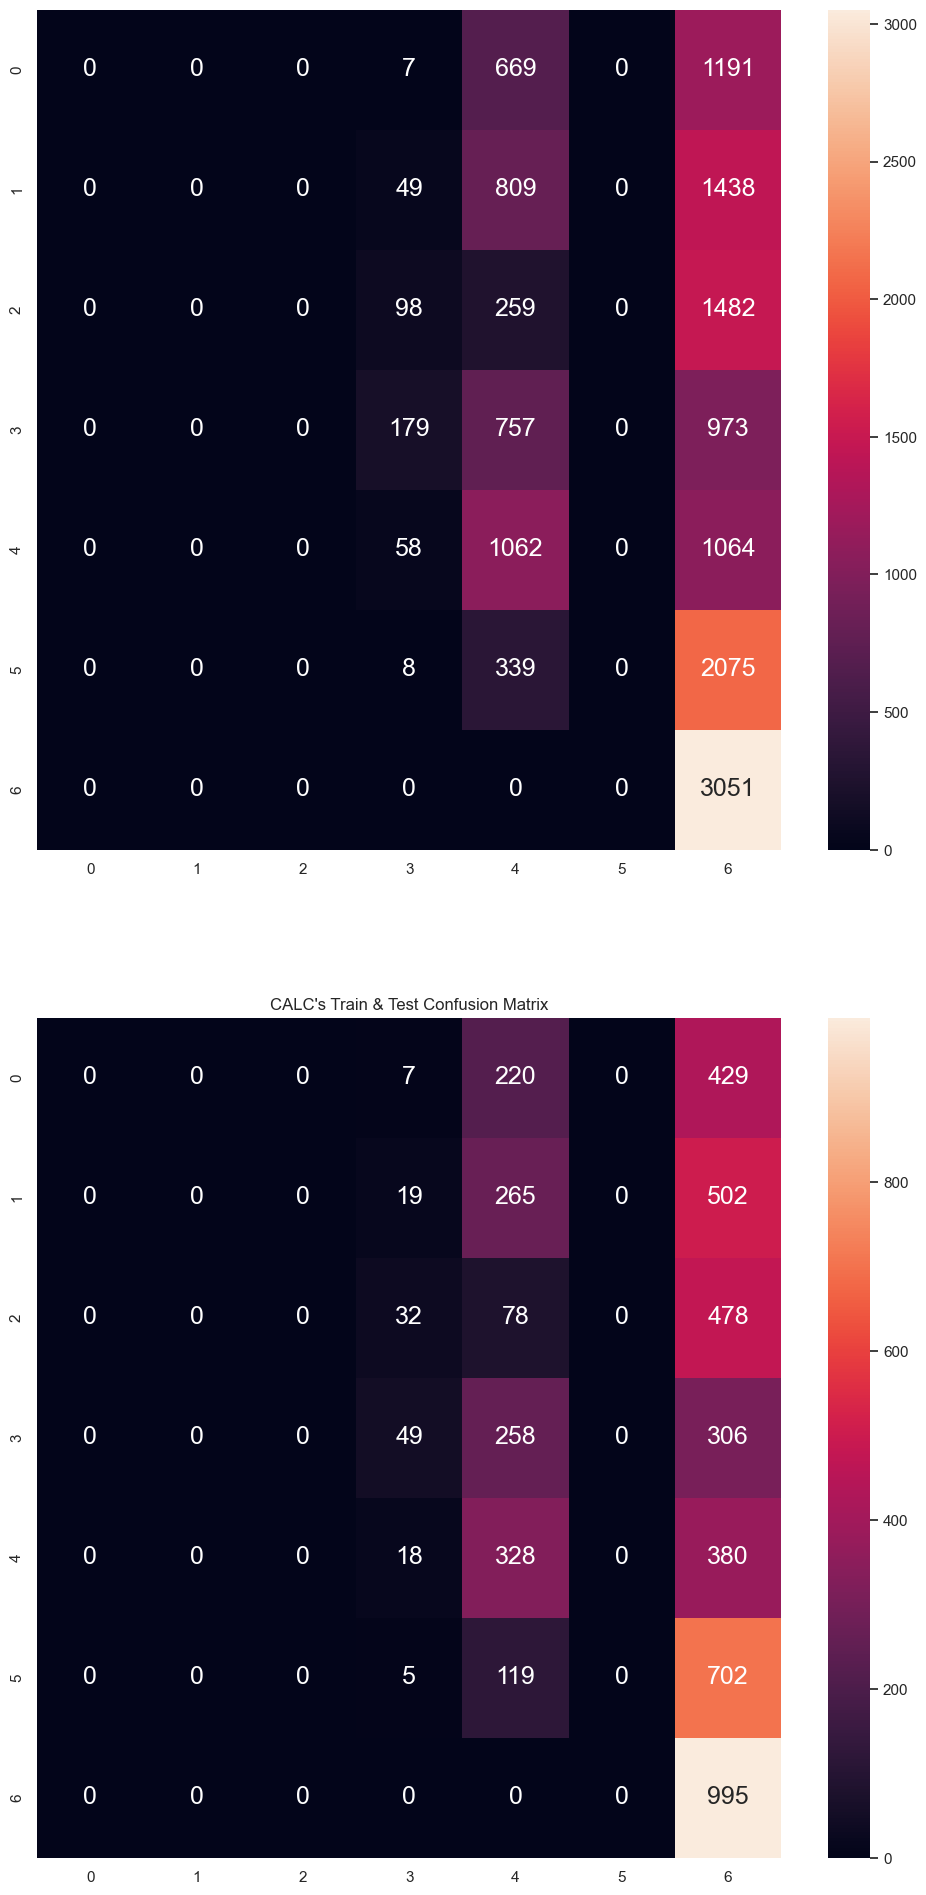

'MTRANS' - train & test:


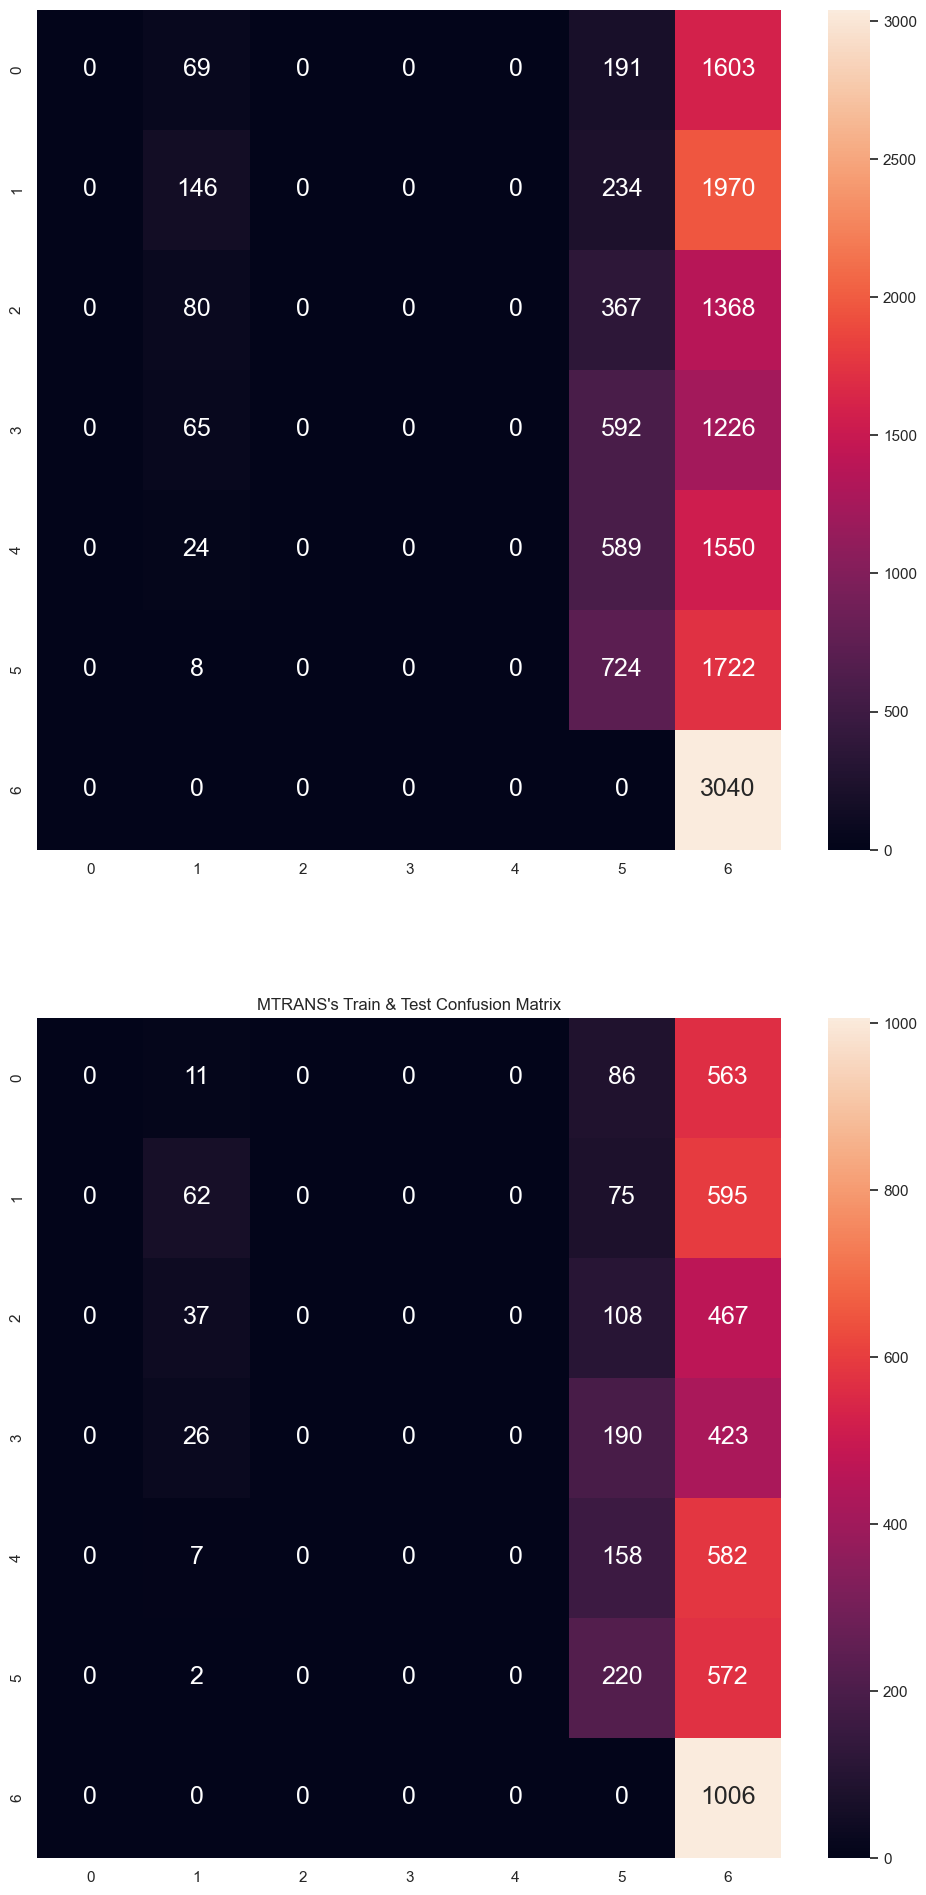

In [14]:
print("Confusion_matrices of each model:")
for t in single_trees:
    t.draw_matrix()

# 4. Multi-Variate Decision Tree

#### (1) Create the multi-variate decision tree and print the goodness

In [15]:
# Choose the proper depth limit

In [16]:
multitree=Classification(data1,all_var,'NObeyesdad')
multitree.apply_tree(max_depth=7)
multitree.print_goodness()

train:  88.2 %
test:  86.6 %



#### (2) Draw the confusion matrix 

Train & Test Confusion Matrix


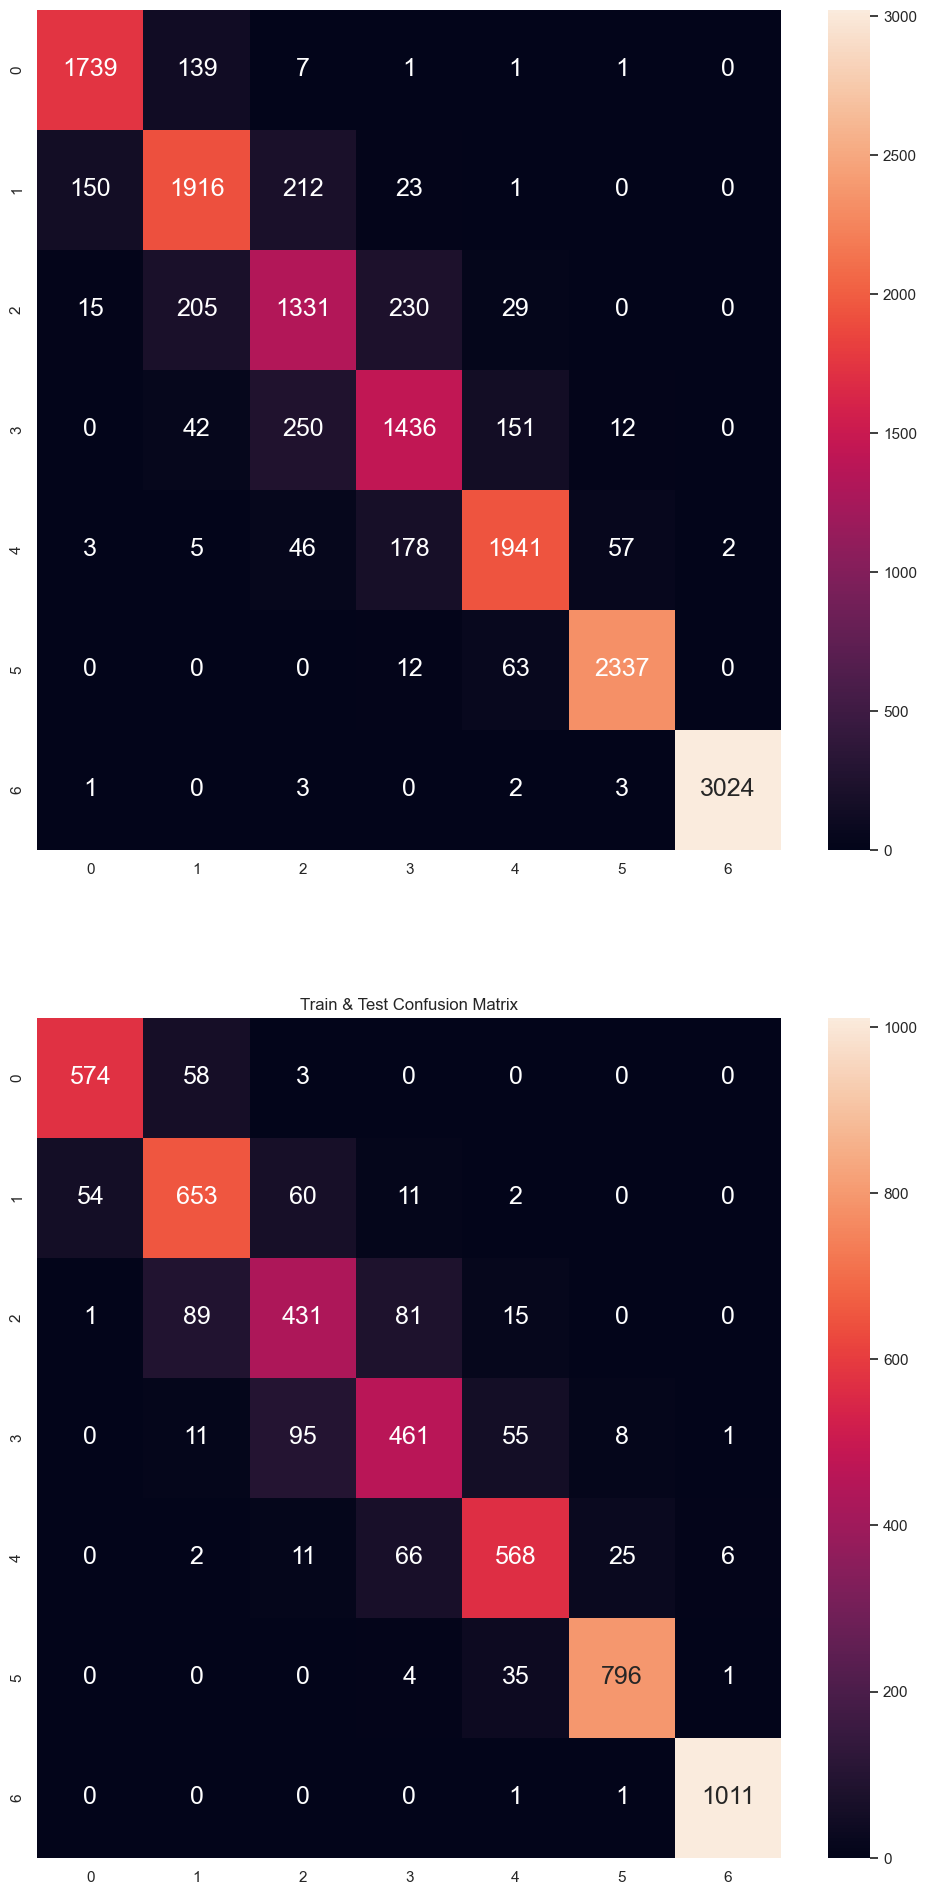

In [17]:
multitree.draw_matrix()

# 5. Random Forest

#### (1) Create the random forest and print the goodness

In [18]:
# Choose the prooper depth limit, and the number of estimators

In [19]:
multitree.apply_RandomForest(n_estimators=20,max_depth=20)
multitree.print_goodness()

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train:  99.7 %
test:  88.9 %



In [20]:
'''
n_estimators= [10, 50, 100, 200, 400]
max_depth= [None, 10, 20, 30, 50]
min_samples_split= [2, 5, 10]
min_samples_leaf= [1, 2, 4]
max_features=['log2', 'sqrt']

max_scores=[0,0]
max_combinations=[0,0,0,0,0]
for a in n_estimators:
    for b in max_depth:
        for c in min_samples_split:
            for d in min_samples_leaf:
                for e in max_features:
                    multitree.apply_RandomForest(
                        n_estimators=a,
                        max_depth=b,
                        min_samples_split=c,
                        min_samples_leaf=d,
                        max_features=e,
                    )
                    train_score=round(multitree.tree.score(multitree.x_train, multitree.y_train),2)
                    test_score=round(multitree.tree.score(multitree.x_test, multitree.y_test),2)
                    multitree.print_goodness()
                    if test_score>max_scores[1]:
                        max_scores=[train_score,test_score]
                        max_combinations=[a,b,c,d,e]
multitree.apply_RandomForest(
    n_estimators=max_combinations[0],
    max_depth=max_combinations[1],
    min_samples_split=max_combinations[2],
    min_samples_leaf=max_combinations[3],
    max_features=max_combinations[4],
)
multitree.print_goodness()
'''

"\nn_estimators= [10, 50, 100, 200, 400]\nmax_depth= [None, 10, 20, 30, 50]\nmin_samples_split= [2, 5, 10]\nmin_samples_leaf= [1, 2, 4]\nmax_features=['log2', 'sqrt']\n\nmax_scores=[0,0]\nmax_combinations=[0,0,0,0,0]\nfor a in n_estimators:\n    for b in max_depth:\n        for c in min_samples_split:\n            for d in min_samples_leaf:\n                for e in max_features:\n                    multitree.apply_RandomForest(\n                        n_estimators=a,\n                        max_depth=b,\n                        min_samples_split=c,\n                        min_samples_leaf=d,\n                        max_features=e,\n                    )\n                    train_score=round(multitree.tree.score(multitree.x_train, multitree.y_train),2)\n                    test_score=round(multitree.tree.score(multitree.x_test, multitree.y_test),2)\n                    multitree.print_goodness()\n                    if test_score>max_scores[1]:\n                        max_scores

#### (2) Draw the confusion matrix 

Train & Test Confusion Matrix


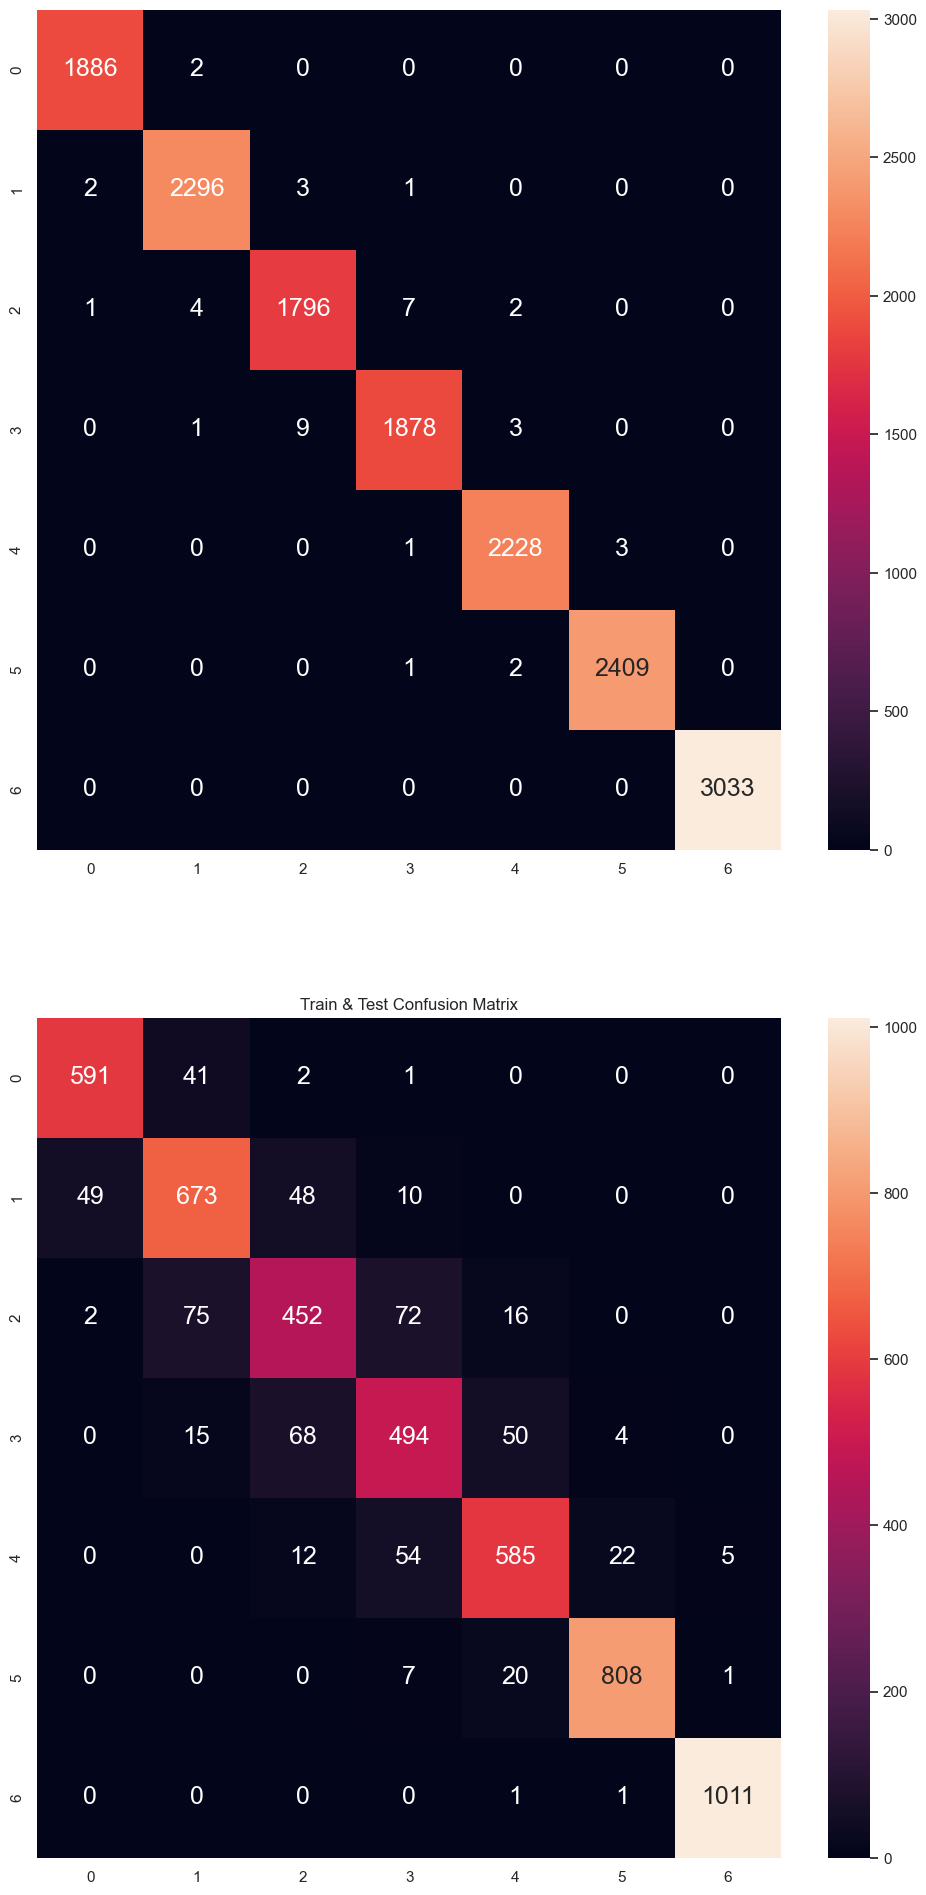

In [21]:
multitree.draw_matrix()

# 6. More models

#### (1) These are some other models for classification

In [22]:
models = [
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('GradientBoost', GradientBoostingClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
    ('SVM', SVC(random_state=42)),
]

#### (2) Apply each model (very slow)

In [23]:
multitree.apply_more_models(models)

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

#### (3) Print the result of each model

In [24]:
multitree.print_more_models_result()

DecisionTree: 84.4 %
RandomForest: 89.8 %
GradientBoost: 90.5 %
LogisticRegression: 81.9 %
SVM: 71.0 %
